***
*Project:* Helmholtz Machine

*Author:* Jingwei Liu, Computer Music Ph.D., UC San Diego
***

# <span style="background-color:darkorange; color:white; padding:2px 6px">Function Test</span> 

# Helmholtz Machine Conditioning


*Updated:* Mar 24, 2025


In [239]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import time
torch.cuda.is_available()

True

In [3]:
def para_init(n_dz,dev):
    """
    Arguments:
    n_dz -- torch tensor of size len(n_dz)
    init_type -- "zero"

    Returns:
    Phi, Theta -- set of parameters for hierarchical layers
    """
    Phi = {}
    Theta = {}
    l = len(n_dz)
    for i in range(l-2):
        Phi["Phi_" + str(i) + str(i+1)] = torch.zeros((n_dz[i+1],n_dz[i]),device=dev)
    for i in range(l-1,1,-1):
        Theta["Theta_" + str(i) + str(i-1)] = torch.zeros((n_dz[i-1],n_dz[i]),device=dev)
    Theta["Theta_10"] = torch.zeros((n_dz[0],n_dz[1]+n_dz[0]-1),device=dev) # conditioning lower triangular
    return Phi,Theta

In [4]:
def sigmoid(x):
    """
    Arguments:
    x -- torch tensor of shape (n,batch_size)
    
    Returns:
    p -- probability of layer y, torch tensor of shape (n,batch_size)
    """
    p = 1/(1+torch.exp(-x))
    return p

In [5]:
def one_step_forward(x,param):
    """
    Arguments:
    x -- input layer, torch tensor of shape (n_x,batch_size)
    param -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    
    Returns:
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    """
    q = sigmoid(torch.matmul(param,x.type(torch.float)))
    return q

In [6]:
def sample(q,dev):
    """
    Arguments:
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    dev -- device
    
    Returns:
    y -- instantiation of layer y, torch tensor of shape (n_y,batch_size)
    """
    y = (q > torch.rand(q.size(),device=dev)).long() # rejection sampling
    return y

In [7]:
def log(p):
    q = torch.where(p != 0, torch.log(p), -20) # replace log(0) with -20
    return q

In [8]:
def cross_entropy_loss(y,q):
    """
    Arguments:
    y -- output layer sample, torch tensor of shape (n_y,batch_size)
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    
    Returns:
    loss -- cross entropy loss, L = -(y.*log(q)+(1-y).*log(1-q)).mean()
    """
    loss = -(y * log(q) + (1-y) * log(1-q)).mean()
    return loss

In [9]:
def one_step_update(x,y,param,lr):
    """
    Arguments:
    x -- input layer sample, torch tensor of shape (n_x,batch_size)
    y -- output layer sample, torch tensor of shape (n_y,batch_size)
    param -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    lr -- learning rate
    
    Returns:
    grad -- gradient of parameters. Torch tensor of shape (n_y,n_x)
    param -- updated parameters from x to y. Torch tensor of shape (n_y,n_x)
    loss -- cross entropy loss, L = -(y.*log(q)+(1-y).*log(1-q)).mean()
    """
    batch_size = x.shape[1]
    q = one_step_forward(x,param)
    grad = torch.matmul(q-y,torch.t(x.type(torch.float)))/batch_size # weight by precision
    param = param - lr*grad
    loss = cross_entropy_loss(y,q)
    return param, grad, loss

In [10]:
def layer_wise_train(input_x,param_xy,param_yx,lr):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param_xy -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    param_yx -- parameters from y to x. Torch tensor of shape (n_x,n_y)
    lr -- learning rate
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,batch_size)
    param_yx -- updated parameters from y to x
    grad -- gradient of param_yx. Torch tensor of shape (n_x,n_y)
    loss -- cross entropy loss at layer x
    """
    # Compute output layer distribution
    q = one_step_forward(input_x,param_xy)
    
    # Sample the output layer
    output_y = sample(q,dev)
    
    # train the opposite phase from x to y
    param_yx, grad, loss = one_step_update(output_y,input_x,param_yx,lr)
    
    return output_y, param_yx, grad, loss

In [11]:
def data_layer_train(input_x,param_xy,param_yx,lr,dev):
    """
    Arguments:
    input_x -- Layer 0 sample, torch tensor of shape (n_d,batch_size)
    param_xy -- parameters from Layer 0 to Layer 1. Torch tensor of shape (n_z1,n_d)
    param_yx -- parameters from Layer 1 and sampled values at Layer 0 to Layer 0. Torch tensor of shape (n_d,n_z1 + n_d - 1)
    lr -- learning rate
    dev -- torch device
    
    Returns:
    output_y -- Layer 1 sample, torch tensor of shape (n_z1,bzatch_size)
    param_yx -- updated parameters from Layer 1 and sampled values at Layer 0 to Layer 0
    loss -- cross entropy loss at layer x
    """
    # Compute output layer distribution
    q = one_step_forward(input_x,param_xy)
    
    # Sample the output layer
    output_y = sample(q,dev) # Layer 1
    
    # train the opposite phase from x to y
    n_d = input_x.shape[0]
    n_z1 = param_xy.shape[0]
    loss = torch.zeros(n_d,device=dev)
    samp = output_y
    for i in range(n_d):
        param_yx[i,:n_z1+i], grad, loss[i] = one_step_update(samp,input_x[i:i+1,:],param_yx[i,:n_z1+i],lr)
        samp = torch.cat((samp,input_x[i:i+1,:]),0) # (n_z1+i+1,batch_size)
    return output_y, param_yx, loss.mean()

In [12]:
def data_layer_gen(input_x,param_xy,param_yx,lr,dev):
    """
    Arguments:
    input_x -- Layer 1 sample, torch tensor of shape (n_z1,batch_size)
    param_xy -- parameters from Layer 1 and sampled values at Layer 0 to Layer 0. Torch tensor of shape (n_d,n_z1 + n_d - 1)
    param_yx -- parameters from Layer 0 to Layer 1. Torch tensor of shape (n_z1,n_d)
    lr -- learning rate
    dev -- torch device
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,batch_size)
    param_yx -- updated parameters from y to x
    grad -- gradient of param_yx. Torch tensor of shape (n_x,n_y)
    loss -- cross entropy loss at layer x
    """
    # Compute output layer distribution
    n_d = param_xy.shape[0]
    n_z1 = input_x.shape[0]
    batch_size = input_x.shape[1]
    q = torch.zeros(n_d,batch_size,device=dev)
    output_y = torch.zeros(n_d,batch_size,device=dev,dtype=int)
    input_condition = input_x
    for i in range(n_d):
        q[i,:] = one_step_forward(input_condition,param_xy[i,:n_z1+i])
        output_y[i,:] = sample(q[i,:],dev)
        input_condition = torch.cat((input_condition,output_y[i:i+1,:]),0)
    
    # train the opposite phase from x to y
    param_yx, grad, loss = one_step_update(output_y,input_x,param_yx,lr)
    
    return output_y, param_yx, grad, loss

In [13]:
def wake_phase(Phi,Theta,data,lr,dev,cor):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    data -- input data. Torch tensor of shape (n_d,batch_size)
    lr -- learning rate
    dev -- torch device
    cor -- add data layer correlation or not. Boolean value True or False.
    
    Returns:
    Theta -- updated sleep phase parameters.
    Grad -- set of gradients for Theta. len(Grad) = n_layer-1
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    batch_size = data.shape[1]
    n_z1 = Phi["Phi_01"].shape[0]
    if cor == True:
        output_y, Theta["Theta_10"], Loss[0] = data_layer_train(data,Phi["Phi_01"],Theta["Theta_10"],lr,dev)
    else:
        output_y, Theta["Theta_10"][:,:n_z1], Grad, Loss[0] = layer_wise_train(data,Phi["Phi_01"],Theta["Theta_10"][:,:n_z1],lr)
    input_x = output_y
    for i in range(1,n_layer-2):
        output_y, Theta["Theta_" + str(i+1) + str(i)], Grad, Loss[i] = \
        layer_wise_train(input_x,Phi["Phi_" + str(i) + str(i+1)],Theta["Theta_" + str(i+1) + str(i)],lr)
        input_x = output_y
    Theta["Theta_" + str(n_layer-1) + str(n_layer-2)], Grad, Loss[n_layer-2] = \
    one_step_update(torch.ones(1,batch_size,dtype=int,device=dev),input_x,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)],lr)
    return Theta, Loss

In [14]:
def wake_sample(Phi,data,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    data -- input data. Torch tensor of shape (n_d,batch_size)
    dev -- torch device
    
    Returns:
    Recog_sample -- set of bottom-up samples for hierarchical layers. len(Recog_sample) = n_layer-2. For every layer, 
                    sample is of shape (n_y, batch_size)
    """
    n_layer = len(Phi) + 2
    batch_size = data.shape[1]
    input_x = data
    Recog_sample = {}
    Recog_sample["Layer_" + str(0)] = data
    for i in range(n_layer-2):
        input_x = sample(one_step_forward(input_x,Phi["Phi_" + str(i) + str(i+1)]),dev)
        Recog_sample["Layer_" + str(i+1)] = input_x
    return Recog_sample

In [15]:
def sleep_phase(Phi,Theta,gen_batch_size,lr,dev,cor):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    gen_batch_size -- number of generated samples in a batch
    lr -- learning rate
    dev -- torch device
    cor -- add data layer correlation or not. Boolean value True or False.
    
    Returns:
    Phi -- updated sleep phase parameters.
    Grad -- set of gradients for Phi. len(Grad) = n_layer-2
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    unit = torch.ones(1,gen_batch_size,dtype=int,device=dev)
    input_x = sample(one_step_forward(unit,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)]),dev)
    n_z1 = Phi["Phi_01"].shape[0]
    for i in range(n_layer-2,1,-1):
        output_y, Phi["Phi_" + str(i-1) + str(i)], Grad, Loss[i] = \
        layer_wise_train(input_x,Theta["Theta_" + str(i) + str(i-1)],Phi["Phi_" + str(i-1) + str(i)],lr)
        input_x = output_y
    if cor == True:
        output_y, Phi["Phi_01"], Grad, Loss[1] = data_layer_gen(input_x,Theta["Theta_10"],Phi["Phi_01"],lr,dev)
    else:
        output_y, Phi["Phi_01"], Grad, Loss[1] = layer_wise_train(input_x,Theta["Theta_10"][:,:n_z1],Phi["Phi_01"],lr)
    return Phi, Loss

In [16]:
def sleep_sample(Theta,gen_batch_size,dev,cor):
    """
    Arguments:
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    gen_batch_size -- number of generated samples in a batch
    dev -- torch device
    cor -- add data layer correlation or not. Boolean value True or False.
    
    Returns:
    Gen_sample -- set of top-down generations for hierarchical layers. len(Gen_sample) = n_layer-1. For every layer, 
                    gen_sample is of shape (n_y, gen_batch_size)
    """
    n_layer = len(Theta) + 1
    input_x = torch.ones(1,gen_batch_size,dtype=int,device=dev)
    Gen_sample = {}
    n_d = Theta["Theta_10"].shape[0]
    n_z1 = Theta["Theta_21"].shape[0]
    for i in range(n_layer-1,1,-1):
        input_x = sample(one_step_forward(input_x,Theta["Theta_" + str(i) + str(i-1)]),dev)
        Gen_sample["Layer_" + str(i-1)] = input_x
    if cor == False:
        Gen_sample["Layer_0"] = sample(one_step_forward(input_x,Theta["Theta_10"][:,:n_z1]),dev)
    else:
        q = torch.zeros(n_d,gen_batch_size,device=dev)
        Gen_sample["Layer_0"] = torch.zeros(n_d,gen_batch_size,device=dev,dtype=int)
        input_condition = input_x
        for i in range(n_d):
            q[i,:] = one_step_forward(input_condition,Theta["Theta_10"][i,:n_z1+i])
            Gen_sample["Layer_0"][i,:] = sample(q[i,:],dev)
            input_condition = torch.cat((input_condition,Gen_sample["Layer_0"][i:i+1,:]),0)
    return Gen_sample

In [17]:
def decimalize(bnr,dev):
    """
    Arguments: bnr -- torch tensor of binary values {0,1}, of shape (width,n)
    Returns: dcm -- a decimalized intger tensor in range [0,2**width), shape (n,)
    """
    width = bnr.shape[0]
    dcm = (2**torch.arange(width).flip(0).to(dev).reshape(-1,1) * bnr).sum(axis=0)
    return dcm

In [18]:
def binarilize(dcm,width,dev):
    """
    Arguments: dcm -- a decimalized intger tensor in range [0,2**width), shape (n,)
    Returns:   bnr -- torch tensor of binary values {0,1}, of shape (width,n)
    """
    n = len(dcm)
    bnr = np.zeros((width,n),dtype=int)
    for i in range(n):
        bnr[:,i:i+1] = np.array(list(np.binary_repr(dcm[i], width=width))).astype(int).reshape(-1,1)
    bnr = torch.from_numpy(bnr).type(torch.int64).to(dev)
    return bnr

In [19]:
def one_step_prob_matrix(n_x, param,dev):
    """
    Arguments:
    n_x -- number of neurons at input layer x
    param -- parameters from layer x to y. Torch tensor of shape (n_y,n_x)
    dev -- torch device
    
    Returns:
    prob_ft -- factorial probability. Torch tensor of shape (2**n_x, n_y).
    prob_ct -- categorical probability. Torch tensor of shape (2**n_x, 2**n_y)
    """
    X = binarilize(np.arange(2**n_x),n_x,dev)  # (n_x,2**n_x)
    q = one_step_forward(X,param)   # (n_y,2**n_x)
    prob_ft = torch.t(q)  # (2**n_x,n_y)
    
    # categorical probability
    n_y = q.shape[0]
    Y = binarilize(np.arange(2**n_y),n_y,dev)  # (n_y,2**n_y)
    prob_ct = torch.zeros(2**n_x, 2**n_y,device=dev)
    for i in range(2**n_x):
        prob_ct[i,:] = torch.prod(q[:,i:i+1]**Y * (1-q[:,i:i+1])**(1-Y),axis=0)
    
    # Ursatz = 1
    if n_x == 1:
        prob_ft = prob_ft[1:,:]
        prob_ct = prob_ct[1:,:]
    return prob_ft, prob_ct

In [20]:
def entropy(row_dist):
    """
    Arguments: row_dist -- unnormalized row distribution. Torch tensor of shape (n_row, n_p) or (n_p,)
    Returns: H -- row entropy. Torch tensor of shape (n_row,1) or a number
    """
    if row_dist.ndim == 1:
        p = row_dist/row_dist.sum()
        H = (-p * log(p)).sum()
    else:
        P = row_dist/row_dist.sum(axis=1,keepdims=True)
        H = (-P * log(P)).sum(axis=1,keepdims=True)
    return H

In [21]:
def entropy_bernoulli(P_ber):
    """
    Arguments: P_ber -- multi-variate independent row Bernoulli distributions. Torch tensor of shape (n_row, n_p) or (n_p,)
    Returns: H_ber -- row Bernoulli entropy. Torch tensor of shape (n_row,1) or a number
    """
    entropy = - (P_ber * log(P_ber) + (1-P_ber) * log(1-P_ber))
    if P_ber.ndim == 1:
        H_ber = entropy.sum()
    else:
        H_ber = entropy.sum(axis=1,keepdims=True)
    return H_ber

In [22]:
def KL_divergence(p,q):
    """
    Arguments: probability distribution p,q. Torch tensors of shape (n,)
    Returns: KL-divergence (p*log(p/q)).sum()
    """
    if (p.ndim == 1) and (q.ndim == 1):
        D_KL = (p*log(p) - p*log(q)).sum()
    else:
        raise Exception('Dimension error')
    return D_KL

In [23]:
def KL_divergence_bernoulli(p,q):
    """
    Arguments: multi-variate independent Bernoulli distributions. Torch tensors of shape (n,)
    Returns: sum of n bernoulli variable KL-divergence (p*log(p/q)+(1-p)*log((1-p)/(1-q))).sum()
    """
    if (p.ndim == 1) and (q.ndim == 1):
        D_KL_bernoulli = (p*log(p) - p*log(q) + (1-p)*log(1-p) - (1-p)*log(1-q)).sum()
    else:
        raise Exception('Dimension error')
    return D_KL_bernoulli

In [24]:
def one_step_prob_entropy(q):
    """
    Arguments:
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    
    Returns:
    p_y -- Bernoulli probability of each neuron at layer Y. Torch tensor of shape (n_y,)
    H_Y -- factorial entropy at output layer Y, a tensor number
    I -- mutual information between layers X and Y, a tensor number
    """
    p_yx = q.t()   # (batch_size,n_y)
    H_YX = entropy_bernoulli(p_yx).mean() # tensor number
    p_y = p_yx.mean(axis=0) # (n_y,)
    H_Y = entropy_bernoulli(p_y) # tensor number
    I = H_Y - H_YX
    return H_Y, I

In [25]:
def wake_entropy(Phi,data,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    data -- input data. Torch tensor of shape (n_d,batch_size)
    dev -- torch device
    
    Returns:
    H_Y_wake -- factorial entropy at layers 1,...,n_layer-2. Torch tensor of shape (n_layer-2,)
    I_wake -- mutual information between layers [0,1],...,[n_layer-3,n_layer-2]. Torch tensor of shape (n_layer-2,)
    """
    n_layer = len(Phi) + 2
    H_Y_wake = torch.zeros(n_layer-2)
    I_wake = torch.zeros(n_layer-2)
    input_x = data
    for i in range(n_layer-2):
        q = one_step_forward(input_x,Phi["Phi_" + str(i) + str(i+1)])
        H_Y_wake[i], I_wake[i] = one_step_prob_entropy(q)
        input_x = sample(q,dev)
    return H_Y_wake, I_wake

In [26]:
def sleep_entropy(Theta,gen_batch_size,dev):
    """
    Arguments:
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    gen_batch_size -- number of generated samples in a batch
    dev -- torch device
    
    Returns:
    H_Y_sleep -- factorial entropy at layers 0,...,n_layer-2. Torch tensor of shape (n_layer-2,)
    I_sleep -- mutual information between layers [1,0],...,[n_layer-2,n_layer-3]. Torch tensor of shape (n_layer-2,)
    """
    n_layer = len(Theta) + 1
    H_Y_sleep = torch.zeros(n_layer-1)
    I_sleep = torch.zeros(n_layer-1)
    input_x = torch.ones(1,gen_batch_size,dtype=int,device=dev)
    for i in range(n_layer-1,1,-1):
        q = one_step_forward(input_x,Theta["Theta_" + str(i) + str(i-1)])
        H_Y_sleep[i-1], I_sleep[i-1] = one_step_prob_entropy(q)
        input_x = sample(q,dev)
    
    n_d = Theta["Theta_10"].shape[0]
    n_z1 = Theta["Theta_21"].shape[0]
    q = torch.zeros(n_d,gen_batch_size,device=dev)
    input_condition = input_x
    for i in range(n_d):
        q[i,:] = one_step_forward(input_condition,Theta["Theta_10"][i,:n_z1+i])
        input_condition = torch.cat((input_condition,sample(q[i:i+1,:],dev)),0)  
    H_Y_sleep[0], I_sleep[0] = one_step_prob_entropy(q)    
    I_sleep = I_sleep[:-1]
    return H_Y_sleep, I_sleep

In [27]:
def well_formed_generate(n_d):
    """
    Well-formedness rules:
        1. Start with 1
        2. Forbid 00100 (no 100, 001 on the boundary)
        3. Forbid 0000
        
    Arguments:
    n_d -- length of input layer (single data point)
    
    Returns:
    well_formed_set -- a dataset obeys the well-formedness rules, numpy array of shape (n_d,n_data) in {0,1}
    n_data is the number of datapoints in the generated dataset
    """
    well_formed_set = np.zeros([1,n_d],dtype=int)
    well_formed_set[0,0] = 1

    for i in range(1,n_d):
        for j in range(np.shape(well_formed_set)[0]):
            if i == 2 and np.array_equal(well_formed_set[j,i-2:i], [1,0]):
                well_formed_set[j,i] = 1
            elif i > 3 and np.array_equal(well_formed_set[j,i-3:i], [0,0,0]):
                well_formed_set[j,i] = 1
            elif i > 3 and np.array_equal(well_formed_set[j,i-4:i], [0,0,1,0]):
                well_formed_set[j,i] = 1
            else:
                well_formed_set = np.append(well_formed_set, well_formed_set[j:j+1,:], axis=0)
                well_formed_set[j,i] = 1

    ind = np.array([], dtype=np.int8)
    for i in range(well_formed_set.shape[0]):
        if np.array_equal(well_formed_set[i,-3:], [0,0,1]):
            ind = np.append(ind,i)

    well_formed_set = np.delete(well_formed_set,ind,0)
    well_formed_set = np.transpose(well_formed_set)
    
    return well_formed_set

In [28]:
dev = torch.device("cuda") # operate on GPU "cuda" or CPU "cpu"

## 1. Well-formed Dataset

In [29]:
structure = [12,10,8,6,3,1]
n_dz = torch.tensor(structure)
n_layer = len(n_dz)
n_d = n_dz[0]

In [30]:
well_formed = well_formed_generate(n_d)
well_formed.shape

(12, 905)

In [31]:
well_formed_set = torch.from_numpy(well_formed).type(torch.int64).to(dev)
well_formed_set

tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 0, 1,  ..., 1, 1, 0],
        [1, 1, 0,  ..., 0, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0')

In [32]:
Phi,Theta = para_init(n_dz,dev)

In [33]:
data = well_formed_set
n_data = well_formed_set.shape[1]
n_data

905

In [34]:
data_dcm = decimalize(well_formed_set,dev)
values_d,counts_d = torch.unique(data_dcm,return_counts=True)
data_dist = torch.zeros(2**n_d,device=dev)
data_dist[values_d]=counts_d/n_data
data_dist

tensor([0.0000, 0.0000, 0.0000,  ..., 0.0011, 0.0011, 0.0011], device='cuda:0')

In [35]:
data_dist_ft = well_formed_set.sum(axis=1)/n_data
data_dist_ft

tensor([1.0000, 0.6530, 0.6939, 0.5536, 0.5713, 0.5934, 0.6077, 0.6000, 0.6033,
        0.6331, 0.6254, 0.4785], device='cuda:0')

In [47]:
col_list = []
for i in range(1,n_layer-1):
    col_list.append('Phi_Loss_Layer_'+str(i))
for i in range(n_layer-1):
    col_list.append('Theta_Loss_Layer_'+str(i))
col_list.append('Data_D_KL')
col_list.append('Gen_D_KL')
col_list.append('Accuracy')
for i in range(1,n_layer-1):
    col_list.append('Recog_H_Layer_'+str(i))
for i in range(1,n_layer-1):
    col_list.append('Recog_I_Layer_'+str(i))
for i in range(n_layer-1):
    col_list.append('Gen_H_Layer_'+str(i))
for i in range(1,n_layer-1):
    col_list.append('Gen_I_Layer_'+str(i))
col_list

['Phi_Loss_Layer_1',
 'Phi_Loss_Layer_2',
 'Phi_Loss_Layer_3',
 'Phi_Loss_Layer_4',
 'Theta_Loss_Layer_0',
 'Theta_Loss_Layer_1',
 'Theta_Loss_Layer_2',
 'Theta_Loss_Layer_3',
 'Theta_Loss_Layer_4',
 'Data_D_KL',
 'Gen_D_KL',
 'Accuracy',
 'Recog_H_Layer_1',
 'Recog_H_Layer_2',
 'Recog_H_Layer_3',
 'Recog_H_Layer_4',
 'Recog_I_Layer_1',
 'Recog_I_Layer_2',
 'Recog_I_Layer_3',
 'Recog_I_Layer_4',
 'Gen_H_Layer_0',
 'Gen_H_Layer_1',
 'Gen_H_Layer_2',
 'Gen_H_Layer_3',
 'Gen_H_Layer_4',
 'Gen_I_Layer_1',
 'Gen_I_Layer_2',
 'Gen_I_Layer_3',
 'Gen_I_Layer_4']

In [48]:
len(col_list)

29

### Train with Batch

In [262]:
Analytic_well_formed_batch_10 = pd.DataFrame(columns=col_list)
Analytic_well_formed_batch_10

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Theta_Loss_Layer_0,Theta_Loss_Layer_1,Theta_Loss_Layer_2,Theta_Loss_Layer_3,Theta_Loss_Layer_4,Data_D_KL,...,Recog_I_Layer_4,Gen_H_Layer_0,Gen_H_Layer_1,Gen_H_Layer_2,Gen_H_Layer_3,Gen_H_Layer_4,Gen_I_Layer_1,Gen_I_Layer_2,Gen_I_Layer_3,Gen_I_Layer_4


In [263]:
Phi,Theta = para_init(n_dz,dev)

In [215]:
Analytic_well_formed_batch_1000 = pd.read_csv('Analytic_well_formed_batch_1000.csv', sep=",")
Analytic_well_formed_batch_1000

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Theta_Loss_Layer_0,Theta_Loss_Layer_1,Theta_Loss_Layer_2,Theta_Loss_Layer_3,Theta_Loss_Layer_4,Data_D_KL,...,Recog_I_Layer_4,Gen_H_Layer_0,Gen_H_Layer_1,Gen_H_Layer_2,Gen_H_Layer_3,Gen_H_Layer_4,Gen_I_Layer_1,Gen_I_Layer_2,Gen_I_Layer_3,Gen_I_Layer_4
0,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,8.517877,...,4.768372e-07,8.314627,6.931460,5.545170,4.158881,2.079441,0.000320,0.000004,0.000002,0.000002
1,0.686657,0.690722,0.692021,0.690250,0.612048,0.684426,0.690240,0.692160,0.691834,3.726403,...,6.158352e-04,7.408446,6.852787,5.526151,4.154981,2.076340,0.033911,0.009284,0.003294,0.001352
2,0.681345,0.687987,0.689541,0.682218,0.611148,0.684541,0.688435,0.690330,0.686892,3.644928,...,3.796577e-03,7.390693,6.846466,5.510879,4.144400,2.058817,0.045403,0.010573,0.005669,0.004341
3,0.674804,0.685975,0.686745,0.673212,0.601985,0.683548,0.686984,0.684644,0.681567,3.512707,...,6.826639e-03,7.381727,6.844646,5.496471,4.127330,2.035040,0.121571,0.011034,0.007671,0.008052
4,0.658424,0.682750,0.682672,0.658611,0.584376,0.682454,0.683092,0.680933,0.665884,3.184795,...,1.136386e-02,7.373665,6.826271,5.477844,4.104737,1.996639,0.299424,0.013454,0.009907,0.011582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.301513,0.349494,0.468218,0.305638,0.350482,0.410838,0.525783,0.500675,0.365763,0.897847,...,1.154907e-01,7.331837,5.929624,4.618569,3.183483,1.072723,3.154279,1.900525,0.369128,0.120523
196,0.303400,0.347044,0.482614,0.299497,0.337855,0.408661,0.534301,0.507308,0.360891,0.924263,...,1.174226e-01,7.333250,5.893951,4.628805,3.196283,1.055714,3.141097,1.896426,0.378138,0.119725
197,0.304613,0.365128,0.463859,0.314723,0.354669,0.408841,0.531472,0.507966,0.358285,0.904954,...,1.139452e-01,7.332232,5.912206,4.649783,3.176499,1.054364,3.151086,1.896248,0.380980,0.118920
198,0.299185,0.355207,0.467500,0.317525,0.349839,0.402660,0.534480,0.520619,0.364929,0.923160,...,1.128179e-01,7.333663,5.891073,4.638499,3.173515,1.046673,3.142815,1.890853,0.374473,0.116891


In [216]:
para = torch.load('Parameters_well_formed_batch_1000',dev,weights_only=True)
Phi = para['Phi']
Theta = para['Theta']

In [211]:
Theta['Theta_10'] = torch.cat((Theta['Theta_10'],torch.zeros(n_d,n_d-1,device=dev)),1)
Theta['Theta_10'].shape

In [256]:
# batch_size = n_data
# data = well_formed_set
# gen_batch_size = 100000
# lr = 0.1
# epoch = 100000
# batch_size

In [257]:
# for e in range(epoch):
#     Theta, Loss_sleep = wake_phase(Phi,Theta,data,lr,dev,cor=False)
#     Phi, Loss_wake = sleep_phase(Phi,Theta,batch_size,lr,dev,cor=False)
#     print('Loss_wake:',Loss_wake,'    Loss_sleep:',Loss_sleep)
#     if e%1000 == 0:
#         stat = []
#         stat = stat + list((Loss_wake[1:]).to('cpu').numpy())
#         stat = stat + list((Loss_sleep).to('cpu').numpy())
        
#         gen_data = sleep_sample(Theta,gen_batch_size,dev,cor=False)["Layer_0"]
#         gen_dcm = decimalize(gen_data,dev)
#         values_g,counts_g = torch.unique(gen_dcm,return_counts=True)
#         gen_dist = torch.zeros(2**n_d,device=dev)
#         gen_dist[values_g]=counts_g/gen_batch_size

#         stat.append(KL_divergence(gen_dist,data_dist).item())
#         stat.append(KL_divergence(data_dist,gen_dist).item())
        
#         k = 0
#         for i in range(gen_batch_size):
#             if len(torch.where(gen_dcm[i] == data_dcm)[0]) > 0:
#                 k += 1
#         stat.append(k/gen_batch_size)
        
#         H_Y_wake, I_wake = wake_entropy(Phi,data.repeat(1,10),dev) # batch_size = 50000
#         H_Y_sleep, I_sleep = sleep_entropy(Theta,gen_batch_size,dev)
#         stat = stat + list(H_Y_wake.to('cpu').numpy()) + list(I_wake.to('cpu').numpy()) \
#                 + list(H_Y_sleep.to('cpu').numpy()) + list(I_sleep.to('cpu').numpy())
#         Analytic_well_formed_batch_1000.loc[len(Analytic_well_formed_batch_1000)] = stat

In [264]:
data = well_formed_set
batch_size = 10
gen_batch_size = 100000
n_data = data.shape[1]
batch_num = int(n_data/batch_size)
print(batch_num)
lr = 0.1
epoch = 50000

90


In [265]:
for e in range(epoch):
    Loss_W = 0
    Loss_S = 0
    index = np.random.permutation(n_data)
    for i in range(batch_num):
        Theta, Loss_sleep = wake_phase(Phi,Theta,data[:,index[i*batch_size:(i+1)*batch_size]],lr,dev,cor=False)
        Phi, Loss_wake = sleep_phase(Phi,Theta,batch_size,lr,dev,cor=False)
        Loss_W += Loss_wake
        Loss_S += Loss_sleep
    print('Loss_wake:',Loss_W/batch_num,'    Loss_sleep:',Loss_S/batch_num)
    if e%1000 == 0:
        stat = []
        stat = stat + list((Loss_W[1:]/batch_num).to('cpu').numpy())
        stat = stat + list((Loss_S/batch_num).to('cpu').numpy())
        
        gen_data = sleep_sample(Theta,gen_batch_size,dev,cor=False)["Layer_0"]
        gen_dcm = decimalize(gen_data,dev)
        values_g,counts_g = torch.unique(gen_dcm,return_counts=True)
        gen_dist = torch.zeros(2**n_d,device=dev)
        gen_dist[values_g]=counts_g/gen_batch_size

        stat.append(KL_divergence(gen_dist,data_dist).item())
        stat.append(KL_divergence(data_dist,gen_dist).item())

        k = 0
        for i in range(gen_batch_size):
            if len(torch.where(gen_dcm[i] == data_dcm)[0]) > 0:
                k += 1
        stat.append(k/gen_batch_size)
        
        H_Y_wake, I_wake = wake_entropy(Phi,data.repeat(1,10),dev) # batch_size = 50000
        H_Y_sleep, I_sleep = sleep_entropy(Theta,gen_batch_size,dev)
        stat = stat + list(H_Y_wake.to('cpu').numpy()) + list(I_wake.to('cpu').numpy()) \
                + list(H_Y_sleep.to('cpu').numpy()) + list(I_sleep.to('cpu').numpy())
        Analytic_well_formed_batch_10.loc[len(Analytic_well_formed_batch_10)] = stat

Loss_wake: tensor([0.0000, 0.6874, 0.6914, 0.6940, 0.6926])     Loss_sleep: tensor([0.6313, 0.6870, 0.6903, 0.6923, 0.6934])
Loss_wake: tensor([0.0000, 0.6769, 0.6861, 0.6925, 0.6908])     Loss_sleep: tensor([0.6182, 0.6747, 0.6855, 0.6935, 0.6904])
Loss_wake: tensor([0.0000, 0.6677, 0.6857, 0.6872, 0.6874])     Loss_sleep: tensor([0.6164, 0.6671, 0.6851, 0.6893, 0.6850])
Loss_wake: tensor([0.0000, 0.6682, 0.6748, 0.6856, 0.6825])     Loss_sleep: tensor([0.6162, 0.6645, 0.6764, 0.6868, 0.6815])
Loss_wake: tensor([0.0000, 0.6697, 0.6770, 0.6816, 0.6789])     Loss_sleep: tensor([0.6141, 0.6684, 0.6756, 0.6851, 0.6810])
Loss_wake: tensor([0.0000, 0.6579, 0.6666, 0.6818, 0.6589])     Loss_sleep: tensor([0.6121, 0.6586, 0.6670, 0.6849, 0.6581])
Loss_wake: tensor([0.0000, 0.6634, 0.6664, 0.6766, 0.6578])     Loss_sleep: tensor([0.6094, 0.6587, 0.6642, 0.6813, 0.6542])
Loss_wake: tensor([0.0000, 0.6546, 0.6505, 0.6752, 0.6325])     Loss_sleep: tensor([0.6096, 0.6561, 0.6510, 0.6778, 0.6370])


Loss_wake: tensor([0.0000, 0.5309, 0.5231, 0.5759, 0.4387])     Loss_sleep: tensor([0.5228, 0.5883, 0.5485, 0.5779, 0.4821])
Loss_wake: tensor([0.0000, 0.5399, 0.5273, 0.5786, 0.4407])     Loss_sleep: tensor([0.5175, 0.5900, 0.5614, 0.5898, 0.4705])
Loss_wake: tensor([0.0000, 0.5353, 0.5188, 0.5796, 0.4297])     Loss_sleep: tensor([0.5106, 0.5936, 0.5488, 0.5908, 0.4461])
Loss_wake: tensor([0.0000, 0.5470, 0.5245, 0.5871, 0.4454])     Loss_sleep: tensor([0.5107, 0.6023, 0.5444, 0.5988, 0.4669])
Loss_wake: tensor([0.0000, 0.5308, 0.5265, 0.5793, 0.4366])     Loss_sleep: tensor([0.5198, 0.5828, 0.5518, 0.5983, 0.4602])
Loss_wake: tensor([0.0000, 0.5126, 0.5151, 0.5865, 0.4509])     Loss_sleep: tensor([0.5090, 0.5705, 0.5403, 0.6108, 0.4819])
Loss_wake: tensor([0.0000, 0.5239, 0.5171, 0.5950, 0.4617])     Loss_sleep: tensor([0.5171, 0.5787, 0.5338, 0.5968, 0.4549])
Loss_wake: tensor([0.0000, 0.5249, 0.5151, 0.5839, 0.4412])     Loss_sleep: tensor([0.5107, 0.5889, 0.5369, 0.6107, 0.4829])


Loss_wake: tensor([0.0000, 0.4615, 0.4820, 0.5695, 0.4563])     Loss_sleep: tensor([0.4708, 0.5414, 0.5250, 0.5981, 0.4736])
Loss_wake: tensor([0.0000, 0.4498, 0.4869, 0.5811, 0.4560])     Loss_sleep: tensor([0.4798, 0.5315, 0.5234, 0.5938, 0.4760])
Loss_wake: tensor([0.0000, 0.4570, 0.4706, 0.5550, 0.4588])     Loss_sleep: tensor([0.4790, 0.5249, 0.5271, 0.5757, 0.4710])
Loss_wake: tensor([0.0000, 0.4590, 0.4801, 0.5218, 0.4131])     Loss_sleep: tensor([0.4696, 0.5370, 0.5240, 0.5484, 0.4545])
Loss_wake: tensor([0.0000, 0.4468, 0.4743, 0.5319, 0.4305])     Loss_sleep: tensor([0.4745, 0.5397, 0.5211, 0.5535, 0.4479])
Loss_wake: tensor([0.0000, 0.4549, 0.4793, 0.5365, 0.4429])     Loss_sleep: tensor([0.4728, 0.5384, 0.5272, 0.5600, 0.4766])
Loss_wake: tensor([0.0000, 0.4481, 0.4842, 0.5516, 0.4449])     Loss_sleep: tensor([0.4782, 0.5269, 0.5315, 0.5606, 0.4775])
Loss_wake: tensor([0.0000, 0.4449, 0.4777, 0.5548, 0.4625])     Loss_sleep: tensor([0.4693, 0.5218, 0.5298, 0.5773, 0.4782])


Loss_wake: tensor([0.0000, 0.4447, 0.4644, 0.5278, 0.3718])     Loss_sleep: tensor([0.4565, 0.5290, 0.5299, 0.5497, 0.3977])
Loss_wake: tensor([0.0000, 0.4553, 0.4680, 0.5337, 0.3909])     Loss_sleep: tensor([0.4497, 0.5380, 0.5369, 0.5580, 0.4291])
Loss_wake: tensor([0.0000, 0.4421, 0.4755, 0.5283, 0.3879])     Loss_sleep: tensor([0.4594, 0.5276, 0.5411, 0.5511, 0.4358])
Loss_wake: tensor([0.0000, 0.4523, 0.4821, 0.5267, 0.3719])     Loss_sleep: tensor([0.4604, 0.5215, 0.5441, 0.5454, 0.4206])
Loss_wake: tensor([0.0000, 0.4476, 0.4851, 0.5330, 0.3484])     Loss_sleep: tensor([0.4543, 0.5300, 0.5587, 0.5649, 0.4084])
Loss_wake: tensor([0.0000, 0.4530, 0.4821, 0.5531, 0.3615])     Loss_sleep: tensor([0.4565, 0.5286, 0.5495, 0.5747, 0.4076])
Loss_wake: tensor([0.0000, 0.4604, 0.4826, 0.5264, 0.3460])     Loss_sleep: tensor([0.4493, 0.5408, 0.5493, 0.5533, 0.3744])
Loss_wake: tensor([0.0000, 0.4589, 0.4839, 0.5429, 0.3597])     Loss_sleep: tensor([0.4582, 0.5476, 0.5499, 0.5648, 0.4132])


Loss_wake: tensor([0.0000, 0.4626, 0.4930, 0.5065, 0.4521])     Loss_sleep: tensor([0.4470, 0.5468, 0.5596, 0.5441, 0.5212])
Loss_wake: tensor([0.0000, 0.4606, 0.4925, 0.5025, 0.4770])     Loss_sleep: tensor([0.4466, 0.5447, 0.5586, 0.5328, 0.5233])
Loss_wake: tensor([0.0000, 0.4539, 0.4971, 0.5165, 0.4795])     Loss_sleep: tensor([0.4423, 0.5366, 0.5648, 0.5575, 0.5349])
Loss_wake: tensor([0.0000, 0.4563, 0.4912, 0.5291, 0.4944])     Loss_sleep: tensor([0.4412, 0.5277, 0.5561, 0.5558, 0.5201])
Loss_wake: tensor([0.0000, 0.4453, 0.4935, 0.5015, 0.4681])     Loss_sleep: tensor([0.4431, 0.5239, 0.5631, 0.5587, 0.5401])
Loss_wake: tensor([0.0000, 0.4557, 0.5068, 0.4991, 0.4628])     Loss_sleep: tensor([0.4453, 0.5331, 0.5687, 0.5444, 0.5218])
Loss_wake: tensor([0.0000, 0.4574, 0.4944, 0.5083, 0.4568])     Loss_sleep: tensor([0.4355, 0.5424, 0.5584, 0.5423, 0.5227])
Loss_wake: tensor([0.0000, 0.4592, 0.4919, 0.4992, 0.4787])     Loss_sleep: tensor([0.4539, 0.5310, 0.5692, 0.5363, 0.5410])


Loss_wake: tensor([0.0000, 0.4281, 0.4806, 0.4881, 0.4198])     Loss_sleep: tensor([0.4470, 0.5075, 0.5444, 0.5413, 0.4767])
Loss_wake: tensor([0.0000, 0.4371, 0.4792, 0.4844, 0.4197])     Loss_sleep: tensor([0.4377, 0.5055, 0.5564, 0.5270, 0.4869])
Loss_wake: tensor([0.0000, 0.4421, 0.4814, 0.5020, 0.4059])     Loss_sleep: tensor([0.4463, 0.5184, 0.5610, 0.5412, 0.4643])
Loss_wake: tensor([0.0000, 0.4275, 0.4879, 0.4951, 0.4039])     Loss_sleep: tensor([0.4405, 0.5031, 0.5499, 0.5431, 0.4664])
Loss_wake: tensor([0.0000, 0.4326, 0.4884, 0.5088, 0.3870])     Loss_sleep: tensor([0.4346, 0.5201, 0.5505, 0.5389, 0.4335])
Loss_wake: tensor([0.0000, 0.4328, 0.4805, 0.5192, 0.3762])     Loss_sleep: tensor([0.4375, 0.5216, 0.5634, 0.5522, 0.4322])
Loss_wake: tensor([0.0000, 0.4245, 0.4836, 0.5202, 0.3720])     Loss_sleep: tensor([0.4453, 0.5060, 0.5561, 0.5395, 0.4361])
Loss_wake: tensor([0.0000, 0.4364, 0.4850, 0.5128, 0.3942])     Loss_sleep: tensor([0.4428, 0.5113, 0.5623, 0.5576, 0.4614])


Loss_wake: tensor([0.0000, 0.4172, 0.4695, 0.4610, 0.4153])     Loss_sleep: tensor([0.4322, 0.4972, 0.5525, 0.5147, 0.4681])
Loss_wake: tensor([0.0000, 0.4272, 0.4719, 0.4671, 0.4078])     Loss_sleep: tensor([0.4343, 0.4946, 0.5543, 0.5108, 0.4813])
Loss_wake: tensor([0.0000, 0.4103, 0.4630, 0.4680, 0.4278])     Loss_sleep: tensor([0.4346, 0.4831, 0.5403, 0.5158, 0.4922])
Loss_wake: tensor([0.0000, 0.4186, 0.4592, 0.4701, 0.4379])     Loss_sleep: tensor([0.4344, 0.4841, 0.5310, 0.5062, 0.4768])
Loss_wake: tensor([0.0000, 0.4155, 0.4569, 0.4629, 0.4294])     Loss_sleep: tensor([0.4322, 0.5026, 0.5319, 0.5187, 0.5145])
Loss_wake: tensor([0.0000, 0.4112, 0.4532, 0.4826, 0.4348])     Loss_sleep: tensor([0.4344, 0.4916, 0.5350, 0.5206, 0.4776])
Loss_wake: tensor([0.0000, 0.4217, 0.4460, 0.4753, 0.4234])     Loss_sleep: tensor([0.4381, 0.4897, 0.5277, 0.5208, 0.5035])
Loss_wake: tensor([0.0000, 0.4155, 0.4552, 0.4938, 0.4377])     Loss_sleep: tensor([0.4278, 0.4962, 0.5353, 0.5313, 0.5038])


Loss_wake: tensor([0.0000, 0.4160, 0.4633, 0.4960, 0.4523])     Loss_sleep: tensor([0.4251, 0.4976, 0.5258, 0.5564, 0.5085])
Loss_wake: tensor([0.0000, 0.4115, 0.4671, 0.4853, 0.4392])     Loss_sleep: tensor([0.4215, 0.4894, 0.5313, 0.5544, 0.4946])
Loss_wake: tensor([0.0000, 0.4144, 0.4584, 0.4891, 0.4279])     Loss_sleep: tensor([0.4168, 0.4967, 0.5227, 0.5471, 0.5157])
Loss_wake: tensor([0.0000, 0.4153, 0.4576, 0.4850, 0.4329])     Loss_sleep: tensor([0.4251, 0.5063, 0.5273, 0.5410, 0.4837])
Loss_wake: tensor([0.0000, 0.4104, 0.4609, 0.4931, 0.4430])     Loss_sleep: tensor([0.4238, 0.4986, 0.5187, 0.5508, 0.5206])
Loss_wake: tensor([0.0000, 0.4074, 0.4616, 0.4866, 0.4452])     Loss_sleep: tensor([0.4216, 0.5056, 0.5365, 0.5427, 0.5201])
Loss_wake: tensor([0.0000, 0.4234, 0.4827, 0.4832, 0.4469])     Loss_sleep: tensor([0.4226, 0.4944, 0.5443, 0.5401, 0.5385])
Loss_wake: tensor([0.0000, 0.4136, 0.4673, 0.4822, 0.4451])     Loss_sleep: tensor([0.4202, 0.4995, 0.5437, 0.5382, 0.5237])


Loss_wake: tensor([0.0000, 0.4137, 0.4552, 0.4665, 0.4483])     Loss_sleep: tensor([0.4204, 0.5063, 0.5301, 0.5220, 0.5188])
Loss_wake: tensor([0.0000, 0.4195, 0.4615, 0.4683, 0.4656])     Loss_sleep: tensor([0.4160, 0.5036, 0.5349, 0.5203, 0.5305])
Loss_wake: tensor([0.0000, 0.4262, 0.4537, 0.4643, 0.4704])     Loss_sleep: tensor([0.4146, 0.5151, 0.5467, 0.5036, 0.5504])
Loss_wake: tensor([0.0000, 0.4236, 0.4563, 0.4658, 0.4804])     Loss_sleep: tensor([0.4210, 0.5100, 0.5460, 0.5227, 0.5554])
Loss_wake: tensor([0.0000, 0.4121, 0.4730, 0.4841, 0.4809])     Loss_sleep: tensor([0.4173, 0.5050, 0.5598, 0.5268, 0.5366])
Loss_wake: tensor([0.0000, 0.4106, 0.4696, 0.4708, 0.5047])     Loss_sleep: tensor([0.4268, 0.4861, 0.5474, 0.5243, 0.5714])
Loss_wake: tensor([0.0000, 0.4097, 0.4717, 0.4832, 0.4946])     Loss_sleep: tensor([0.4217, 0.4951, 0.5545, 0.5272, 0.5541])
Loss_wake: tensor([0.0000, 0.4130, 0.4857, 0.4838, 0.4550])     Loss_sleep: tensor([0.4284, 0.4852, 0.5530, 0.5235, 0.5530])


Loss_wake: tensor([0.0000, 0.3929, 0.4861, 0.5185, 0.4528])     Loss_sleep: tensor([0.4199, 0.4794, 0.5445, 0.5606, 0.5362])
Loss_wake: tensor([0.0000, 0.4033, 0.4957, 0.5196, 0.4742])     Loss_sleep: tensor([0.4285, 0.4766, 0.5677, 0.5811, 0.5815])
Loss_wake: tensor([0.0000, 0.3998, 0.4920, 0.5366, 0.4682])     Loss_sleep: tensor([0.4198, 0.4798, 0.5506, 0.5794, 0.5395])
Loss_wake: tensor([0.0000, 0.4070, 0.4906, 0.5243, 0.4590])     Loss_sleep: tensor([0.4098, 0.4803, 0.5630, 0.5893, 0.5486])
Loss_wake: tensor([0.0000, 0.3981, 0.4914, 0.5046, 0.4702])     Loss_sleep: tensor([0.4196, 0.4866, 0.5555, 0.5819, 0.5516])
Loss_wake: tensor([0.0000, 0.4137, 0.4817, 0.5100, 0.4864])     Loss_sleep: tensor([0.4219, 0.4941, 0.5468, 0.5797, 0.5532])
Loss_wake: tensor([0.0000, 0.4061, 0.4940, 0.5066, 0.4675])     Loss_sleep: tensor([0.4219, 0.4844, 0.5559, 0.5759, 0.5671])
Loss_wake: tensor([0.0000, 0.3979, 0.5009, 0.5326, 0.4903])     Loss_sleep: tensor([0.4312, 0.4812, 0.5644, 0.5916, 0.5752])


Loss_wake: tensor([0.0000, 0.3801, 0.4237, 0.4901, 0.4415])     Loss_sleep: tensor([0.4239, 0.4735, 0.4875, 0.5360, 0.5143])
Loss_wake: tensor([0.0000, 0.3785, 0.4120, 0.5045, 0.4221])     Loss_sleep: tensor([0.4186, 0.4759, 0.4782, 0.5400, 0.4976])
Loss_wake: tensor([0.0000, 0.3890, 0.4211, 0.4792, 0.4124])     Loss_sleep: tensor([0.4240, 0.4726, 0.4857, 0.5331, 0.4938])
Loss_wake: tensor([0.0000, 0.3756, 0.4241, 0.4748, 0.3989])     Loss_sleep: tensor([0.4257, 0.4691, 0.4894, 0.5132, 0.4673])
Loss_wake: tensor([0.0000, 0.3829, 0.4223, 0.4689, 0.4061])     Loss_sleep: tensor([0.4282, 0.4715, 0.4879, 0.5256, 0.4986])
Loss_wake: tensor([0.0000, 0.3812, 0.4167, 0.4787, 0.4162])     Loss_sleep: tensor([0.4209, 0.4670, 0.4875, 0.5215, 0.4906])
Loss_wake: tensor([0.0000, 0.3843, 0.4189, 0.5018, 0.4263])     Loss_sleep: tensor([0.4293, 0.4699, 0.4980, 0.5454, 0.5013])
Loss_wake: tensor([0.0000, 0.3826, 0.4313, 0.5018, 0.4156])     Loss_sleep: tensor([0.4261, 0.4767, 0.5051, 0.5516, 0.4977])


Loss_wake: tensor([0.0000, 0.4071, 0.4628, 0.4954, 0.4018])     Loss_sleep: tensor([0.4066, 0.4971, 0.5310, 0.5371, 0.4708])
Loss_wake: tensor([0.0000, 0.4025, 0.4688, 0.5097, 0.4009])     Loss_sleep: tensor([0.4153, 0.4846, 0.5285, 0.5514, 0.4615])
Loss_wake: tensor([0.0000, 0.4017, 0.4604, 0.4978, 0.3888])     Loss_sleep: tensor([0.4109, 0.4852, 0.5376, 0.5523, 0.4703])
Loss_wake: tensor([0.0000, 0.4079, 0.4494, 0.4957, 0.4041])     Loss_sleep: tensor([0.4200, 0.4958, 0.5219, 0.5424, 0.4667])
Loss_wake: tensor([0.0000, 0.4029, 0.4270, 0.4973, 0.3860])     Loss_sleep: tensor([0.4154, 0.4964, 0.5077, 0.5573, 0.4841])
Loss_wake: tensor([0.0000, 0.4179, 0.4320, 0.5080, 0.4262])     Loss_sleep: tensor([0.4090, 0.4950, 0.5189, 0.5710, 0.4933])
Loss_wake: tensor([0.0000, 0.4166, 0.4518, 0.5130, 0.4378])     Loss_sleep: tensor([0.4169, 0.4880, 0.5383, 0.5683, 0.5136])
Loss_wake: tensor([0.0000, 0.4156, 0.4450, 0.5093, 0.4405])     Loss_sleep: tensor([0.4074, 0.4915, 0.5377, 0.5683, 0.5085])


Loss_wake: tensor([0.0000, 0.4061, 0.3939, 0.5003, 0.4065])     Loss_sleep: tensor([0.4088, 0.5031, 0.4665, 0.5719, 0.4315])
Loss_wake: tensor([0.0000, 0.4061, 0.3927, 0.5171, 0.3921])     Loss_sleep: tensor([0.4108, 0.5022, 0.4599, 0.5653, 0.4530])
Loss_wake: tensor([0.0000, 0.3974, 0.4174, 0.5008, 0.4065])     Loss_sleep: tensor([0.4116, 0.4838, 0.4689, 0.5564, 0.4645])
Loss_wake: tensor([0.0000, 0.3869, 0.4113, 0.5002, 0.3703])     Loss_sleep: tensor([0.4100, 0.4929, 0.4758, 0.5532, 0.4440])
Loss_wake: tensor([0.0000, 0.3854, 0.4060, 0.4942, 0.4026])     Loss_sleep: tensor([0.4100, 0.4906, 0.4845, 0.5657, 0.4578])
Loss_wake: tensor([0.0000, 0.3854, 0.4219, 0.4879, 0.3883])     Loss_sleep: tensor([0.4140, 0.4848, 0.4866, 0.5635, 0.4582])
Loss_wake: tensor([0.0000, 0.3959, 0.4353, 0.4891, 0.3933])     Loss_sleep: tensor([0.4185, 0.4847, 0.4898, 0.5533, 0.4565])
Loss_wake: tensor([0.0000, 0.3796, 0.4251, 0.4777, 0.3950])     Loss_sleep: tensor([0.4198, 0.4611, 0.4993, 0.5450, 0.4398])


Loss_wake: tensor([0.0000, 0.3845, 0.4458, 0.5194, 0.5610])     Loss_sleep: tensor([0.4140, 0.4672, 0.5167, 0.5782, 0.6492])
Loss_wake: tensor([0.0000, 0.3903, 0.4511, 0.5278, 0.5688])     Loss_sleep: tensor([0.4233, 0.4669, 0.5236, 0.5970, 0.6555])
Loss_wake: tensor([0.0000, 0.4014, 0.4679, 0.5278, 0.5788])     Loss_sleep: tensor([0.4160, 0.4655, 0.5383, 0.5968, 0.6542])
Loss_wake: tensor([0.0000, 0.3794, 0.4617, 0.5133, 0.5579])     Loss_sleep: tensor([0.4150, 0.4715, 0.5265, 0.5875, 0.6530])
Loss_wake: tensor([0.0000, 0.4031, 0.4501, 0.5236, 0.5669])     Loss_sleep: tensor([0.4210, 0.4555, 0.5271, 0.5891, 0.6427])
Loss_wake: tensor([0.0000, 0.3860, 0.4573, 0.5149, 0.5705])     Loss_sleep: tensor([0.4147, 0.4587, 0.5278, 0.5860, 0.6522])
Loss_wake: tensor([0.0000, 0.3841, 0.4507, 0.5295, 0.5733])     Loss_sleep: tensor([0.4084, 0.4675, 0.5362, 0.5968, 0.6650])
Loss_wake: tensor([0.0000, 0.3964, 0.4556, 0.5340, 0.5700])     Loss_sleep: tensor([0.4061, 0.4611, 0.5277, 0.5892, 0.6698])


Loss_wake: tensor([0.0000, 0.3901, 0.4753, 0.5116, 0.4791])     Loss_sleep: tensor([0.4145, 0.4592, 0.5549, 0.5833, 0.5824])
Loss_wake: tensor([0.0000, 0.3828, 0.4819, 0.5014, 0.4932])     Loss_sleep: tensor([0.4052, 0.4651, 0.5565, 0.5737, 0.5941])
Loss_wake: tensor([0.0000, 0.3668, 0.4759, 0.5071, 0.5150])     Loss_sleep: tensor([0.4016, 0.4405, 0.5481, 0.5735, 0.6070])
Loss_wake: tensor([0.0000, 0.3724, 0.4643, 0.5167, 0.5104])     Loss_sleep: tensor([0.4071, 0.4439, 0.5426, 0.5887, 0.5936])
Loss_wake: tensor([0.0000, 0.3585, 0.4707, 0.5167, 0.5371])     Loss_sleep: tensor([0.4178, 0.4359, 0.5487, 0.5884, 0.6198])
Loss_wake: tensor([0.0000, 0.3682, 0.4700, 0.5225, 0.5288])     Loss_sleep: tensor([0.4046, 0.4436, 0.5343, 0.5894, 0.6387])
Loss_wake: tensor([0.0000, 0.3863, 0.4575, 0.5152, 0.5385])     Loss_sleep: tensor([0.4063, 0.4541, 0.5356, 0.5880, 0.6468])
Loss_wake: tensor([0.0000, 0.3816, 0.4550, 0.5207, 0.5592])     Loss_sleep: tensor([0.4098, 0.4561, 0.5337, 0.5965, 0.6446])


Loss_wake: tensor([0.0000, 0.3735, 0.4596, 0.5019, 0.5862])     Loss_sleep: tensor([0.4099, 0.4627, 0.5359, 0.5507, 0.6883])
Loss_wake: tensor([0.0000, 0.3906, 0.4656, 0.5107, 0.5712])     Loss_sleep: tensor([0.4028, 0.4690, 0.5461, 0.5601, 0.6913])
Loss_wake: tensor([0.0000, 0.3817, 0.4790, 0.5220, 0.5771])     Loss_sleep: tensor([0.4094, 0.4614, 0.5596, 0.5619, 0.6943])
Loss_wake: tensor([0.0000, 0.3731, 0.4791, 0.5147, 0.5679])     Loss_sleep: tensor([0.4119, 0.4544, 0.5481, 0.5551, 0.6925])
Loss_wake: tensor([0.0000, 0.3646, 0.4775, 0.5175, 0.5764])     Loss_sleep: tensor([0.4158, 0.4414, 0.5558, 0.5503, 0.6876])
Loss_wake: tensor([0.0000, 0.3679, 0.4764, 0.5080, 0.5597])     Loss_sleep: tensor([0.4135, 0.4481, 0.5571, 0.5586, 0.6802])
Loss_wake: tensor([0.0000, 0.3737, 0.4773, 0.5070, 0.5651])     Loss_sleep: tensor([0.4081, 0.4476, 0.5567, 0.5490, 0.6800])
Loss_wake: tensor([0.0000, 0.3706, 0.4702, 0.5123, 0.5678])     Loss_sleep: tensor([0.4113, 0.4545, 0.5421, 0.5603, 0.6845])


Loss_wake: tensor([0.0000, 0.3910, 0.4416, 0.4900, 0.5590])     Loss_sleep: tensor([0.4048, 0.4638, 0.5174, 0.5494, 0.6792])
Loss_wake: tensor([0.0000, 0.3706, 0.4472, 0.4905, 0.5483])     Loss_sleep: tensor([0.4048, 0.4539, 0.5105, 0.5577, 0.6643])
Loss_wake: tensor([0.0000, 0.3793, 0.4508, 0.5043, 0.5457])     Loss_sleep: tensor([0.4097, 0.4589, 0.5280, 0.5605, 0.6726])
Loss_wake: tensor([0.0000, 0.3832, 0.4335, 0.4929, 0.5633])     Loss_sleep: tensor([0.4113, 0.4663, 0.5160, 0.5451, 0.6714])
Loss_wake: tensor([0.0000, 0.3843, 0.4415, 0.4987, 0.5527])     Loss_sleep: tensor([0.4067, 0.4646, 0.5157, 0.5469, 0.6631])
Loss_wake: tensor([0.0000, 0.3896, 0.4328, 0.5004, 0.5553])     Loss_sleep: tensor([0.4136, 0.4822, 0.5033, 0.5513, 0.6719])
Loss_wake: tensor([0.0000, 0.3894, 0.4253, 0.4696, 0.5474])     Loss_sleep: tensor([0.4125, 0.4628, 0.5050, 0.5412, 0.6697])
Loss_wake: tensor([0.0000, 0.3742, 0.4276, 0.4810, 0.5459])     Loss_sleep: tensor([0.4032, 0.4670, 0.4942, 0.5295, 0.6700])


Loss_wake: tensor([0.0000, 0.3667, 0.4705, 0.4900, 0.4981])     Loss_sleep: tensor([0.4150, 0.4374, 0.5508, 0.5353, 0.6121])
Loss_wake: tensor([0.0000, 0.3676, 0.4663, 0.4687, 0.4866])     Loss_sleep: tensor([0.4053, 0.4516, 0.5498, 0.5291, 0.5941])
Loss_wake: tensor([0.0000, 0.3652, 0.4666, 0.4757, 0.4869])     Loss_sleep: tensor([0.4135, 0.4410, 0.5431, 0.5285, 0.5959])
Loss_wake: tensor([0.0000, 0.3504, 0.4691, 0.4906, 0.4729])     Loss_sleep: tensor([0.4110, 0.4420, 0.5301, 0.5248, 0.6066])
Loss_wake: tensor([0.0000, 0.3617, 0.4557, 0.4654, 0.4871])     Loss_sleep: tensor([0.4196, 0.4245, 0.5305, 0.5285, 0.5923])
Loss_wake: tensor([0.0000, 0.3596, 0.4654, 0.4634, 0.4887])     Loss_sleep: tensor([0.4139, 0.4464, 0.5416, 0.5148, 0.5997])
Loss_wake: tensor([0.0000, 0.3671, 0.4641, 0.4770, 0.4811])     Loss_sleep: tensor([0.4115, 0.4453, 0.5419, 0.5270, 0.5985])
Loss_wake: tensor([0.0000, 0.3550, 0.4641, 0.4766, 0.5030])     Loss_sleep: tensor([0.4067, 0.4339, 0.5515, 0.5308, 0.5984])


Loss_wake: tensor([0.0000, 0.3614, 0.4603, 0.4846, 0.4540])     Loss_sleep: tensor([0.4150, 0.4359, 0.5659, 0.5223, 0.5930])
Loss_wake: tensor([0.0000, 0.3655, 0.4712, 0.4771, 0.4806])     Loss_sleep: tensor([0.4041, 0.4449, 0.5430, 0.5343, 0.5979])
Loss_wake: tensor([0.0000, 0.3739, 0.4697, 0.4791, 0.4831])     Loss_sleep: tensor([0.4049, 0.4445, 0.5500, 0.5280, 0.5871])
Loss_wake: tensor([0.0000, 0.3699, 0.4620, 0.4764, 0.4647])     Loss_sleep: tensor([0.4097, 0.4422, 0.5453, 0.5280, 0.6004])
Loss_wake: tensor([0.0000, 0.3747, 0.4537, 0.5063, 0.4931])     Loss_sleep: tensor([0.4109, 0.4598, 0.5304, 0.5354, 0.6114])
Loss_wake: tensor([0.0000, 0.3741, 0.4588, 0.5061, 0.4965])     Loss_sleep: tensor([0.3968, 0.4511, 0.5391, 0.5329, 0.6091])
Loss_wake: tensor([0.0000, 0.3509, 0.4391, 0.4787, 0.4803])     Loss_sleep: tensor([0.4135, 0.4356, 0.5251, 0.5330, 0.6036])
Loss_wake: tensor([0.0000, 0.3698, 0.4526, 0.4772, 0.4840])     Loss_sleep: tensor([0.4015, 0.4377, 0.5378, 0.5144, 0.5989])


Loss_wake: tensor([0.0000, 0.3446, 0.4480, 0.4942, 0.5041])     Loss_sleep: tensor([0.4224, 0.4026, 0.5175, 0.5440, 0.6187])
Loss_wake: tensor([0.0000, 0.3353, 0.4564, 0.5021, 0.5053])     Loss_sleep: tensor([0.4127, 0.4193, 0.5207, 0.5550, 0.6157])
Loss_wake: tensor([0.0000, 0.3454, 0.4517, 0.4998, 0.4933])     Loss_sleep: tensor([0.4031, 0.4185, 0.5146, 0.5662, 0.6359])
Loss_wake: tensor([0.0000, 0.3624, 0.4494, 0.4987, 0.5286])     Loss_sleep: tensor([0.4123, 0.4396, 0.5136, 0.5655, 0.6384])
Loss_wake: tensor([0.0000, 0.3611, 0.4448, 0.5029, 0.4887])     Loss_sleep: tensor([0.4045, 0.4343, 0.5295, 0.5723, 0.6185])
Loss_wake: tensor([0.0000, 0.3689, 0.4367, 0.5107, 0.4979])     Loss_sleep: tensor([0.4092, 0.4363, 0.5196, 0.5643, 0.6078])
Loss_wake: tensor([0.0000, 0.3529, 0.4388, 0.4980, 0.4937])     Loss_sleep: tensor([0.4120, 0.4172, 0.5035, 0.5622, 0.6129])
Loss_wake: tensor([0.0000, 0.3587, 0.4411, 0.5019, 0.4895])     Loss_sleep: tensor([0.4122, 0.4415, 0.5010, 0.5667, 0.6263])


Loss_wake: tensor([0.0000, 0.3562, 0.4576, 0.4952, 0.4880])     Loss_sleep: tensor([0.4083, 0.4270, 0.5354, 0.5535, 0.6069])
Loss_wake: tensor([0.0000, 0.3517, 0.4454, 0.4951, 0.5011])     Loss_sleep: tensor([0.4096, 0.4217, 0.5431, 0.5563, 0.6213])
Loss_wake: tensor([0.0000, 0.3454, 0.4615, 0.4863, 0.5061])     Loss_sleep: tensor([0.4020, 0.4318, 0.5411, 0.5316, 0.6290])
Loss_wake: tensor([0.0000, 0.3600, 0.4628, 0.4799, 0.5137])     Loss_sleep: tensor([0.4010, 0.4336, 0.5339, 0.5386, 0.6226])
Loss_wake: tensor([0.0000, 0.3540, 0.4548, 0.4755, 0.5010])     Loss_sleep: tensor([0.3979, 0.4351, 0.5328, 0.5445, 0.6209])
Loss_wake: tensor([0.0000, 0.3569, 0.4636, 0.5045, 0.4911])     Loss_sleep: tensor([0.4001, 0.4338, 0.5473, 0.5512, 0.6141])
Loss_wake: tensor([0.0000, 0.3598, 0.4713, 0.4821, 0.4984])     Loss_sleep: tensor([0.3989, 0.4345, 0.5563, 0.5572, 0.5974])
Loss_wake: tensor([0.0000, 0.3537, 0.4652, 0.4791, 0.4797])     Loss_sleep: tensor([0.4056, 0.4424, 0.5521, 0.5325, 0.5948])


Loss_wake: tensor([0.0000, 0.3716, 0.4489, 0.4250, 0.4880])     Loss_sleep: tensor([0.4015, 0.4562, 0.5298, 0.4893, 0.5703])
Loss_wake: tensor([0.0000, 0.3641, 0.4479, 0.4166, 0.4908])     Loss_sleep: tensor([0.4092, 0.4462, 0.5226, 0.4781, 0.5681])
Loss_wake: tensor([0.0000, 0.3481, 0.4488, 0.4192, 0.4662])     Loss_sleep: tensor([0.4095, 0.4275, 0.5096, 0.4677, 0.5547])
Loss_wake: tensor([0.0000, 0.3587, 0.4406, 0.3937, 0.4818])     Loss_sleep: tensor([0.4041, 0.4482, 0.5264, 0.4840, 0.5547])
Loss_wake: tensor([0.0000, 0.3606, 0.4366, 0.4124, 0.4782])     Loss_sleep: tensor([0.4049, 0.4387, 0.5272, 0.4683, 0.5643])
Loss_wake: tensor([0.0000, 0.3562, 0.4413, 0.4124, 0.4600])     Loss_sleep: tensor([0.4066, 0.4263, 0.5255, 0.4968, 0.5649])
Loss_wake: tensor([0.0000, 0.3705, 0.4423, 0.4217, 0.4891])     Loss_sleep: tensor([0.4052, 0.4513, 0.5305, 0.4922, 0.5675])
Loss_wake: tensor([0.0000, 0.3463, 0.4311, 0.4263, 0.4706])     Loss_sleep: tensor([0.3968, 0.4468, 0.5146, 0.4901, 0.5480])


Loss_wake: tensor([0.0000, 0.3381, 0.3938, 0.4198, 0.4192])     Loss_sleep: tensor([0.3994, 0.4268, 0.4776, 0.5018, 0.5180])
Loss_wake: tensor([0.0000, 0.3363, 0.3985, 0.4272, 0.4353])     Loss_sleep: tensor([0.4047, 0.4194, 0.4638, 0.4978, 0.5132])
Loss_wake: tensor([0.0000, 0.3349, 0.4008, 0.4092, 0.4148])     Loss_sleep: tensor([0.4128, 0.4218, 0.4594, 0.4819, 0.4993])
Loss_wake: tensor([0.0000, 0.3276, 0.4044, 0.4044, 0.4124])     Loss_sleep: tensor([0.4143, 0.4251, 0.4630, 0.4818, 0.5184])
Loss_wake: tensor([0.0000, 0.3455, 0.3990, 0.4249, 0.4360])     Loss_sleep: tensor([0.3956, 0.4348, 0.4643, 0.5098, 0.5435])
Loss_wake: tensor([0.0000, 0.3444, 0.4007, 0.4324, 0.4299])     Loss_sleep: tensor([0.4016, 0.4488, 0.4651, 0.4981, 0.5100])
Loss_wake: tensor([0.0000, 0.3561, 0.3873, 0.4178, 0.4282])     Loss_sleep: tensor([0.4029, 0.4505, 0.4448, 0.4849, 0.4965])
Loss_wake: tensor([0.0000, 0.3556, 0.3831, 0.4223, 0.4044])     Loss_sleep: tensor([0.3988, 0.4505, 0.4344, 0.4993, 0.5222])


Loss_wake: tensor([0.0000, 0.3437, 0.4467, 0.4217, 0.4778])     Loss_sleep: tensor([0.3926, 0.4386, 0.4970, 0.4946, 0.5653])
Loss_wake: tensor([0.0000, 0.3426, 0.4381, 0.4041, 0.4794])     Loss_sleep: tensor([0.3949, 0.4305, 0.4947, 0.4936, 0.5640])
Loss_wake: tensor([0.0000, 0.3360, 0.4359, 0.3978, 0.4793])     Loss_sleep: tensor([0.3988, 0.4334, 0.5211, 0.5075, 0.5686])
Loss_wake: tensor([0.0000, 0.3311, 0.4607, 0.4177, 0.4880])     Loss_sleep: tensor([0.3984, 0.4308, 0.5134, 0.5042, 0.5697])
Loss_wake: tensor([0.0000, 0.3344, 0.4554, 0.4047, 0.4659])     Loss_sleep: tensor([0.3967, 0.4200, 0.5138, 0.4903, 0.5641])
Loss_wake: tensor([0.0000, 0.3402, 0.4366, 0.4028, 0.4786])     Loss_sleep: tensor([0.3975, 0.4283, 0.4967, 0.4756, 0.5734])
Loss_wake: tensor([0.0000, 0.3312, 0.4270, 0.4085, 0.4631])     Loss_sleep: tensor([0.3980, 0.4236, 0.4938, 0.4844, 0.5633])
Loss_wake: tensor([0.0000, 0.3313, 0.4226, 0.4170, 0.4707])     Loss_sleep: tensor([0.3992, 0.4344, 0.4953, 0.4898, 0.5548])


Loss_wake: tensor([0.0000, 0.3491, 0.4370, 0.4318, 0.4594])     Loss_sleep: tensor([0.3888, 0.4466, 0.5045, 0.5016, 0.5526])
Loss_wake: tensor([0.0000, 0.3478, 0.4314, 0.4302, 0.4263])     Loss_sleep: tensor([0.3929, 0.4339, 0.5044, 0.5151, 0.5414])
Loss_wake: tensor([0.0000, 0.3422, 0.4468, 0.4343, 0.4583])     Loss_sleep: tensor([0.3923, 0.4357, 0.5162, 0.5083, 0.5597])
Loss_wake: tensor([0.0000, 0.3368, 0.4467, 0.4388, 0.4695])     Loss_sleep: tensor([0.3910, 0.4390, 0.5162, 0.5141, 0.5652])
Loss_wake: tensor([0.0000, 0.3350, 0.4514, 0.4467, 0.4687])     Loss_sleep: tensor([0.3949, 0.4341, 0.5132, 0.5270, 0.5649])
Loss_wake: tensor([0.0000, 0.3319, 0.4368, 0.4535, 0.4887])     Loss_sleep: tensor([0.3942, 0.4350, 0.4974, 0.5318, 0.5920])
Loss_wake: tensor([0.0000, 0.3344, 0.4405, 0.4640, 0.4689])     Loss_sleep: tensor([0.3998, 0.4413, 0.5005, 0.5345, 0.5638])
Loss_wake: tensor([0.0000, 0.3324, 0.4395, 0.4322, 0.4466])     Loss_sleep: tensor([0.3961, 0.4181, 0.5050, 0.5110, 0.5303])


Loss_wake: tensor([0.0000, 0.3174, 0.4036, 0.4105, 0.3412])     Loss_sleep: tensor([0.3924, 0.4286, 0.4765, 0.4751, 0.4225])
Loss_wake: tensor([0.0000, 0.3210, 0.4058, 0.3823, 0.3248])     Loss_sleep: tensor([0.3911, 0.4386, 0.4817, 0.4562, 0.3900])
Loss_wake: tensor([0.0000, 0.3272, 0.4055, 0.3851, 0.3263])     Loss_sleep: tensor([0.3866, 0.4220, 0.4785, 0.4637, 0.4059])
Loss_wake: tensor([0.0000, 0.3184, 0.4104, 0.3852, 0.3257])     Loss_sleep: tensor([0.3912, 0.4248, 0.4872, 0.4513, 0.4117])
Loss_wake: tensor([0.0000, 0.3185, 0.4004, 0.3819, 0.3163])     Loss_sleep: tensor([0.3862, 0.4143, 0.4855, 0.4483, 0.4036])
Loss_wake: tensor([0.0000, 0.3164, 0.4012, 0.3920, 0.3565])     Loss_sleep: tensor([0.3864, 0.4144, 0.4814, 0.4689, 0.4232])
Loss_wake: tensor([0.0000, 0.3094, 0.4074, 0.3932, 0.3657])     Loss_sleep: tensor([0.3854, 0.4116, 0.4935, 0.4613, 0.4358])
Loss_wake: tensor([0.0000, 0.3241, 0.4156, 0.3720, 0.3459])     Loss_sleep: tensor([0.3893, 0.4260, 0.4933, 0.4349, 0.4468])


Loss_wake: tensor([0.0000, 0.3232, 0.3937, 0.4786, 0.3460])     Loss_sleep: tensor([0.3867, 0.4463, 0.4485, 0.5425, 0.4498])
Loss_wake: tensor([0.0000, 0.3172, 0.3818, 0.4828, 0.3775])     Loss_sleep: tensor([0.3875, 0.4351, 0.4495, 0.5431, 0.4391])
Loss_wake: tensor([0.0000, 0.3320, 0.3812, 0.4750, 0.3810])     Loss_sleep: tensor([0.3874, 0.4522, 0.4358, 0.5578, 0.4780])
Loss_wake: tensor([0.0000, 0.3250, 0.3737, 0.4817, 0.3933])     Loss_sleep: tensor([0.3709, 0.4437, 0.4440, 0.5464, 0.4476])
Loss_wake: tensor([0.0000, 0.3207, 0.3810, 0.4764, 0.3561])     Loss_sleep: tensor([0.3817, 0.4489, 0.4499, 0.5433, 0.4504])
Loss_wake: tensor([0.0000, 0.3200, 0.3872, 0.4873, 0.3691])     Loss_sleep: tensor([0.3863, 0.4348, 0.4503, 0.5462, 0.4314])
Loss_wake: tensor([0.0000, 0.3230, 0.3795, 0.4596, 0.3596])     Loss_sleep: tensor([0.3804, 0.4367, 0.4487, 0.5415, 0.4234])
Loss_wake: tensor([0.0000, 0.3209, 0.3701, 0.4663, 0.3616])     Loss_sleep: tensor([0.3808, 0.4266, 0.4572, 0.5327, 0.4704])


Loss_wake: tensor([0.0000, 0.3030, 0.3886, 0.4567, 0.4149])     Loss_sleep: tensor([0.3849, 0.4069, 0.4467, 0.5395, 0.5112])
Loss_wake: tensor([0.0000, 0.3012, 0.3881, 0.4601, 0.4232])     Loss_sleep: tensor([0.3846, 0.4098, 0.4653, 0.5379, 0.5026])
Loss_wake: tensor([0.0000, 0.3081, 0.3977, 0.4419, 0.4306])     Loss_sleep: tensor([0.3866, 0.4057, 0.4802, 0.5275, 0.5051])
Loss_wake: tensor([0.0000, 0.3079, 0.3966, 0.4571, 0.4162])     Loss_sleep: tensor([0.3872, 0.4009, 0.4774, 0.5204, 0.4970])
Loss_wake: tensor([0.0000, 0.3147, 0.3776, 0.4427, 0.3965])     Loss_sleep: tensor([0.3834, 0.4149, 0.4644, 0.5280, 0.4768])
Loss_wake: tensor([0.0000, 0.3148, 0.3737, 0.4333, 0.3998])     Loss_sleep: tensor([0.3886, 0.4061, 0.4444, 0.5144, 0.4728])
Loss_wake: tensor([0.0000, 0.3192, 0.3762, 0.4315, 0.3912])     Loss_sleep: tensor([0.3906, 0.4081, 0.4573, 0.5025, 0.4636])
Loss_wake: tensor([0.0000, 0.3036, 0.3865, 0.4203, 0.3967])     Loss_sleep: tensor([0.3909, 0.4002, 0.4687, 0.5000, 0.4677])


Loss_wake: tensor([0.0000, 0.3094, 0.4000, 0.4491, 0.4777])     Loss_sleep: tensor([0.3879, 0.4038, 0.5092, 0.5102, 0.5779])
Loss_wake: tensor([0.0000, 0.3123, 0.4162, 0.4451, 0.4546])     Loss_sleep: tensor([0.3764, 0.4100, 0.5047, 0.4966, 0.5651])
Loss_wake: tensor([0.0000, 0.3138, 0.4165, 0.4502, 0.4613])     Loss_sleep: tensor([0.3761, 0.4043, 0.5140, 0.5186, 0.5572])
Loss_wake: tensor([0.0000, 0.3117, 0.4189, 0.4515, 0.4509])     Loss_sleep: tensor([0.3782, 0.4229, 0.5084, 0.5119, 0.5270])
Loss_wake: tensor([0.0000, 0.3085, 0.4133, 0.4519, 0.4574])     Loss_sleep: tensor([0.3738, 0.4118, 0.4989, 0.5135, 0.5651])
Loss_wake: tensor([0.0000, 0.3113, 0.4138, 0.4433, 0.4668])     Loss_sleep: tensor([0.3732, 0.4275, 0.5156, 0.5063, 0.5464])
Loss_wake: tensor([0.0000, 0.3131, 0.4302, 0.4340, 0.4764])     Loss_sleep: tensor([0.3899, 0.4175, 0.5030, 0.4982, 0.5693])
Loss_wake: tensor([0.0000, 0.3018, 0.4159, 0.4416, 0.4977])     Loss_sleep: tensor([0.3817, 0.4057, 0.4909, 0.5180, 0.5740])


Loss_wake: tensor([0.0000, 0.2890, 0.3794, 0.4211, 0.4210])     Loss_sleep: tensor([0.3792, 0.4150, 0.4625, 0.4715, 0.4886])
Loss_wake: tensor([0.0000, 0.2947, 0.3824, 0.4213, 0.4149])     Loss_sleep: tensor([0.3825, 0.4085, 0.4733, 0.4830, 0.5171])
Loss_wake: tensor([0.0000, 0.2857, 0.3868, 0.4128, 0.4100])     Loss_sleep: tensor([0.3875, 0.3961, 0.4584, 0.4775, 0.5037])
Loss_wake: tensor([0.0000, 0.2879, 0.3858, 0.4245, 0.4126])     Loss_sleep: tensor([0.3836, 0.4044, 0.4709, 0.4877, 0.5021])
Loss_wake: tensor([0.0000, 0.2828, 0.3966, 0.4368, 0.4075])     Loss_sleep: tensor([0.3904, 0.3964, 0.4611, 0.4979, 0.5024])
Loss_wake: tensor([0.0000, 0.2782, 0.3864, 0.4477, 0.4234])     Loss_sleep: tensor([0.3874, 0.3948, 0.4715, 0.5037, 0.4969])
Loss_wake: tensor([0.0000, 0.2953, 0.3731, 0.4506, 0.4114])     Loss_sleep: tensor([0.3874, 0.4029, 0.4588, 0.5142, 0.5043])
Loss_wake: tensor([0.0000, 0.2810, 0.3899, 0.4467, 0.4107])     Loss_sleep: tensor([0.3859, 0.3925, 0.4659, 0.4960, 0.4744])


Loss_wake: tensor([0.0000, 0.2875, 0.3896, 0.3863, 0.3954])     Loss_sleep: tensor([0.3779, 0.4007, 0.4711, 0.4557, 0.4730])
Loss_wake: tensor([0.0000, 0.2718, 0.3888, 0.3791, 0.3793])     Loss_sleep: tensor([0.3717, 0.3901, 0.4615, 0.4467, 0.4380])
Loss_wake: tensor([0.0000, 0.2862, 0.3692, 0.3643, 0.3890])     Loss_sleep: tensor([0.3750, 0.4059, 0.4550, 0.4279, 0.4372])
Loss_wake: tensor([0.0000, 0.2818, 0.3695, 0.3573, 0.3625])     Loss_sleep: tensor([0.3835, 0.3948, 0.4540, 0.4176, 0.4269])
Loss_wake: tensor([0.0000, 0.2705, 0.3962, 0.3620, 0.3548])     Loss_sleep: tensor([0.3798, 0.3913, 0.4722, 0.4229, 0.4169])
Loss_wake: tensor([0.0000, 0.2725, 0.3757, 0.3747, 0.3533])     Loss_sleep: tensor([0.3854, 0.3941, 0.4581, 0.4407, 0.4245])
Loss_wake: tensor([0.0000, 0.2962, 0.3795, 0.3802, 0.3716])     Loss_sleep: tensor([0.3738, 0.3985, 0.4636, 0.4477, 0.4324])
Loss_wake: tensor([0.0000, 0.2768, 0.3837, 0.3827, 0.3611])     Loss_sleep: tensor([0.3886, 0.4009, 0.4629, 0.4387, 0.4344])


Loss_wake: tensor([0.0000, 0.3033, 0.3780, 0.3933, 0.3912])     Loss_sleep: tensor([0.3749, 0.4245, 0.4447, 0.4505, 0.5068])
Loss_wake: tensor([0.0000, 0.2966, 0.3815, 0.4007, 0.3821])     Loss_sleep: tensor([0.3711, 0.4199, 0.4471, 0.4692, 0.5058])
Loss_wake: tensor([0.0000, 0.2969, 0.3769, 0.4032, 0.3908])     Loss_sleep: tensor([0.3750, 0.4198, 0.4433, 0.4638, 0.5053])
Loss_wake: tensor([0.0000, 0.3006, 0.3790, 0.4096, 0.3939])     Loss_sleep: tensor([0.3751, 0.4278, 0.4533, 0.4548, 0.5137])
Loss_wake: tensor([0.0000, 0.2918, 0.3843, 0.4203, 0.4053])     Loss_sleep: tensor([0.3726, 0.4219, 0.4481, 0.4676, 0.5321])
Loss_wake: tensor([0.0000, 0.2911, 0.3728, 0.4268, 0.3816])     Loss_sleep: tensor([0.3707, 0.4211, 0.4525, 0.4511, 0.4989])
Loss_wake: tensor([0.0000, 0.3029, 0.3830, 0.4110, 0.3794])     Loss_sleep: tensor([0.3663, 0.4190, 0.4514, 0.4612, 0.5058])
Loss_wake: tensor([0.0000, 0.2932, 0.3802, 0.4131, 0.3826])     Loss_sleep: tensor([0.3738, 0.4218, 0.4429, 0.4591, 0.5089])


Loss_wake: tensor([0.0000, 0.2935, 0.3821, 0.3666, 0.3863])     Loss_sleep: tensor([0.3666, 0.4248, 0.4561, 0.4278, 0.4577])
Loss_wake: tensor([0.0000, 0.2768, 0.3816, 0.3511, 0.3754])     Loss_sleep: tensor([0.3698, 0.4057, 0.4453, 0.4299, 0.4940])
Loss_wake: tensor([0.0000, 0.2681, 0.3865, 0.3606, 0.3959])     Loss_sleep: tensor([0.3670, 0.3997, 0.4580, 0.4321, 0.4704])
Loss_wake: tensor([0.0000, 0.2694, 0.3939, 0.3494, 0.3872])     Loss_sleep: tensor([0.3624, 0.4002, 0.4541, 0.4235, 0.4833])
Loss_wake: tensor([0.0000, 0.2740, 0.3883, 0.3545, 0.3795])     Loss_sleep: tensor([0.3697, 0.4068, 0.4511, 0.4250, 0.4883])
Loss_wake: tensor([0.0000, 0.2788, 0.3963, 0.3494, 0.3793])     Loss_sleep: tensor([0.3661, 0.4186, 0.4623, 0.4266, 0.4739])
Loss_wake: tensor([0.0000, 0.2684, 0.3924, 0.3341, 0.3655])     Loss_sleep: tensor([0.3702, 0.4073, 0.4588, 0.4088, 0.4678])
Loss_wake: tensor([0.0000, 0.2737, 0.3900, 0.3617, 0.3982])     Loss_sleep: tensor([0.3678, 0.4215, 0.4539, 0.4274, 0.4722])


Loss_wake: tensor([0.0000, 0.2724, 0.4257, 0.3538, 0.3670])     Loss_sleep: tensor([0.3627, 0.4160, 0.4968, 0.4269, 0.4449])
Loss_wake: tensor([0.0000, 0.2798, 0.4197, 0.3394, 0.3586])     Loss_sleep: tensor([0.3694, 0.4165, 0.4815, 0.4311, 0.4239])
Loss_wake: tensor([0.0000, 0.2681, 0.4102, 0.3365, 0.3573])     Loss_sleep: tensor([0.3776, 0.3974, 0.4867, 0.4045, 0.4388])
Loss_wake: tensor([0.0000, 0.2661, 0.4275, 0.3556, 0.3604])     Loss_sleep: tensor([0.3740, 0.4099, 0.4716, 0.4233, 0.4440])
Loss_wake: tensor([0.0000, 0.2776, 0.4202, 0.3598, 0.3822])     Loss_sleep: tensor([0.3782, 0.4053, 0.4849, 0.4388, 0.4517])
Loss_wake: tensor([0.0000, 0.2681, 0.4269, 0.3549, 0.3480])     Loss_sleep: tensor([0.3707, 0.4040, 0.4859, 0.4345, 0.4282])
Loss_wake: tensor([0.0000, 0.2682, 0.4072, 0.3312, 0.3391])     Loss_sleep: tensor([0.3733, 0.3988, 0.4779, 0.4114, 0.4176])
Loss_wake: tensor([0.0000, 0.2583, 0.4173, 0.3691, 0.3582])     Loss_sleep: tensor([0.3740, 0.3926, 0.4835, 0.4437, 0.4490])


Loss_wake: tensor([0.0000, 0.2792, 0.4470, 0.4115, 0.3817])     Loss_sleep: tensor([0.3581, 0.4028, 0.5060, 0.4821, 0.4691])
Loss_wake: tensor([0.0000, 0.2743, 0.4232, 0.4022, 0.3804])     Loss_sleep: tensor([0.3579, 0.4180, 0.4960, 0.4567, 0.4884])
Loss_wake: tensor([0.0000, 0.2639, 0.4157, 0.3801, 0.3761])     Loss_sleep: tensor([0.3611, 0.3987, 0.4780, 0.4573, 0.4751])
Loss_wake: tensor([0.0000, 0.2578, 0.4152, 0.3822, 0.3652])     Loss_sleep: tensor([0.3583, 0.3953, 0.4852, 0.4596, 0.4617])
Loss_wake: tensor([0.0000, 0.2640, 0.4225, 0.3989, 0.3363])     Loss_sleep: tensor([0.3618, 0.3922, 0.4898, 0.4769, 0.4352])
Loss_wake: tensor([0.0000, 0.2558, 0.4191, 0.3991, 0.3452])     Loss_sleep: tensor([0.3646, 0.3908, 0.4814, 0.4913, 0.4522])
Loss_wake: tensor([0.0000, 0.2629, 0.4239, 0.3984, 0.3557])     Loss_sleep: tensor([0.3588, 0.3962, 0.4851, 0.4836, 0.4344])
Loss_wake: tensor([0.0000, 0.2479, 0.4063, 0.4091, 0.3552])     Loss_sleep: tensor([0.3622, 0.3926, 0.4834, 0.4820, 0.4550])


Loss_wake: tensor([0.0000, 0.2527, 0.3978, 0.3810, 0.3877])     Loss_sleep: tensor([0.3705, 0.3960, 0.4699, 0.4524, 0.4805])
Loss_wake: tensor([0.0000, 0.2556, 0.4040, 0.3838, 0.3817])     Loss_sleep: tensor([0.3729, 0.3950, 0.4531, 0.4683, 0.4732])
Loss_wake: tensor([0.0000, 0.2640, 0.3861, 0.3715, 0.3870])     Loss_sleep: tensor([0.3552, 0.3984, 0.4497, 0.4504, 0.4770])
Loss_wake: tensor([0.0000, 0.2549, 0.3992, 0.3922, 0.3715])     Loss_sleep: tensor([0.3674, 0.3878, 0.4532, 0.4648, 0.4678])
Loss_wake: tensor([0.0000, 0.2424, 0.3863, 0.4067, 0.3698])     Loss_sleep: tensor([0.3734, 0.3880, 0.4336, 0.4714, 0.4585])
Loss_wake: tensor([0.0000, 0.2501, 0.3998, 0.4074, 0.3648])     Loss_sleep: tensor([0.3698, 0.3830, 0.4587, 0.4795, 0.4599])
Loss_wake: tensor([0.0000, 0.2452, 0.4117, 0.4067, 0.3578])     Loss_sleep: tensor([0.3610, 0.3836, 0.4715, 0.4890, 0.4434])
Loss_wake: tensor([0.0000, 0.2448, 0.4128, 0.4091, 0.3596])     Loss_sleep: tensor([0.3688, 0.3735, 0.4663, 0.4851, 0.4687])


Loss_wake: tensor([0.0000, 0.2487, 0.4028, 0.4035, 0.3811])     Loss_sleep: tensor([0.3461, 0.3841, 0.4515, 0.4988, 0.4842])
Loss_wake: tensor([0.0000, 0.2409, 0.3883, 0.4070, 0.3821])     Loss_sleep: tensor([0.3575, 0.3861, 0.4477, 0.4865, 0.4713])
Loss_wake: tensor([0.0000, 0.2503, 0.3881, 0.3948, 0.3992])     Loss_sleep: tensor([0.3442, 0.3914, 0.4430, 0.4648, 0.4918])
Loss_wake: tensor([0.0000, 0.2545, 0.3823, 0.3990, 0.3844])     Loss_sleep: tensor([0.3501, 0.3947, 0.4464, 0.4776, 0.4894])
Loss_wake: tensor([0.0000, 0.2481, 0.3714, 0.3853, 0.3618])     Loss_sleep: tensor([0.3496, 0.4035, 0.4257, 0.4481, 0.4761])
Loss_wake: tensor([0.0000, 0.2428, 0.3761, 0.3893, 0.3600])     Loss_sleep: tensor([0.3575, 0.3925, 0.4436, 0.4733, 0.4866])
Loss_wake: tensor([0.0000, 0.2487, 0.3798, 0.3946, 0.3609])     Loss_sleep: tensor([0.3532, 0.3961, 0.4424, 0.4656, 0.4779])
Loss_wake: tensor([0.0000, 0.2515, 0.4004, 0.3933, 0.3720])     Loss_sleep: tensor([0.3539, 0.3918, 0.4443, 0.4712, 0.4830])


Loss_wake: tensor([0.0000, 0.2476, 0.3559, 0.3247, 0.2595])     Loss_sleep: tensor([0.3562, 0.3780, 0.4131, 0.3962, 0.3538])
Loss_wake: tensor([0.0000, 0.2554, 0.3574, 0.3324, 0.2619])     Loss_sleep: tensor([0.3569, 0.3912, 0.4296, 0.4033, 0.3587])
Loss_wake: tensor([0.0000, 0.2400, 0.3741, 0.3213, 0.2760])     Loss_sleep: tensor([0.3553, 0.3770, 0.4419, 0.3774, 0.3645])
Loss_wake: tensor([0.0000, 0.2309, 0.3823, 0.3250, 0.2589])     Loss_sleep: tensor([0.3699, 0.3811, 0.4471, 0.3949, 0.3978])
Loss_wake: tensor([0.0000, 0.2370, 0.3649, 0.3305, 0.2900])     Loss_sleep: tensor([0.3612, 0.3756, 0.4320, 0.3937, 0.3931])
Loss_wake: tensor([0.0000, 0.2384, 0.3838, 0.3456, 0.2607])     Loss_sleep: tensor([0.3535, 0.3827, 0.4468, 0.3870, 0.3824])
Loss_wake: tensor([0.0000, 0.2388, 0.3646, 0.3278, 0.2646])     Loss_sleep: tensor([0.3587, 0.3838, 0.4473, 0.3941, 0.3713])
Loss_wake: tensor([0.0000, 0.2277, 0.3767, 0.3393, 0.2575])     Loss_sleep: tensor([0.3561, 0.3828, 0.4319, 0.3980, 0.3909])


Loss_wake: tensor([0.0000, 0.2429, 0.3719, 0.2615, 0.2806])     Loss_sleep: tensor([0.3615, 0.3845, 0.4373, 0.3302, 0.3366])
Loss_wake: tensor([0.0000, 0.2381, 0.3748, 0.2631, 0.2703])     Loss_sleep: tensor([0.3527, 0.3906, 0.4295, 0.3304, 0.3484])
Loss_wake: tensor([0.0000, 0.2467, 0.3772, 0.2669, 0.2825])     Loss_sleep: tensor([0.3528, 0.3867, 0.4538, 0.3334, 0.3645])
Loss_wake: tensor([0.0000, 0.2357, 0.3643, 0.2785, 0.2892])     Loss_sleep: tensor([0.3548, 0.3872, 0.4489, 0.3366, 0.3514])
Loss_wake: tensor([0.0000, 0.2471, 0.3682, 0.2584, 0.3030])     Loss_sleep: tensor([0.3601, 0.3861, 0.4426, 0.3250, 0.3635])
Loss_wake: tensor([0.0000, 0.2408, 0.3670, 0.2583, 0.2972])     Loss_sleep: tensor([0.3554, 0.3895, 0.4356, 0.3232, 0.3749])
Loss_wake: tensor([0.0000, 0.2414, 0.3641, 0.2648, 0.3059])     Loss_sleep: tensor([0.3542, 0.3959, 0.4284, 0.3276, 0.3534])
Loss_wake: tensor([0.0000, 0.2452, 0.3651, 0.2509, 0.2755])     Loss_sleep: tensor([0.3618, 0.4016, 0.4416, 0.3250, 0.3375])


Loss_wake: tensor([0.0000, 0.2419, 0.3393, 0.2672, 0.2508])     Loss_sleep: tensor([0.3517, 0.4027, 0.4155, 0.3494, 0.3186])
Loss_wake: tensor([0.0000, 0.2672, 0.3418, 0.2860, 0.2679])     Loss_sleep: tensor([0.3534, 0.4069, 0.4175, 0.3489, 0.3201])
Loss_wake: tensor([0.0000, 0.2644, 0.3397, 0.2873, 0.2489])     Loss_sleep: tensor([0.3562, 0.4059, 0.4072, 0.3622, 0.3389])
Loss_wake: tensor([0.0000, 0.2500, 0.3450, 0.2983, 0.2631])     Loss_sleep: tensor([0.3583, 0.4060, 0.3991, 0.3580, 0.3194])
Loss_wake: tensor([0.0000, 0.2565, 0.3494, 0.2821, 0.2437])     Loss_sleep: tensor([0.3540, 0.4048, 0.4169, 0.3690, 0.3323])
Loss_wake: tensor([0.0000, 0.2533, 0.3694, 0.2819, 0.2419])     Loss_sleep: tensor([0.3704, 0.3974, 0.4356, 0.3379, 0.3034])
Loss_wake: tensor([0.0000, 0.2547, 0.3669, 0.2537, 0.2504])     Loss_sleep: tensor([0.3566, 0.4026, 0.4415, 0.3260, 0.3104])
Loss_wake: tensor([0.0000, 0.2639, 0.3684, 0.2581, 0.2389])     Loss_sleep: tensor([0.3514, 0.4008, 0.4522, 0.3407, 0.3067])


Loss_wake: tensor([0.0000, 0.2472, 0.3289, 0.2251, 0.1970])     Loss_sleep: tensor([0.3417, 0.4106, 0.4215, 0.2759, 0.2893])
Loss_wake: tensor([0.0000, 0.2508, 0.3406, 0.2308, 0.2142])     Loss_sleep: tensor([0.3463, 0.4060, 0.4206, 0.2731, 0.2877])
Loss_wake: tensor([0.0000, 0.2497, 0.3399, 0.2246, 0.2009])     Loss_sleep: tensor([0.3530, 0.3938, 0.4169, 0.2811, 0.2845])
Loss_wake: tensor([0.0000, 0.2496, 0.3369, 0.2158, 0.2010])     Loss_sleep: tensor([0.3576, 0.3844, 0.4098, 0.2648, 0.2953])
Loss_wake: tensor([0.0000, 0.2374, 0.3323, 0.2222, 0.2077])     Loss_sleep: tensor([0.3573, 0.3853, 0.4153, 0.2746, 0.2914])
Loss_wake: tensor([0.0000, 0.2464, 0.3280, 0.2230, 0.1915])     Loss_sleep: tensor([0.3527, 0.3893, 0.4081, 0.2744, 0.2819])
Loss_wake: tensor([0.0000, 0.2455, 0.3318, 0.2233, 0.1933])     Loss_sleep: tensor([0.3504, 0.3849, 0.4204, 0.2878, 0.3002])
Loss_wake: tensor([0.0000, 0.2491, 0.3265, 0.2190, 0.2125])     Loss_sleep: tensor([0.3621, 0.3981, 0.4197, 0.2849, 0.2754])


Loss_wake: tensor([0.0000, 0.2453, 0.3396, 0.2127, 0.2233])     Loss_sleep: tensor([0.3466, 0.4071, 0.4075, 0.2525, 0.3484])
Loss_wake: tensor([0.0000, 0.2457, 0.3468, 0.2116, 0.2419])     Loss_sleep: tensor([0.3584, 0.4056, 0.4137, 0.2634, 0.3566])
Loss_wake: tensor([0.0000, 0.2533, 0.3298, 0.2136, 0.2338])     Loss_sleep: tensor([0.3592, 0.4030, 0.4164, 0.2516, 0.3440])
Loss_wake: tensor([0.0000, 0.2360, 0.3397, 0.2048, 0.2461])     Loss_sleep: tensor([0.3449, 0.4081, 0.4007, 0.2553, 0.3334])
Loss_wake: tensor([0.0000, 0.2501, 0.3501, 0.2110, 0.2451])     Loss_sleep: tensor([0.3519, 0.4094, 0.4084, 0.2743, 0.3455])
Loss_wake: tensor([0.0000, 0.2486, 0.3386, 0.2167, 0.2314])     Loss_sleep: tensor([0.3491, 0.4114, 0.4189, 0.2699, 0.3285])
Loss_wake: tensor([0.0000, 0.2510, 0.3335, 0.2271, 0.2333])     Loss_sleep: tensor([0.3473, 0.4165, 0.3968, 0.2743, 0.3273])
Loss_wake: tensor([0.0000, 0.2569, 0.3386, 0.2264, 0.2295])     Loss_sleep: tensor([0.3498, 0.4159, 0.3992, 0.2678, 0.3340])


Loss_wake: tensor([0.0000, 0.2578, 0.3536, 0.2010, 0.2021])     Loss_sleep: tensor([0.3495, 0.3985, 0.4242, 0.2665, 0.3086])
Loss_wake: tensor([0.0000, 0.2458, 0.3528, 0.1983, 0.2003])     Loss_sleep: tensor([0.3469, 0.3942, 0.4260, 0.2717, 0.2867])
Loss_wake: tensor([0.0000, 0.2546, 0.3440, 0.1863, 0.1814])     Loss_sleep: tensor([0.3478, 0.3941, 0.4251, 0.2731, 0.2937])
Loss_wake: tensor([0.0000, 0.2575, 0.3373, 0.2063, 0.2086])     Loss_sleep: tensor([0.3420, 0.3891, 0.4198, 0.2683, 0.2936])
Loss_wake: tensor([0.0000, 0.2402, 0.3540, 0.1996, 0.2065])     Loss_sleep: tensor([0.3435, 0.3917, 0.4295, 0.2610, 0.2892])
Loss_wake: tensor([0.0000, 0.2374, 0.3500, 0.1823, 0.2061])     Loss_sleep: tensor([0.3402, 0.4015, 0.4339, 0.2510, 0.2819])
Loss_wake: tensor([0.0000, 0.2560, 0.3607, 0.2004, 0.1951])     Loss_sleep: tensor([0.3424, 0.3987, 0.4379, 0.2681, 0.2803])
Loss_wake: tensor([0.0000, 0.2518, 0.3515, 0.1829, 0.2148])     Loss_sleep: tensor([0.3422, 0.4112, 0.4367, 0.2507, 0.2859])


Loss_wake: tensor([0.0000, 0.2526, 0.3368, 0.1828, 0.2405])     Loss_sleep: tensor([0.3516, 0.4006, 0.4188, 0.2556, 0.3625])
Loss_wake: tensor([0.0000, 0.2544, 0.3545, 0.1768, 0.2686])     Loss_sleep: tensor([0.3566, 0.3962, 0.4285, 0.2612, 0.3432])
Loss_wake: tensor([0.0000, 0.2564, 0.3559, 0.1911, 0.2438])     Loss_sleep: tensor([0.3476, 0.4061, 0.4322, 0.2721, 0.3509])
Loss_wake: tensor([0.0000, 0.2605, 0.3597, 0.1914, 0.2590])     Loss_sleep: tensor([0.3464, 0.4057, 0.4298, 0.2457, 0.3439])
Loss_wake: tensor([0.0000, 0.2552, 0.3437, 0.1937, 0.2403])     Loss_sleep: tensor([0.3445, 0.4087, 0.4272, 0.2564, 0.3257])
Loss_wake: tensor([0.0000, 0.2588, 0.3512, 0.1945, 0.2324])     Loss_sleep: tensor([0.3502, 0.4025, 0.4381, 0.2643, 0.3189])
Loss_wake: tensor([0.0000, 0.2517, 0.3614, 0.1892, 0.2253])     Loss_sleep: tensor([0.3537, 0.3981, 0.4351, 0.2637, 0.3392])
Loss_wake: tensor([0.0000, 0.2625, 0.3444, 0.2071, 0.2500])     Loss_sleep: tensor([0.3476, 0.4019, 0.4335, 0.2673, 0.3282])


Loss_wake: tensor([0.0000, 0.2176, 0.3520, 0.2083, 0.2067])     Loss_sleep: tensor([0.3608, 0.3735, 0.4144, 0.2796, 0.3125])
Loss_wake: tensor([0.0000, 0.2335, 0.3422, 0.2166, 0.2173])     Loss_sleep: tensor([0.3561, 0.3777, 0.4154, 0.2609, 0.3048])
Loss_wake: tensor([0.0000, 0.2413, 0.3408, 0.2019, 0.2187])     Loss_sleep: tensor([0.3598, 0.3941, 0.4122, 0.2713, 0.3278])
Loss_wake: tensor([0.0000, 0.2498, 0.3444, 0.2163, 0.2099])     Loss_sleep: tensor([0.3566, 0.3952, 0.4027, 0.2672, 0.3365])
Loss_wake: tensor([0.0000, 0.2523, 0.3366, 0.2128, 0.2233])     Loss_sleep: tensor([0.3523, 0.4040, 0.4057, 0.2775, 0.3401])
Loss_wake: tensor([0.0000, 0.2351, 0.3262, 0.2302, 0.2398])     Loss_sleep: tensor([0.3398, 0.4092, 0.3995, 0.2898, 0.3388])
Loss_wake: tensor([0.0000, 0.2286, 0.3362, 0.2345, 0.2283])     Loss_sleep: tensor([0.3393, 0.4077, 0.3977, 0.2765, 0.3324])
Loss_wake: tensor([0.0000, 0.2360, 0.3360, 0.2185, 0.2331])     Loss_sleep: tensor([0.3358, 0.3929, 0.4083, 0.2733, 0.3551])


Loss_wake: tensor([0.0000, 0.2284, 0.3410, 0.1722, 0.1979])     Loss_sleep: tensor([0.3504, 0.3861, 0.4136, 0.2330, 0.3201])
Loss_wake: tensor([0.0000, 0.2363, 0.3393, 0.1746, 0.2248])     Loss_sleep: tensor([0.3492, 0.3892, 0.4016, 0.2403, 0.2993])
Loss_wake: tensor([0.0000, 0.2304, 0.3391, 0.1966, 0.2024])     Loss_sleep: tensor([0.3599, 0.3822, 0.4073, 0.2373, 0.3190])
Loss_wake: tensor([0.0000, 0.2388, 0.3500, 0.1867, 0.2035])     Loss_sleep: tensor([0.3499, 0.3844, 0.4209, 0.2459, 0.3215])
Loss_wake: tensor([0.0000, 0.2377, 0.3409, 0.1892, 0.2104])     Loss_sleep: tensor([0.3452, 0.3827, 0.4279, 0.2420, 0.3214])
Loss_wake: tensor([0.0000, 0.2314, 0.3410, 0.1994, 0.1888])     Loss_sleep: tensor([0.3538, 0.3800, 0.4180, 0.2332, 0.3205])
Loss_wake: tensor([0.0000, 0.2225, 0.3515, 0.1973, 0.2174])     Loss_sleep: tensor([0.3500, 0.3647, 0.4223, 0.2413, 0.3126])
Loss_wake: tensor([0.0000, 0.2220, 0.3659, 0.1852, 0.2154])     Loss_sleep: tensor([0.3534, 0.3838, 0.4183, 0.2343, 0.3178])


Loss_wake: tensor([0.0000, 0.2420, 0.3408, 0.1819, 0.2296])     Loss_sleep: tensor([0.3492, 0.4002, 0.4115, 0.2649, 0.2609])
Loss_wake: tensor([0.0000, 0.2441, 0.3359, 0.1906, 0.2196])     Loss_sleep: tensor([0.3508, 0.4021, 0.4050, 0.2654, 0.2284])
Loss_wake: tensor([0.0000, 0.2440, 0.3544, 0.1816, 0.2104])     Loss_sleep: tensor([0.3500, 0.4023, 0.4028, 0.2744, 0.2503])
Loss_wake: tensor([0.0000, 0.2585, 0.3515, 0.1819, 0.2136])     Loss_sleep: tensor([0.3495, 0.4053, 0.4245, 0.2732, 0.2796])
Loss_wake: tensor([0.0000, 0.2403, 0.3500, 0.1929, 0.1965])     Loss_sleep: tensor([0.3481, 0.3995, 0.4275, 0.2792, 0.2629])
Loss_wake: tensor([0.0000, 0.2368, 0.3687, 0.1832, 0.2027])     Loss_sleep: tensor([0.3515, 0.3868, 0.4339, 0.2712, 0.2519])
Loss_wake: tensor([0.0000, 0.2409, 0.3636, 0.1875, 0.2292])     Loss_sleep: tensor([0.3520, 0.3981, 0.4259, 0.2694, 0.2547])
Loss_wake: tensor([0.0000, 0.2453, 0.3691, 0.1990, 0.2340])     Loss_sleep: tensor([0.3568, 0.3989, 0.4399, 0.2632, 0.2748])


Loss_wake: tensor([0.0000, 0.2470, 0.2979, 0.1636, 0.1254])     Loss_sleep: tensor([0.3641, 0.4015, 0.3811, 0.2314, 0.1729])
Loss_wake: tensor([0.0000, 0.2482, 0.3263, 0.1655, 0.1302])     Loss_sleep: tensor([0.3575, 0.4017, 0.3726, 0.2357, 0.1505])
Loss_wake: tensor([0.0000, 0.2461, 0.3000, 0.1628, 0.1399])     Loss_sleep: tensor([0.3613, 0.4032, 0.3801, 0.2341, 0.1588])
Loss_wake: tensor([0.0000, 0.2513, 0.2873, 0.1511, 0.1209])     Loss_sleep: tensor([0.3627, 0.4069, 0.3565, 0.2246, 0.1367])
Loss_wake: tensor([0.0000, 0.2503, 0.3000, 0.1480, 0.1388])     Loss_sleep: tensor([0.3633, 0.4113, 0.3750, 0.2217, 0.1985])
Loss_wake: tensor([0.0000, 0.2394, 0.3142, 0.1537, 0.1120])     Loss_sleep: tensor([0.3627, 0.4022, 0.3746, 0.2239, 0.1694])
Loss_wake: tensor([0.0000, 0.2476, 0.3259, 0.1517, 0.1401])     Loss_sleep: tensor([0.3598, 0.4006, 0.3801, 0.2135, 0.1630])
Loss_wake: tensor([0.0000, 0.2402, 0.2998, 0.1362, 0.1430])     Loss_sleep: tensor([0.3607, 0.4065, 0.3636, 0.2089, 0.1407])


Loss_wake: tensor([0.0000, 0.2456, 0.3358, 0.1656, 0.1805])     Loss_sleep: tensor([0.3539, 0.4022, 0.3889, 0.2470, 0.2347])
Loss_wake: tensor([0.0000, 0.2439, 0.3364, 0.1695, 0.1712])     Loss_sleep: tensor([0.3561, 0.4078, 0.3986, 0.2318, 0.2103])
Loss_wake: tensor([0.0000, 0.2534, 0.3258, 0.1727, 0.1910])     Loss_sleep: tensor([0.3573, 0.4075, 0.4000, 0.2388, 0.2344])
Loss_wake: tensor([0.0000, 0.2501, 0.3373, 0.1571, 0.1700])     Loss_sleep: tensor([0.3629, 0.4045, 0.4047, 0.2241, 0.2319])
Loss_wake: tensor([0.0000, 0.2487, 0.3363, 0.1742, 0.2042])     Loss_sleep: tensor([0.3587, 0.4094, 0.4065, 0.2454, 0.2704])
Loss_wake: tensor([0.0000, 0.2475, 0.3321, 0.1735, 0.1853])     Loss_sleep: tensor([0.3553, 0.3925, 0.4039, 0.2318, 0.2448])
Loss_wake: tensor([0.0000, 0.2434, 0.3261, 0.1704, 0.1730])     Loss_sleep: tensor([0.3554, 0.3989, 0.4016, 0.2354, 0.2529])
Loss_wake: tensor([0.0000, 0.2416, 0.3169, 0.1626, 0.1795])     Loss_sleep: tensor([0.3544, 0.3935, 0.3778, 0.2309, 0.2496])


Loss_wake: tensor([0.0000, 0.2497, 0.3557, 0.1884, 0.1423])     Loss_sleep: tensor([0.3626, 0.4043, 0.4142, 0.2532, 0.2021])
Loss_wake: tensor([0.0000, 0.2331, 0.3426, 0.1675, 0.1317])     Loss_sleep: tensor([0.3596, 0.4007, 0.4095, 0.2567, 0.1917])
Loss_wake: tensor([0.0000, 0.2462, 0.3645, 0.1760, 0.1555])     Loss_sleep: tensor([0.3590, 0.4014, 0.4244, 0.2553, 0.1986])
Loss_wake: tensor([0.0000, 0.2381, 0.3551, 0.1764, 0.1641])     Loss_sleep: tensor([0.3578, 0.3965, 0.4034, 0.2548, 0.2050])
Loss_wake: tensor([0.0000, 0.2424, 0.3286, 0.1574, 0.1627])     Loss_sleep: tensor([0.3491, 0.4084, 0.3753, 0.2249, 0.1866])
Loss_wake: tensor([0.0000, 0.2303, 0.3087, 0.1608, 0.1482])     Loss_sleep: tensor([0.3621, 0.3940, 0.3715, 0.2226, 0.2006])
Loss_wake: tensor([0.0000, 0.2101, 0.3228, 0.1564, 0.1395])     Loss_sleep: tensor([0.3585, 0.3910, 0.3834, 0.2239, 0.1738])
Loss_wake: tensor([0.0000, 0.2174, 0.3277, 0.1504, 0.1368])     Loss_sleep: tensor([0.3686, 0.3713, 0.3784, 0.2275, 0.1690])


Loss_wake: tensor([0.0000, 0.2261, 0.3118, 0.1666, 0.1272])     Loss_sleep: tensor([0.3592, 0.3960, 0.3692, 0.2489, 0.1504])
Loss_wake: tensor([0.0000, 0.2376, 0.3271, 0.1696, 0.1442])     Loss_sleep: tensor([0.3550, 0.4014, 0.3759, 0.2625, 0.1867])
Loss_wake: tensor([0.0000, 0.2387, 0.3165, 0.1755, 0.1383])     Loss_sleep: tensor([0.3578, 0.3899, 0.3727, 0.2469, 0.1622])
Loss_wake: tensor([0.0000, 0.2428, 0.3247, 0.1682, 0.1299])     Loss_sleep: tensor([0.3629, 0.4030, 0.3822, 0.2538, 0.1826])
Loss_wake: tensor([0.0000, 0.2528, 0.3376, 0.1790, 0.1586])     Loss_sleep: tensor([0.3593, 0.4139, 0.4011, 0.2573, 0.1826])
Loss_wake: tensor([0.0000, 0.2518, 0.3222, 0.1805, 0.1475])     Loss_sleep: tensor([0.3529, 0.4051, 0.3855, 0.2536, 0.2021])
Loss_wake: tensor([0.0000, 0.2579, 0.3320, 0.1857, 0.1550])     Loss_sleep: tensor([0.3592, 0.4030, 0.3945, 0.2538, 0.2126])
Loss_wake: tensor([0.0000, 0.2463, 0.3468, 0.1841, 0.1460])     Loss_sleep: tensor([0.3592, 0.3996, 0.4050, 0.2602, 0.1676])


Loss_wake: tensor([0.0000, 0.2324, 0.3650, 0.1752, 0.1236])     Loss_sleep: tensor([0.3496, 0.3770, 0.4422, 0.2740, 0.1240])
Loss_wake: tensor([0.0000, 0.2288, 0.3696, 0.1858, 0.1144])     Loss_sleep: tensor([0.3595, 0.3729, 0.4543, 0.2755, 0.1577])
Loss_wake: tensor([0.0000, 0.2224, 0.3614, 0.1863, 0.1209])     Loss_sleep: tensor([0.3596, 0.3573, 0.4329, 0.2628, 0.1371])
Loss_wake: tensor([0.0000, 0.2161, 0.3521, 0.1827, 0.1024])     Loss_sleep: tensor([0.3564, 0.3522, 0.4354, 0.2792, 0.1436])
Loss_wake: tensor([0.0000, 0.2215, 0.3417, 0.1876, 0.1250])     Loss_sleep: tensor([0.3452, 0.3693, 0.4230, 0.2742, 0.1371])
Loss_wake: tensor([0.0000, 0.2340, 0.3249, 0.1814, 0.1255])     Loss_sleep: tensor([0.3511, 0.3805, 0.4095, 0.2708, 0.1348])
Loss_wake: tensor([0.0000, 0.2170, 0.3374, 0.1918, 0.1265])     Loss_sleep: tensor([0.3449, 0.3773, 0.4348, 0.2742, 0.1783])
Loss_wake: tensor([0.0000, 0.2213, 0.3397, 0.1848, 0.1244])     Loss_sleep: tensor([0.3432, 0.3897, 0.4126, 0.2667, 0.1581])


Loss_wake: tensor([0.0000, 0.2085, 0.3509, 0.1888, 0.2117])     Loss_sleep: tensor([0.3538, 0.3565, 0.4200, 0.2620, 0.2421])
Loss_wake: tensor([0.0000, 0.2116, 0.3531, 0.1788, 0.2045])     Loss_sleep: tensor([0.3520, 0.3672, 0.4208, 0.2577, 0.2591])
Loss_wake: tensor([0.0000, 0.2086, 0.3212, 0.1715, 0.2013])     Loss_sleep: tensor([0.3500, 0.3724, 0.4096, 0.2515, 0.2273])
Loss_wake: tensor([0.0000, 0.2148, 0.3361, 0.1690, 0.2129])     Loss_sleep: tensor([0.3576, 0.3676, 0.4046, 0.2494, 0.2532])
Loss_wake: tensor([0.0000, 0.2259, 0.3289, 0.1563, 0.2082])     Loss_sleep: tensor([0.3541, 0.3785, 0.3930, 0.2421, 0.2487])
Loss_wake: tensor([0.0000, 0.2243, 0.3182, 0.1586, 0.1977])     Loss_sleep: tensor([0.3513, 0.3787, 0.3928, 0.2401, 0.2394])
Loss_wake: tensor([0.0000, 0.2264, 0.3102, 0.1705, 0.2060])     Loss_sleep: tensor([0.3583, 0.3833, 0.3900, 0.2542, 0.2181])
Loss_wake: tensor([0.0000, 0.2228, 0.3286, 0.1723, 0.2077])     Loss_sleep: tensor([0.3531, 0.3846, 0.4066, 0.2553, 0.2310])


Loss_wake: tensor([0.0000, 0.2215, 0.3635, 0.2021, 0.1960])     Loss_sleep: tensor([0.3549, 0.3569, 0.4342, 0.2708, 0.2517])
Loss_wake: tensor([0.0000, 0.2188, 0.3717, 0.1848, 0.1876])     Loss_sleep: tensor([0.3513, 0.3727, 0.4334, 0.2884, 0.2436])
Loss_wake: tensor([0.0000, 0.2140, 0.3751, 0.2052, 0.2149])     Loss_sleep: tensor([0.3522, 0.3654, 0.4484, 0.2683, 0.2506])
Loss_wake: tensor([0.0000, 0.2163, 0.3735, 0.2028, 0.1999])     Loss_sleep: tensor([0.3523, 0.3663, 0.4565, 0.2904, 0.2318])
Loss_wake: tensor([0.0000, 0.2180, 0.3570, 0.1927, 0.2170])     Loss_sleep: tensor([0.3539, 0.3697, 0.4452, 0.2901, 0.2532])
Loss_wake: tensor([0.0000, 0.2157, 0.3588, 0.2059, 0.1962])     Loss_sleep: tensor([0.3538, 0.3598, 0.4307, 0.2965, 0.2371])
Loss_wake: tensor([0.0000, 0.2143, 0.3660, 0.2035, 0.1822])     Loss_sleep: tensor([0.3549, 0.3649, 0.4324, 0.2881, 0.2500])
Loss_wake: tensor([0.0000, 0.2162, 0.3530, 0.2054, 0.2026])     Loss_sleep: tensor([0.3592, 0.3626, 0.4310, 0.2993, 0.2572])


Loss_wake: tensor([0.0000, 0.2060, 0.2674, 0.2074, 0.1882])     Loss_sleep: tensor([0.3546, 0.3698, 0.3267, 0.3016, 0.2356])
Loss_wake: tensor([0.0000, 0.2144, 0.2704, 0.1952, 0.1837])     Loss_sleep: tensor([0.3537, 0.3817, 0.3215, 0.2825, 0.2486])
Loss_wake: tensor([0.0000, 0.2151, 0.2844, 0.2022, 0.1762])     Loss_sleep: tensor([0.3585, 0.3676, 0.3286, 0.2751, 0.2235])
Loss_wake: tensor([0.0000, 0.2066, 0.2797, 0.2016, 0.1597])     Loss_sleep: tensor([0.3551, 0.3706, 0.3531, 0.2908, 0.2159])
Loss_wake: tensor([0.0000, 0.2113, 0.2986, 0.2056, 0.1717])     Loss_sleep: tensor([0.3475, 0.3716, 0.3403, 0.2860, 0.2382])
Loss_wake: tensor([0.0000, 0.2113, 0.3033, 0.2125, 0.1682])     Loss_sleep: tensor([0.3617, 0.3594, 0.3587, 0.3008, 0.2206])
Loss_wake: tensor([0.0000, 0.2077, 0.2960, 0.2110, 0.1464])     Loss_sleep: tensor([0.3580, 0.3662, 0.3438, 0.2928, 0.2290])
Loss_wake: tensor([0.0000, 0.2171, 0.2912, 0.2131, 0.1593])     Loss_sleep: tensor([0.3581, 0.3692, 0.3452, 0.2890, 0.2372])


Loss_wake: tensor([0.0000, 0.2246, 0.3126, 0.1991, 0.1761])     Loss_sleep: tensor([0.3577, 0.3704, 0.3858, 0.2856, 0.2135])
Loss_wake: tensor([0.0000, 0.2201, 0.3082, 0.2116, 0.1604])     Loss_sleep: tensor([0.3671, 0.3743, 0.3774, 0.2923, 0.1871])
Loss_wake: tensor([0.0000, 0.2198, 0.3221, 0.2160, 0.1545])     Loss_sleep: tensor([0.3523, 0.3727, 0.3735, 0.3076, 0.2200])
Loss_wake: tensor([0.0000, 0.2258, 0.3170, 0.2177, 0.1794])     Loss_sleep: tensor([0.3591, 0.3792, 0.3875, 0.2883, 0.2239])
Loss_wake: tensor([0.0000, 0.2270, 0.3117, 0.2173, 0.1997])     Loss_sleep: tensor([0.3637, 0.3676, 0.3695, 0.3084, 0.2239])
Loss_wake: tensor([0.0000, 0.2280, 0.3150, 0.2194, 0.1941])     Loss_sleep: tensor([0.3610, 0.3741, 0.3653, 0.3055, 0.2462])
Loss_wake: tensor([0.0000, 0.2400, 0.2950, 0.2047, 0.1828])     Loss_sleep: tensor([0.3540, 0.3808, 0.3687, 0.3054, 0.2359])
Loss_wake: tensor([0.0000, 0.2203, 0.2977, 0.2212, 0.1767])     Loss_sleep: tensor([0.3600, 0.3763, 0.3553, 0.3016, 0.2428])


Loss_wake: tensor([0.0000, 0.2217, 0.2724, 0.1653, 0.1559])     Loss_sleep: tensor([0.3542, 0.3903, 0.3389, 0.2178, 0.2020])
Loss_wake: tensor([0.0000, 0.2329, 0.2562, 0.1638, 0.1614])     Loss_sleep: tensor([0.3554, 0.3961, 0.3461, 0.2280, 0.2129])
Loss_wake: tensor([0.0000, 0.2286, 0.2681, 0.1607, 0.1327])     Loss_sleep: tensor([0.3488, 0.3971, 0.3429, 0.2257, 0.1943])
Loss_wake: tensor([0.0000, 0.2368, 0.2582, 0.1441, 0.1407])     Loss_sleep: tensor([0.3477, 0.3981, 0.3504, 0.2172, 0.1974])
Loss_wake: tensor([0.0000, 0.2338, 0.2689, 0.1554, 0.1490])     Loss_sleep: tensor([0.3506, 0.3932, 0.3399, 0.2236, 0.1748])
Loss_wake: tensor([0.0000, 0.2341, 0.2701, 0.1722, 0.1361])     Loss_sleep: tensor([0.3533, 0.3890, 0.3345, 0.2228, 0.1851])
Loss_wake: tensor([0.0000, 0.2317, 0.2536, 0.1528, 0.1359])     Loss_sleep: tensor([0.3488, 0.3836, 0.3359, 0.2290, 0.1958])
Loss_wake: tensor([0.0000, 0.2280, 0.2523, 0.1467, 0.1390])     Loss_sleep: tensor([0.3489, 0.3962, 0.3330, 0.2204, 0.1640])


Loss_wake: tensor([0.0000, 0.2332, 0.3273, 0.1650, 0.1675])     Loss_sleep: tensor([0.3519, 0.3981, 0.3886, 0.2221, 0.2258])
Loss_wake: tensor([0.0000, 0.2257, 0.3094, 0.1650, 0.1538])     Loss_sleep: tensor([0.3588, 0.3820, 0.3815, 0.2293, 0.2182])
Loss_wake: tensor([0.0000, 0.2280, 0.3069, 0.1678, 0.1787])     Loss_sleep: tensor([0.3621, 0.3932, 0.3721, 0.2237, 0.2062])
Loss_wake: tensor([0.0000, 0.2443, 0.3166, 0.1717, 0.1478])     Loss_sleep: tensor([0.3487, 0.4203, 0.3729, 0.2433, 0.2305])
Loss_wake: tensor([0.0000, 0.2499, 0.3031, 0.1623, 0.1617])     Loss_sleep: tensor([0.3485, 0.4199, 0.3708, 0.2377, 0.2131])
Loss_wake: tensor([0.0000, 0.2376, 0.3174, 0.1803, 0.1432])     Loss_sleep: tensor([0.3467, 0.4151, 0.3725, 0.2240, 0.2106])
Loss_wake: tensor([0.0000, 0.2384, 0.3081, 0.1766, 0.1522])     Loss_sleep: tensor([0.3535, 0.4137, 0.3659, 0.2395, 0.2216])
Loss_wake: tensor([0.0000, 0.2353, 0.3068, 0.2016, 0.1675])     Loss_sleep: tensor([0.3487, 0.4014, 0.3646, 0.2535, 0.2193])


Loss_wake: tensor([0.0000, 0.2113, 0.3096, 0.2170, 0.1759])     Loss_sleep: tensor([0.3586, 0.3876, 0.3935, 0.2778, 0.2187])
Loss_wake: tensor([0.0000, 0.2161, 0.3153, 0.2218, 0.1594])     Loss_sleep: tensor([0.3532, 0.3961, 0.3867, 0.2768, 0.2018])
Loss_wake: tensor([0.0000, 0.2253, 0.3239, 0.2179, 0.1939])     Loss_sleep: tensor([0.3543, 0.3877, 0.3833, 0.2803, 0.2412])
Loss_wake: tensor([0.0000, 0.2300, 0.3148, 0.2104, 0.1767])     Loss_sleep: tensor([0.3427, 0.4082, 0.3887, 0.2712, 0.2210])
Loss_wake: tensor([0.0000, 0.2357, 0.3102, 0.2160, 0.1640])     Loss_sleep: tensor([0.3393, 0.4091, 0.3837, 0.2824, 0.2103])
Loss_wake: tensor([0.0000, 0.2220, 0.3136, 0.2200, 0.1668])     Loss_sleep: tensor([0.3519, 0.3994, 0.3890, 0.2639, 0.2066])
Loss_wake: tensor([0.0000, 0.2314, 0.3122, 0.2072, 0.1669])     Loss_sleep: tensor([0.3438, 0.3989, 0.3898, 0.2684, 0.2133])
Loss_wake: tensor([0.0000, 0.2312, 0.3107, 0.2281, 0.1744])     Loss_sleep: tensor([0.3442, 0.4087, 0.3842, 0.2796, 0.2386])


Loss_wake: tensor([0.0000, 0.2416, 0.3162, 0.2124, 0.1971])     Loss_sleep: tensor([0.3485, 0.3680, 0.4281, 0.2781, 0.2419])
Loss_wake: tensor([0.0000, 0.2344, 0.3187, 0.2260, 0.2095])     Loss_sleep: tensor([0.3496, 0.3728, 0.4272, 0.2947, 0.2368])
Loss_wake: tensor([0.0000, 0.2447, 0.3230, 0.2218, 0.2047])     Loss_sleep: tensor([0.3400, 0.3838, 0.4389, 0.2975, 0.2436])
Loss_wake: tensor([0.0000, 0.2484, 0.2984, 0.2257, 0.1976])     Loss_sleep: tensor([0.3454, 0.3845, 0.4272, 0.2884, 0.2369])
Loss_wake: tensor([0.0000, 0.2355, 0.3192, 0.2126, 0.2103])     Loss_sleep: tensor([0.3421, 0.3927, 0.4353, 0.2680, 0.2539])
Loss_wake: tensor([0.0000, 0.2426, 0.3045, 0.2023, 0.2066])     Loss_sleep: tensor([0.3424, 0.3892, 0.4270, 0.2715, 0.2454])
Loss_wake: tensor([0.0000, 0.2399, 0.3011, 0.1891, 0.2174])     Loss_sleep: tensor([0.3390, 0.3923, 0.4170, 0.2529, 0.2453])
Loss_wake: tensor([0.0000, 0.2414, 0.3101, 0.2060, 0.2097])     Loss_sleep: tensor([0.3356, 0.4025, 0.4171, 0.2575, 0.2789])


Loss_wake: tensor([0.0000, 0.2343, 0.3532, 0.3012, 0.2559])     Loss_sleep: tensor([0.3449, 0.3801, 0.4430, 0.3791, 0.3151])
Loss_wake: tensor([0.0000, 0.2329, 0.3525, 0.2730, 0.2622])     Loss_sleep: tensor([0.3464, 0.3721, 0.4503, 0.3458, 0.3101])
Loss_wake: tensor([0.0000, 0.2362, 0.3405, 0.2927, 0.2436])     Loss_sleep: tensor([0.3471, 0.3856, 0.4221, 0.3515, 0.3113])
Loss_wake: tensor([0.0000, 0.2326, 0.3463, 0.2819, 0.2628])     Loss_sleep: tensor([0.3399, 0.3841, 0.4333, 0.3643, 0.3191])
Loss_wake: tensor([0.0000, 0.2251, 0.3484, 0.3006, 0.2568])     Loss_sleep: tensor([0.3338, 0.3784, 0.4242, 0.3646, 0.3176])
Loss_wake: tensor([0.0000, 0.2184, 0.3489, 0.2987, 0.2657])     Loss_sleep: tensor([0.3382, 0.3798, 0.4448, 0.3839, 0.3206])
Loss_wake: tensor([0.0000, 0.2298, 0.3424, 0.3080, 0.2655])     Loss_sleep: tensor([0.3419, 0.3772, 0.4332, 0.3787, 0.3305])
Loss_wake: tensor([0.0000, 0.2388, 0.3499, 0.3024, 0.2834])     Loss_sleep: tensor([0.3408, 0.3806, 0.4424, 0.3723, 0.3358])


Loss_wake: tensor([0.0000, 0.2392, 0.3258, 0.1752, 0.2111])     Loss_sleep: tensor([0.3536, 0.3872, 0.3944, 0.2418, 0.2897])
Loss_wake: tensor([0.0000, 0.2371, 0.3370, 0.1873, 0.2212])     Loss_sleep: tensor([0.3515, 0.4048, 0.4147, 0.2439, 0.3162])
Loss_wake: tensor([0.0000, 0.2464, 0.3322, 0.1890, 0.2118])     Loss_sleep: tensor([0.3499, 0.3967, 0.4044, 0.2522, 0.3028])
Loss_wake: tensor([0.0000, 0.2498, 0.3319, 0.1939, 0.2024])     Loss_sleep: tensor([0.3529, 0.4016, 0.3956, 0.2472, 0.3079])
Loss_wake: tensor([0.0000, 0.2430, 0.3299, 0.1811, 0.2207])     Loss_sleep: tensor([0.3519, 0.4007, 0.4005, 0.2464, 0.2925])
Loss_wake: tensor([0.0000, 0.2374, 0.3214, 0.1682, 0.2004])     Loss_sleep: tensor([0.3518, 0.3920, 0.4030, 0.2365, 0.2990])
Loss_wake: tensor([0.0000, 0.2546, 0.3336, 0.2018, 0.1971])     Loss_sleep: tensor([0.3542, 0.3942, 0.4032, 0.2676, 0.2874])
Loss_wake: tensor([0.0000, 0.2542, 0.3388, 0.1930, 0.2082])     Loss_sleep: tensor([0.3438, 0.3962, 0.4263, 0.2644, 0.2992])


Loss_wake: tensor([0.0000, 0.2293, 0.3603, 0.2300, 0.2218])     Loss_sleep: tensor([0.3604, 0.3996, 0.4363, 0.2917, 0.2946])
Loss_wake: tensor([0.0000, 0.2358, 0.3515, 0.2272, 0.2110])     Loss_sleep: tensor([0.3549, 0.3936, 0.4204, 0.2746, 0.2799])
Loss_wake: tensor([0.0000, 0.2374, 0.3561, 0.2528, 0.2081])     Loss_sleep: tensor([0.3501, 0.3944, 0.4270, 0.2948, 0.3136])
Loss_wake: tensor([0.0000, 0.2370, 0.3607, 0.2563, 0.2103])     Loss_sleep: tensor([0.3438, 0.3957, 0.4397, 0.3111, 0.3042])
Loss_wake: tensor([0.0000, 0.2265, 0.3661, 0.2489, 0.2173])     Loss_sleep: tensor([0.3529, 0.3833, 0.4399, 0.2857, 0.2983])
Loss_wake: tensor([0.0000, 0.2338, 0.3629, 0.2329, 0.2099])     Loss_sleep: tensor([0.3488, 0.3974, 0.4381, 0.2880, 0.2784])
Loss_wake: tensor([0.0000, 0.2378, 0.3575, 0.2343, 0.1937])     Loss_sleep: tensor([0.3488, 0.3912, 0.4417, 0.2784, 0.2803])
Loss_wake: tensor([0.0000, 0.2367, 0.3600, 0.2393, 0.2094])     Loss_sleep: tensor([0.3459, 0.3976, 0.4449, 0.2959, 0.2753])


Loss_wake: tensor([0.0000, 0.2336, 0.3901, 0.3217, 0.2310])     Loss_sleep: tensor([0.3555, 0.3819, 0.4609, 0.3801, 0.2939])
Loss_wake: tensor([0.0000, 0.2387, 0.3736, 0.3046, 0.2423])     Loss_sleep: tensor([0.3555, 0.3891, 0.4559, 0.3847, 0.2950])
Loss_wake: tensor([0.0000, 0.2487, 0.3787, 0.2980, 0.2340])     Loss_sleep: tensor([0.3447, 0.3896, 0.4454, 0.3678, 0.3024])
Loss_wake: tensor([0.0000, 0.2348, 0.3691, 0.2990, 0.2447])     Loss_sleep: tensor([0.3434, 0.3932, 0.4559, 0.3613, 0.3049])
Loss_wake: tensor([0.0000, 0.2306, 0.3636, 0.2890, 0.2460])     Loss_sleep: tensor([0.3503, 0.3815, 0.4531, 0.3631, 0.3072])
Loss_wake: tensor([0.0000, 0.2329, 0.3820, 0.3003, 0.2615])     Loss_sleep: tensor([0.3511, 0.3812, 0.4636, 0.3630, 0.2864])
Loss_wake: tensor([0.0000, 0.2413, 0.3730, 0.2856, 0.2538])     Loss_sleep: tensor([0.3514, 0.3829, 0.4623, 0.3613, 0.3132])
Loss_wake: tensor([0.0000, 0.2358, 0.3687, 0.2901, 0.2572])     Loss_sleep: tensor([0.3436, 0.3946, 0.4630, 0.3531, 0.3048])


Loss_wake: tensor([0.0000, 0.2329, 0.3328, 0.3162, 0.2279])     Loss_sleep: tensor([0.3548, 0.3668, 0.4249, 0.3700, 0.3051])
Loss_wake: tensor([0.0000, 0.2216, 0.3225, 0.3091, 0.2135])     Loss_sleep: tensor([0.3476, 0.3767, 0.4209, 0.3641, 0.3120])
Loss_wake: tensor([0.0000, 0.2204, 0.3221, 0.3141, 0.2154])     Loss_sleep: tensor([0.3478, 0.3707, 0.4088, 0.3618, 0.3095])
Loss_wake: tensor([0.0000, 0.2245, 0.3184, 0.3067, 0.2107])     Loss_sleep: tensor([0.3445, 0.3746, 0.4178, 0.3511, 0.3022])
Loss_wake: tensor([0.0000, 0.2247, 0.3211, 0.2969, 0.2143])     Loss_sleep: tensor([0.3447, 0.3642, 0.4152, 0.3527, 0.3096])
Loss_wake: tensor([0.0000, 0.2351, 0.3213, 0.2972, 0.2426])     Loss_sleep: tensor([0.3471, 0.3747, 0.4286, 0.3466, 0.3254])
Loss_wake: tensor([0.0000, 0.2301, 0.3289, 0.2927, 0.2243])     Loss_sleep: tensor([0.3505, 0.3708, 0.4354, 0.3542, 0.3130])
Loss_wake: tensor([0.0000, 0.2291, 0.3331, 0.2808, 0.2231])     Loss_sleep: tensor([0.3483, 0.3663, 0.4272, 0.3343, 0.3044])


Loss_wake: tensor([0.0000, 0.2214, 0.3406, 0.3205, 0.1861])     Loss_sleep: tensor([0.3627, 0.3752, 0.4167, 0.3626, 0.3065])
Loss_wake: tensor([0.0000, 0.2263, 0.3424, 0.3371, 0.2051])     Loss_sleep: tensor([0.3564, 0.3795, 0.4309, 0.3537, 0.3199])
Loss_wake: tensor([0.0000, 0.2204, 0.3322, 0.3388, 0.1974])     Loss_sleep: tensor([0.3512, 0.3880, 0.4155, 0.3683, 0.3173])
Loss_wake: tensor([0.0000, 0.2291, 0.3363, 0.3342, 0.2050])     Loss_sleep: tensor([0.3515, 0.3920, 0.4152, 0.3715, 0.3075])
Loss_wake: tensor([0.0000, 0.2220, 0.3427, 0.3413, 0.2044])     Loss_sleep: tensor([0.3518, 0.3802, 0.4154, 0.3570, 0.3060])
Loss_wake: tensor([0.0000, 0.2269, 0.3161, 0.3263, 0.2145])     Loss_sleep: tensor([0.3492, 0.3853, 0.4026, 0.3659, 0.3194])
Loss_wake: tensor([0.0000, 0.2325, 0.3184, 0.3415, 0.2132])     Loss_sleep: tensor([0.3537, 0.3965, 0.4151, 0.3721, 0.3197])
Loss_wake: tensor([0.0000, 0.2411, 0.3226, 0.3324, 0.1795])     Loss_sleep: tensor([0.3481, 0.4015, 0.4111, 0.3503, 0.2991])


Loss_wake: tensor([0.0000, 0.2099, 0.3605, 0.2912, 0.2261])     Loss_sleep: tensor([0.3468, 0.3952, 0.4271, 0.3099, 0.3225])
Loss_wake: tensor([0.0000, 0.2185, 0.3266, 0.3119, 0.2268])     Loss_sleep: tensor([0.3415, 0.4055, 0.4072, 0.3246, 0.3372])
Loss_wake: tensor([0.0000, 0.2272, 0.3445, 0.2750, 0.2238])     Loss_sleep: tensor([0.3493, 0.4011, 0.4215, 0.3084, 0.3104])
Loss_wake: tensor([0.0000, 0.2205, 0.3496, 0.2629, 0.2345])     Loss_sleep: tensor([0.3489, 0.4120, 0.4193, 0.2935, 0.3108])
Loss_wake: tensor([0.0000, 0.2185, 0.3449, 0.2734, 0.2364])     Loss_sleep: tensor([0.3504, 0.4035, 0.4148, 0.2971, 0.3151])
Loss_wake: tensor([0.0000, 0.2293, 0.3416, 0.2844, 0.2534])     Loss_sleep: tensor([0.3499, 0.4110, 0.4269, 0.2946, 0.3431])
Loss_wake: tensor([0.0000, 0.2297, 0.3438, 0.2564, 0.2476])     Loss_sleep: tensor([0.3449, 0.4021, 0.4383, 0.2822, 0.3369])
Loss_wake: tensor([0.0000, 0.2276, 0.3639, 0.2649, 0.2724])     Loss_sleep: tensor([0.3476, 0.4016, 0.4405, 0.2883, 0.3355])


Loss_wake: tensor([0.0000, 0.1982, 0.3116, 0.3229, 0.2359])     Loss_sleep: tensor([0.3527, 0.3874, 0.3621, 0.3434, 0.3229])
Loss_wake: tensor([0.0000, 0.1978, 0.3082, 0.3201, 0.2376])     Loss_sleep: tensor([0.3465, 0.4048, 0.3582, 0.3356, 0.3394])
Loss_wake: tensor([0.0000, 0.2035, 0.3086, 0.2958, 0.2390])     Loss_sleep: tensor([0.3435, 0.3976, 0.3441, 0.3117, 0.3467])
Loss_wake: tensor([0.0000, 0.1910, 0.3091, 0.3077, 0.2679])     Loss_sleep: tensor([0.3544, 0.3886, 0.3485, 0.3104, 0.3431])
Loss_wake: tensor([0.0000, 0.2042, 0.3162, 0.2883, 0.2415])     Loss_sleep: tensor([0.3559, 0.3917, 0.3627, 0.2958, 0.3430])
Loss_wake: tensor([0.0000, 0.2043, 0.3000, 0.2754, 0.2575])     Loss_sleep: tensor([0.3585, 0.3882, 0.3689, 0.2853, 0.3577])
Loss_wake: tensor([0.0000, 0.2124, 0.3157, 0.2651, 0.2477])     Loss_sleep: tensor([0.3580, 0.3942, 0.3614, 0.2870, 0.3461])
Loss_wake: tensor([0.0000, 0.2145, 0.3251, 0.2680, 0.2432])     Loss_sleep: tensor([0.3530, 0.3980, 0.3885, 0.2914, 0.3399])


Loss_wake: tensor([0.0000, 0.2112, 0.3299, 0.2841, 0.2088])     Loss_sleep: tensor([0.3614, 0.3759, 0.4019, 0.3264, 0.2769])
Loss_wake: tensor([0.0000, 0.2190, 0.3222, 0.2791, 0.2005])     Loss_sleep: tensor([0.3612, 0.3716, 0.3931, 0.3176, 0.2781])
Loss_wake: tensor([0.0000, 0.2156, 0.3370, 0.2766, 0.2144])     Loss_sleep: tensor([0.3593, 0.3782, 0.4170, 0.3152, 0.2948])
Loss_wake: tensor([0.0000, 0.2079, 0.3413, 0.2576, 0.1940])     Loss_sleep: tensor([0.3580, 0.3685, 0.4058, 0.3136, 0.2624])
Loss_wake: tensor([0.0000, 0.2115, 0.3592, 0.2660, 0.1910])     Loss_sleep: tensor([0.3588, 0.3685, 0.4197, 0.3213, 0.2818])
Loss_wake: tensor([0.0000, 0.1969, 0.3439, 0.2607, 0.2051])     Loss_sleep: tensor([0.3569, 0.3590, 0.4106, 0.3120, 0.2693])
Loss_wake: tensor([0.0000, 0.1978, 0.3356, 0.2851, 0.1905])     Loss_sleep: tensor([0.3581, 0.3665, 0.4087, 0.3082, 0.2906])
Loss_wake: tensor([0.0000, 0.2018, 0.3490, 0.2813, 0.1941])     Loss_sleep: tensor([0.3539, 0.3658, 0.4098, 0.3099, 0.2774])


Loss_wake: tensor([0.0000, 0.2032, 0.2752, 0.2713, 0.1321])     Loss_sleep: tensor([0.3569, 0.3919, 0.3475, 0.3213, 0.1649])
Loss_wake: tensor([0.0000, 0.1918, 0.2790, 0.2851, 0.1381])     Loss_sleep: tensor([0.3574, 0.3765, 0.3506, 0.3271, 0.1790])
Loss_wake: tensor([0.0000, 0.2033, 0.2760, 0.2760, 0.1181])     Loss_sleep: tensor([0.3572, 0.3872, 0.3453, 0.3170, 0.1832])
Loss_wake: tensor([0.0000, 0.2151, 0.2825, 0.3009, 0.1313])     Loss_sleep: tensor([0.3630, 0.3883, 0.3463, 0.3274, 0.1598])
Loss_wake: tensor([0.0000, 0.2078, 0.2862, 0.2968, 0.1424])     Loss_sleep: tensor([0.3628, 0.3870, 0.3581, 0.3341, 0.1748])
Loss_wake: tensor([0.0000, 0.2066, 0.2969, 0.2933, 0.1160])     Loss_sleep: tensor([0.3522, 0.3931, 0.3667, 0.3413, 0.1633])
Loss_wake: tensor([0.0000, 0.2152, 0.2829, 0.2999, 0.1173])     Loss_sleep: tensor([0.3521, 0.3939, 0.3567, 0.3426, 0.1614])
Loss_wake: tensor([0.0000, 0.2213, 0.2944, 0.2968, 0.1273])     Loss_sleep: tensor([0.3535, 0.3933, 0.3465, 0.3258, 0.1569])


Loss_wake: tensor([0.0000, 0.2111, 0.2889, 0.2393, 0.0973])     Loss_sleep: tensor([0.3465, 0.3916, 0.3639, 0.2767, 0.1416])
Loss_wake: tensor([0.0000, 0.2189, 0.2845, 0.2436, 0.1081])     Loss_sleep: tensor([0.3382, 0.3982, 0.3717, 0.2730, 0.1390])
Loss_wake: tensor([0.0000, 0.2210, 0.2933, 0.2567, 0.1215])     Loss_sleep: tensor([0.3452, 0.3973, 0.3830, 0.2921, 0.1523])
Loss_wake: tensor([0.0000, 0.2221, 0.2888, 0.2648, 0.1202])     Loss_sleep: tensor([0.3446, 0.4002, 0.3804, 0.2916, 0.1457])
Loss_wake: tensor([0.0000, 0.2250, 0.2988, 0.2447, 0.1028])     Loss_sleep: tensor([0.3448, 0.3985, 0.3853, 0.2959, 0.1292])
Loss_wake: tensor([0.0000, 0.2168, 0.3170, 0.2420, 0.1279])     Loss_sleep: tensor([0.3463, 0.3915, 0.4016, 0.2959, 0.1539])
Loss_wake: tensor([0.0000, 0.2241, 0.3022, 0.2417, 0.1089])     Loss_sleep: tensor([0.3433, 0.3903, 0.3990, 0.2862, 0.1509])
Loss_wake: tensor([0.0000, 0.2357, 0.3115, 0.2383, 0.1139])     Loss_sleep: tensor([0.3415, 0.3983, 0.3945, 0.3023, 0.1301])


Loss_wake: tensor([0.0000, 0.2273, 0.3302, 0.2026, 0.0987])     Loss_sleep: tensor([0.3517, 0.3973, 0.4169, 0.2704, 0.1295])
Loss_wake: tensor([0.0000, 0.2263, 0.3292, 0.2166, 0.0910])     Loss_sleep: tensor([0.3468, 0.3871, 0.4149, 0.2765, 0.1170])
Loss_wake: tensor([0.0000, 0.2268, 0.3292, 0.1905, 0.1039])     Loss_sleep: tensor([0.3510, 0.3867, 0.4176, 0.2427, 0.1143])
Loss_wake: tensor([0.0000, 0.2286, 0.3363, 0.2042, 0.0848])     Loss_sleep: tensor([0.3563, 0.3785, 0.4225, 0.2576, 0.1271])
Loss_wake: tensor([0.0000, 0.2219, 0.3302, 0.2154, 0.0925])     Loss_sleep: tensor([0.3552, 0.3838, 0.4130, 0.2589, 0.1020])
Loss_wake: tensor([0.0000, 0.2298, 0.3146, 0.2176, 0.0879])     Loss_sleep: tensor([0.3538, 0.3964, 0.3979, 0.2635, 0.1216])
Loss_wake: tensor([0.0000, 0.2346, 0.2966, 0.2121, 0.0979])     Loss_sleep: tensor([0.3588, 0.3905, 0.3954, 0.2585, 0.1007])
Loss_wake: tensor([0.0000, 0.2290, 0.2992, 0.2177, 0.0980])     Loss_sleep: tensor([0.3495, 0.4060, 0.3843, 0.2672, 0.1141])


Loss_wake: tensor([0.0000, 0.2369, 0.2919, 0.2254, 0.1280])     Loss_sleep: tensor([0.3465, 0.4026, 0.3637, 0.2938, 0.1217])
Loss_wake: tensor([0.0000, 0.2324, 0.2909, 0.2279, 0.1285])     Loss_sleep: tensor([0.3499, 0.3984, 0.3665, 0.2920, 0.1491])
Loss_wake: tensor([0.0000, 0.2296, 0.2997, 0.2204, 0.1208])     Loss_sleep: tensor([0.3491, 0.3996, 0.3772, 0.2873, 0.1334])
Loss_wake: tensor([0.0000, 0.2324, 0.2949, 0.2181, 0.1104])     Loss_sleep: tensor([0.3445, 0.3998, 0.3796, 0.2892, 0.1341])
Loss_wake: tensor([0.0000, 0.2252, 0.3125, 0.2057, 0.1048])     Loss_sleep: tensor([0.3547, 0.3938, 0.3844, 0.2669, 0.1295])
Loss_wake: tensor([0.0000, 0.2323, 0.3054, 0.1996, 0.0888])     Loss_sleep: tensor([0.3520, 0.3964, 0.3964, 0.2640, 0.1072])
Loss_wake: tensor([0.0000, 0.2230, 0.3171, 0.2038, 0.0911])     Loss_sleep: tensor([0.3505, 0.3960, 0.4069, 0.2645, 0.1359])
Loss_wake: tensor([0.0000, 0.2329, 0.3273, 0.1985, 0.0960])     Loss_sleep: tensor([0.3468, 0.3990, 0.4008, 0.2730, 0.1218])


Loss_wake: tensor([0.0000, 0.2199, 0.3132, 0.1835, 0.0817])     Loss_sleep: tensor([0.3558, 0.3952, 0.3949, 0.2197, 0.1211])
Loss_wake: tensor([0.0000, 0.2114, 0.2978, 0.1886, 0.1035])     Loss_sleep: tensor([0.3559, 0.3888, 0.3905, 0.2293, 0.0977])
Loss_wake: tensor([0.0000, 0.2122, 0.3079, 0.1911, 0.0860])     Loss_sleep: tensor([0.3494, 0.3923, 0.3803, 0.2432, 0.1232])
Loss_wake: tensor([0.0000, 0.2128, 0.2870, 0.1968, 0.0893])     Loss_sleep: tensor([0.3495, 0.3868, 0.3792, 0.2410, 0.1116])
Loss_wake: tensor([0.0000, 0.2050, 0.3083, 0.2059, 0.1092])     Loss_sleep: tensor([0.3554, 0.3808, 0.3818, 0.2623, 0.1257])
Loss_wake: tensor([0.0000, 0.2204, 0.3014, 0.2171, 0.1036])     Loss_sleep: tensor([0.3536, 0.3860, 0.3845, 0.2642, 0.1262])
Loss_wake: tensor([0.0000, 0.2113, 0.2971, 0.2146, 0.0990])     Loss_sleep: tensor([0.3524, 0.3888, 0.3688, 0.2607, 0.1188])
Loss_wake: tensor([0.0000, 0.2018, 0.2950, 0.2142, 0.1229])     Loss_sleep: tensor([0.3539, 0.3871, 0.3581, 0.2589, 0.1335])


Loss_wake: tensor([0.0000, 0.1901, 0.2112, 0.1855, 0.0918])     Loss_sleep: tensor([0.3632, 0.3614, 0.2865, 0.2236, 0.0974])
Loss_wake: tensor([0.0000, 0.1925, 0.2183, 0.1942, 0.0744])     Loss_sleep: tensor([0.3685, 0.3640, 0.2804, 0.2312, 0.0832])
Loss_wake: tensor([0.0000, 0.1869, 0.2126, 0.1997, 0.0843])     Loss_sleep: tensor([0.3624, 0.3698, 0.2818, 0.2541, 0.0962])
Loss_wake: tensor([0.0000, 0.1868, 0.2187, 0.1691, 0.0780])     Loss_sleep: tensor([0.3657, 0.3599, 0.2691, 0.2317, 0.1087])
Loss_wake: tensor([0.0000, 0.1865, 0.2027, 0.1934, 0.0883])     Loss_sleep: tensor([0.3620, 0.3714, 0.2825, 0.2466, 0.1017])
Loss_wake: tensor([0.0000, 0.1875, 0.2255, 0.1959, 0.0831])     Loss_sleep: tensor([0.3618, 0.3519, 0.2780, 0.2523, 0.0866])
Loss_wake: tensor([0.0000, 0.1827, 0.2171, 0.1980, 0.0749])     Loss_sleep: tensor([0.3610, 0.3562, 0.2886, 0.2439, 0.0943])
Loss_wake: tensor([0.0000, 0.1860, 0.2303, 0.1927, 0.0755])     Loss_sleep: tensor([0.3558, 0.3528, 0.2902, 0.2357, 0.0845])


Loss_wake: tensor([0.0000, 0.2033, 0.2405, 0.2176, 0.0935])     Loss_sleep: tensor([0.3527, 0.3808, 0.3136, 0.2829, 0.0951])
Loss_wake: tensor([0.0000, 0.2094, 0.2404, 0.2163, 0.0996])     Loss_sleep: tensor([0.3509, 0.3891, 0.3299, 0.2722, 0.1003])
Loss_wake: tensor([0.0000, 0.2171, 0.2353, 0.2193, 0.0764])     Loss_sleep: tensor([0.3506, 0.3879, 0.3309, 0.2752, 0.1103])
Loss_wake: tensor([0.0000, 0.2157, 0.2458, 0.2210, 0.0963])     Loss_sleep: tensor([0.3531, 0.3950, 0.3175, 0.2617, 0.1324])
Loss_wake: tensor([0.0000, 0.2135, 0.2287, 0.2285, 0.0839])     Loss_sleep: tensor([0.3490, 0.3955, 0.3195, 0.2796, 0.0973])
Loss_wake: tensor([0.0000, 0.2173, 0.2407, 0.2328, 0.0844])     Loss_sleep: tensor([0.3501, 0.3800, 0.3233, 0.2929, 0.0933])
Loss_wake: tensor([0.0000, 0.2081, 0.2248, 0.2225, 0.0993])     Loss_sleep: tensor([0.3528, 0.3977, 0.2889, 0.2786, 0.1043])
Loss_wake: tensor([0.0000, 0.2086, 0.2309, 0.2270, 0.0729])     Loss_sleep: tensor([0.3540, 0.3927, 0.2892, 0.2775, 0.0775])


Loss_wake: tensor([0.0000, 0.2257, 0.1952, 0.1856, 0.0847])     Loss_sleep: tensor([0.3460, 0.3933, 0.2831, 0.2417, 0.0951])
Loss_wake: tensor([0.0000, 0.2160, 0.2181, 0.1957, 0.0748])     Loss_sleep: tensor([0.3456, 0.3835, 0.2967, 0.2397, 0.0976])
Loss_wake: tensor([0.0000, 0.2203, 0.1863, 0.1902, 0.0852])     Loss_sleep: tensor([0.3504, 0.3944, 0.2794, 0.2485, 0.0967])
Loss_wake: tensor([0.0000, 0.2201, 0.2066, 0.1931, 0.0933])     Loss_sleep: tensor([0.3457, 0.3933, 0.2861, 0.2394, 0.1113])
Loss_wake: tensor([0.0000, 0.2327, 0.1878, 0.1931, 0.0724])     Loss_sleep: tensor([0.3392, 0.4054, 0.2850, 0.2451, 0.1060])
Loss_wake: tensor([0.0000, 0.2311, 0.2064, 0.1913, 0.0938])     Loss_sleep: tensor([0.3373, 0.4065, 0.2878, 0.2507, 0.1167])
Loss_wake: tensor([0.0000, 0.2262, 0.1994, 0.1722, 0.0745])     Loss_sleep: tensor([0.3465, 0.4097, 0.2789, 0.2373, 0.1038])
Loss_wake: tensor([0.0000, 0.2293, 0.1944, 0.1803, 0.0835])     Loss_sleep: tensor([0.3486, 0.4142, 0.2647, 0.2201, 0.1163])


Loss_wake: tensor([0.0000, 0.2419, 0.2255, 0.2100, 0.0915])     Loss_sleep: tensor([0.3421, 0.4130, 0.2962, 0.2631, 0.1236])
Loss_wake: tensor([0.0000, 0.2428, 0.2079, 0.2107, 0.1027])     Loss_sleep: tensor([0.3465, 0.4211, 0.2929, 0.2843, 0.1264])
Loss_wake: tensor([0.0000, 0.2428, 0.2057, 0.2127, 0.0920])     Loss_sleep: tensor([0.3427, 0.4220, 0.2728, 0.2620, 0.1101])
Loss_wake: tensor([0.0000, 0.2408, 0.2011, 0.2084, 0.1029])     Loss_sleep: tensor([0.3501, 0.4144, 0.2712, 0.2595, 0.1268])
Loss_wake: tensor([0.0000, 0.2398, 0.1985, 0.2216, 0.0981])     Loss_sleep: tensor([0.3473, 0.4219, 0.2774, 0.2641, 0.1328])
Loss_wake: tensor([0.0000, 0.2415, 0.2113, 0.2117, 0.1083])     Loss_sleep: tensor([0.3460, 0.4246, 0.2779, 0.2670, 0.1241])
Loss_wake: tensor([0.0000, 0.2476, 0.2184, 0.2346, 0.1023])     Loss_sleep: tensor([0.3457, 0.4244, 0.2885, 0.2942, 0.1284])
Loss_wake: tensor([0.0000, 0.2361, 0.2145, 0.2263, 0.0945])     Loss_sleep: tensor([0.3483, 0.4252, 0.2745, 0.2775, 0.1117])


Loss_wake: tensor([0.0000, 0.2306, 0.2470, 0.1967, 0.0717])     Loss_sleep: tensor([0.3663, 0.3843, 0.3092, 0.2771, 0.1014])
Loss_wake: tensor([0.0000, 0.2295, 0.2453, 0.2068, 0.0788])     Loss_sleep: tensor([0.3600, 0.3876, 0.3013, 0.2817, 0.0809])
Loss_wake: tensor([0.0000, 0.2253, 0.2309, 0.1996, 0.0731])     Loss_sleep: tensor([0.3515, 0.3886, 0.3086, 0.2834, 0.0818])
Loss_wake: tensor([0.0000, 0.2337, 0.2386, 0.1928, 0.0698])     Loss_sleep: tensor([0.3636, 0.3921, 0.2961, 0.2752, 0.0918])
Loss_wake: tensor([0.0000, 0.2486, 0.2341, 0.2053, 0.0731])     Loss_sleep: tensor([0.3602, 0.4078, 0.3057, 0.2748, 0.0928])
Loss_wake: tensor([0.0000, 0.2569, 0.2289, 0.1871, 0.0798])     Loss_sleep: tensor([0.3557, 0.4092, 0.3054, 0.2830, 0.0795])
Loss_wake: tensor([0.0000, 0.2396, 0.2348, 0.2038, 0.0730])     Loss_sleep: tensor([0.3533, 0.4088, 0.3046, 0.2701, 0.0959])
Loss_wake: tensor([0.0000, 0.2542, 0.2405, 0.1878, 0.0653])     Loss_sleep: tensor([0.3506, 0.4060, 0.3076, 0.2713, 0.0883])


Loss_wake: tensor([0.0000, 0.1830, 0.2194, 0.2625, 0.0622])     Loss_sleep: tensor([0.3674, 0.3499, 0.2697, 0.3147, 0.0743])
Loss_wake: tensor([0.0000, 0.1881, 0.2192, 0.2567, 0.0563])     Loss_sleep: tensor([0.3629, 0.3599, 0.2883, 0.3335, 0.0678])
Loss_wake: tensor([0.0000, 0.2079, 0.2233, 0.2646, 0.0796])     Loss_sleep: tensor([0.3601, 0.3627, 0.3062, 0.3096, 0.0742])
Loss_wake: tensor([0.0000, 0.1979, 0.2227, 0.2509, 0.0566])     Loss_sleep: tensor([0.3572, 0.3562, 0.3071, 0.3029, 0.0845])
Loss_wake: tensor([0.0000, 0.1900, 0.2240, 0.2509, 0.0730])     Loss_sleep: tensor([0.3609, 0.3528, 0.2981, 0.3101, 0.0767])
Loss_wake: tensor([0.0000, 0.2012, 0.2309, 0.2523, 0.0650])     Loss_sleep: tensor([0.3684, 0.3509, 0.3036, 0.3033, 0.0821])
Loss_wake: tensor([0.0000, 0.2072, 0.2376, 0.2537, 0.0732])     Loss_sleep: tensor([0.3659, 0.3630, 0.3145, 0.3102, 0.0703])
Loss_wake: tensor([0.0000, 0.2130, 0.2332, 0.2618, 0.0670])     Loss_sleep: tensor([0.3636, 0.3736, 0.3110, 0.3218, 0.1027])


Loss_wake: tensor([0.0000, 0.2092, 0.2261, 0.1827, 0.0821])     Loss_sleep: tensor([0.3422, 0.3806, 0.3371, 0.2411, 0.0940])
Loss_wake: tensor([0.0000, 0.2161, 0.2365, 0.2007, 0.0738])     Loss_sleep: tensor([0.3424, 0.3803, 0.3517, 0.2361, 0.0722])
Loss_wake: tensor([0.0000, 0.2141, 0.2324, 0.2004, 0.0674])     Loss_sleep: tensor([0.3446, 0.3735, 0.3425, 0.2462, 0.0749])
Loss_wake: tensor([0.0000, 0.2220, 0.2311, 0.2003, 0.0898])     Loss_sleep: tensor([0.3449, 0.3935, 0.3371, 0.2566, 0.0634])
Loss_wake: tensor([0.0000, 0.2171, 0.2164, 0.1944, 0.0684])     Loss_sleep: tensor([0.3537, 0.3914, 0.3291, 0.2348, 0.0690])
Loss_wake: tensor([0.0000, 0.2233, 0.2105, 0.1933, 0.0590])     Loss_sleep: tensor([0.3460, 0.3981, 0.3163, 0.2288, 0.0853])
Loss_wake: tensor([0.0000, 0.2165, 0.2205, 0.1882, 0.0749])     Loss_sleep: tensor([0.3418, 0.4043, 0.3113, 0.2136, 0.0706])
Loss_wake: tensor([0.0000, 0.2321, 0.2144, 0.1921, 0.0585])     Loss_sleep: tensor([0.3543, 0.4026, 0.2914, 0.2086, 0.0644])


Loss_wake: tensor([0.0000, 0.2088, 0.2095, 0.2030, 0.0923])     Loss_sleep: tensor([0.3585, 0.4133, 0.2537, 0.2254, 0.0987])
Loss_wake: tensor([0.0000, 0.2025, 0.1891, 0.2169, 0.0669])     Loss_sleep: tensor([0.3507, 0.4155, 0.2415, 0.2601, 0.0815])
Loss_wake: tensor([0.0000, 0.1939, 0.1990, 0.2271, 0.0787])     Loss_sleep: tensor([0.3522, 0.4013, 0.2443, 0.2555, 0.0942])
Loss_wake: tensor([0.0000, 0.1991, 0.1727, 0.2283, 0.0623])     Loss_sleep: tensor([0.3583, 0.4073, 0.2152, 0.2600, 0.1019])
Loss_wake: tensor([0.0000, 0.1870, 0.1595, 0.2255, 0.0867])     Loss_sleep: tensor([0.3536, 0.4072, 0.2078, 0.2648, 0.0924])
Loss_wake: tensor([0.0000, 0.1872, 0.1619, 0.2198, 0.0812])     Loss_sleep: tensor([0.3525, 0.3985, 0.2055, 0.2459, 0.0980])
Loss_wake: tensor([0.0000, 0.1832, 0.1760, 0.2198, 0.0714])     Loss_sleep: tensor([0.3521, 0.3983, 0.2317, 0.2505, 0.0678])
Loss_wake: tensor([0.0000, 0.1737, 0.1799, 0.2141, 0.0743])     Loss_sleep: tensor([0.3553, 0.3960, 0.2136, 0.2425, 0.0742])


Loss_wake: tensor([0.0000, 0.2389, 0.2014, 0.1726, 0.1274])     Loss_sleep: tensor([0.3651, 0.4252, 0.2538, 0.2055, 0.1496])
Loss_wake: tensor([0.0000, 0.2242, 0.1975, 0.1584, 0.1217])     Loss_sleep: tensor([0.3613, 0.4202, 0.2547, 0.1847, 0.1303])
Loss_wake: tensor([0.0000, 0.2153, 0.1852, 0.1342, 0.1420])     Loss_sleep: tensor([0.3537, 0.4324, 0.2285, 0.1732, 0.1302])
Loss_wake: tensor([0.0000, 0.2279, 0.1607, 0.1392, 0.1219])     Loss_sleep: tensor([0.3525, 0.4414, 0.2158, 0.1575, 0.1285])
Loss_wake: tensor([0.0000, 0.2244, 0.1730, 0.1200, 0.1183])     Loss_sleep: tensor([0.3596, 0.4367, 0.2198, 0.1450, 0.1188])
Loss_wake: tensor([0.0000, 0.2279, 0.1764, 0.1359, 0.1220])     Loss_sleep: tensor([0.3590, 0.4301, 0.2301, 0.1615, 0.1301])
Loss_wake: tensor([0.0000, 0.2309, 0.1939, 0.1276, 0.0991])     Loss_sleep: tensor([0.3654, 0.4207, 0.2535, 0.1591, 0.0929])
Loss_wake: tensor([0.0000, 0.2221, 0.1954, 0.1328, 0.1083])     Loss_sleep: tensor([0.3665, 0.4216, 0.2355, 0.1541, 0.1161])


Loss_wake: tensor([0.0000, 0.2342, 0.2003, 0.1135, 0.1174])     Loss_sleep: tensor([0.3473, 0.4280, 0.2670, 0.1564, 0.1393])
Loss_wake: tensor([0.0000, 0.2284, 0.1991, 0.1182, 0.1255])     Loss_sleep: tensor([0.3427, 0.4391, 0.2619, 0.1542, 0.1360])
Loss_wake: tensor([0.0000, 0.2278, 0.2043, 0.1147, 0.1453])     Loss_sleep: tensor([0.3376, 0.4400, 0.2633, 0.1578, 0.1534])
Loss_wake: tensor([0.0000, 0.2262, 0.1977, 0.1270, 0.1544])     Loss_sleep: tensor([0.3392, 0.4428, 0.2623, 0.1580, 0.1550])
Loss_wake: tensor([0.0000, 0.2214, 0.1722, 0.1126, 0.1501])     Loss_sleep: tensor([0.3437, 0.4391, 0.2461, 0.1439, 0.1452])
Loss_wake: tensor([0.0000, 0.2209, 0.1720, 0.1325, 0.1467])     Loss_sleep: tensor([0.3565, 0.4243, 0.2195, 0.1557, 0.1598])
Loss_wake: tensor([0.0000, 0.2277, 0.1791, 0.1170, 0.1572])     Loss_sleep: tensor([0.3490, 0.4184, 0.2399, 0.1644, 0.1657])
Loss_wake: tensor([0.0000, 0.2256, 0.1912, 0.1363, 0.1503])     Loss_sleep: tensor([0.3499, 0.4310, 0.2397, 0.1696, 0.1529])


Loss_wake: tensor([0.0000, 0.1987, 0.2418, 0.1363, 0.1754])     Loss_sleep: tensor([0.3455, 0.3757, 0.3246, 0.1924, 0.1788])
Loss_wake: tensor([0.0000, 0.2093, 0.2300, 0.1547, 0.1540])     Loss_sleep: tensor([0.3465, 0.3854, 0.3146, 0.1872, 0.1407])
Loss_wake: tensor([0.0000, 0.2053, 0.2235, 0.1553, 0.1656])     Loss_sleep: tensor([0.3461, 0.3941, 0.2940, 0.1962, 0.1814])
Loss_wake: tensor([0.0000, 0.2138, 0.2139, 0.1453, 0.1597])     Loss_sleep: tensor([0.3478, 0.4021, 0.2974, 0.1921, 0.1937])
Loss_wake: tensor([0.0000, 0.2039, 0.2148, 0.1515, 0.1649])     Loss_sleep: tensor([0.3564, 0.3917, 0.2929, 0.2029, 0.1677])
Loss_wake: tensor([0.0000, 0.2009, 0.2180, 0.1501, 0.1669])     Loss_sleep: tensor([0.3537, 0.3858, 0.2830, 0.1957, 0.1770])
Loss_wake: tensor([0.0000, 0.2037, 0.2208, 0.1492, 0.1516])     Loss_sleep: tensor([0.3617, 0.3949, 0.2901, 0.1980, 0.1774])
Loss_wake: tensor([0.0000, 0.2124, 0.2327, 0.1641, 0.1691])     Loss_sleep: tensor([0.3494, 0.3971, 0.2990, 0.1909, 0.1778])


Loss_wake: tensor([0.0000, 0.1933, 0.2329, 0.2219, 0.1294])     Loss_sleep: tensor([0.3511, 0.3638, 0.3285, 0.2562, 0.1632])
Loss_wake: tensor([0.0000, 0.1869, 0.2566, 0.2214, 0.1464])     Loss_sleep: tensor([0.3446, 0.3754, 0.3556, 0.2448, 0.1625])
Loss_wake: tensor([0.0000, 0.1926, 0.2455, 0.2061, 0.1423])     Loss_sleep: tensor([0.3507, 0.3633, 0.3438, 0.2293, 0.1554])
Loss_wake: tensor([0.0000, 0.1922, 0.2361, 0.2199, 0.1310])     Loss_sleep: tensor([0.3470, 0.3725, 0.3372, 0.2492, 0.1548])
Loss_wake: tensor([0.0000, 0.1838, 0.2317, 0.2184, 0.1639])     Loss_sleep: tensor([0.3500, 0.3809, 0.3318, 0.2427, 0.1535])
Loss_wake: tensor([0.0000, 0.1885, 0.2250, 0.2199, 0.1457])     Loss_sleep: tensor([0.3513, 0.3785, 0.3124, 0.2515, 0.1620])
Loss_wake: tensor([0.0000, 0.1788, 0.2210, 0.2244, 0.1521])     Loss_sleep: tensor([0.3439, 0.3708, 0.3164, 0.2449, 0.1708])
Loss_wake: tensor([0.0000, 0.1827, 0.2181, 0.2081, 0.1334])     Loss_sleep: tensor([0.3511, 0.3764, 0.3088, 0.2167, 0.1548])


Loss_wake: tensor([0.0000, 0.1913, 0.2598, 0.1844, 0.1399])     Loss_sleep: tensor([0.3438, 0.3786, 0.3443, 0.2301, 0.1596])
Loss_wake: tensor([0.0000, 0.1890, 0.2455, 0.1865, 0.1595])     Loss_sleep: tensor([0.3387, 0.3818, 0.3496, 0.2227, 0.1579])
Loss_wake: tensor([0.0000, 0.2011, 0.2617, 0.1928, 0.1507])     Loss_sleep: tensor([0.3369, 0.3834, 0.3616, 0.2380, 0.1806])
Loss_wake: tensor([0.0000, 0.1905, 0.2567, 0.1863, 0.1786])     Loss_sleep: tensor([0.3447, 0.3814, 0.3508, 0.2268, 0.1900])
Loss_wake: tensor([0.0000, 0.2011, 0.2564, 0.2000, 0.1887])     Loss_sleep: tensor([0.3435, 0.3772, 0.3507, 0.2394, 0.2005])
Loss_wake: tensor([0.0000, 0.2029, 0.2532, 0.2190, 0.1949])     Loss_sleep: tensor([0.3379, 0.3712, 0.3570, 0.2531, 0.2253])
Loss_wake: tensor([0.0000, 0.1949, 0.2570, 0.2104, 0.1909])     Loss_sleep: tensor([0.3397, 0.3896, 0.3665, 0.2637, 0.2174])
Loss_wake: tensor([0.0000, 0.1982, 0.2772, 0.1971, 0.1932])     Loss_sleep: tensor([0.3425, 0.3831, 0.3651, 0.2316, 0.2243])


Loss_wake: tensor([0.0000, 0.2245, 0.2561, 0.1708, 0.1875])     Loss_sleep: tensor([0.3350, 0.3916, 0.3520, 0.2063, 0.2083])
Loss_wake: tensor([0.0000, 0.2258, 0.2524, 0.1559, 0.1972])     Loss_sleep: tensor([0.3430, 0.3844, 0.3413, 0.2100, 0.2270])
Loss_wake: tensor([0.0000, 0.2228, 0.2445, 0.1521, 0.1835])     Loss_sleep: tensor([0.3433, 0.3988, 0.3452, 0.2084, 0.2241])
Loss_wake: tensor([0.0000, 0.2268, 0.2407, 0.1653, 0.1921])     Loss_sleep: tensor([0.3455, 0.4016, 0.3416, 0.2045, 0.1980])
Loss_wake: tensor([0.0000, 0.2206, 0.2401, 0.1553, 0.1842])     Loss_sleep: tensor([0.3485, 0.3974, 0.3347, 0.2032, 0.2102])
Loss_wake: tensor([0.0000, 0.2352, 0.2362, 0.1712, 0.2059])     Loss_sleep: tensor([0.3440, 0.3987, 0.3336, 0.2072, 0.2193])
Loss_wake: tensor([0.0000, 0.2278, 0.2428, 0.1601, 0.2015])     Loss_sleep: tensor([0.3436, 0.3992, 0.3386, 0.1972, 0.2204])
Loss_wake: tensor([0.0000, 0.2238, 0.2366, 0.1760, 0.2022])     Loss_sleep: tensor([0.3471, 0.3960, 0.3463, 0.2143, 0.2181])


Loss_wake: tensor([0.0000, 0.2010, 0.2782, 0.1237, 0.2130])     Loss_sleep: tensor([0.3600, 0.3663, 0.4136, 0.1324, 0.2332])
Loss_wake: tensor([0.0000, 0.2212, 0.2939, 0.1358, 0.2230])     Loss_sleep: tensor([0.3571, 0.3706, 0.4172, 0.1467, 0.2322])
Loss_wake: tensor([0.0000, 0.2249, 0.3029, 0.1422, 0.2226])     Loss_sleep: tensor([0.3549, 0.3710, 0.4433, 0.1485, 0.2309])
Loss_wake: tensor([0.0000, 0.2184, 0.2993, 0.1308, 0.2281])     Loss_sleep: tensor([0.3525, 0.3651, 0.4377, 0.1440, 0.2480])
Loss_wake: tensor([0.0000, 0.2155, 0.3152, 0.1298, 0.2395])     Loss_sleep: tensor([0.3514, 0.3616, 0.4549, 0.1561, 0.2750])
Loss_wake: tensor([0.0000, 0.2099, 0.3159, 0.1459, 0.2463])     Loss_sleep: tensor([0.3565, 0.3555, 0.4606, 0.1675, 0.2716])
Loss_wake: tensor([0.0000, 0.2147, 0.3104, 0.1508, 0.2488])     Loss_sleep: tensor([0.3590, 0.3559, 0.4460, 0.1607, 0.2570])
Loss_wake: tensor([0.0000, 0.2147, 0.3133, 0.1500, 0.2647])     Loss_sleep: tensor([0.3613, 0.3603, 0.4377, 0.1621, 0.2758])


Loss_wake: tensor([0.0000, 0.2383, 0.2189, 0.1024, 0.1923])     Loss_sleep: tensor([0.3448, 0.4315, 0.3221, 0.1312, 0.2212])
Loss_wake: tensor([0.0000, 0.2508, 0.2225, 0.0997, 0.1895])     Loss_sleep: tensor([0.3449, 0.4469, 0.3032, 0.1299, 0.1779])
Loss_wake: tensor([0.0000, 0.2425, 0.2238, 0.1134, 0.1532])     Loss_sleep: tensor([0.3505, 0.4391, 0.3148, 0.1379, 0.1863])
Loss_wake: tensor([0.0000, 0.2510, 0.2332, 0.1057, 0.1729])     Loss_sleep: tensor([0.3477, 0.4287, 0.3146, 0.1306, 0.1920])
Loss_wake: tensor([0.0000, 0.2374, 0.2309, 0.1038, 0.1804])     Loss_sleep: tensor([0.3409, 0.4312, 0.3167, 0.1278, 0.1839])
Loss_wake: tensor([0.0000, 0.2401, 0.2127, 0.1038, 0.2018])     Loss_sleep: tensor([0.3484, 0.4333, 0.3049, 0.1258, 0.2106])
Loss_wake: tensor([0.0000, 0.2417, 0.2170, 0.0997, 0.1946])     Loss_sleep: tensor([0.3492, 0.4307, 0.3151, 0.1288, 0.2062])
Loss_wake: tensor([0.0000, 0.2397, 0.2098, 0.1009, 0.1826])     Loss_sleep: tensor([0.3461, 0.4289, 0.3049, 0.1225, 0.2149])


Loss_wake: tensor([0.0000, 0.1869, 0.1971, 0.1338, 0.2317])     Loss_sleep: tensor([0.3530, 0.3801, 0.3008, 0.1454, 0.2474])
Loss_wake: tensor([0.0000, 0.1877, 0.2109, 0.1195, 0.2349])     Loss_sleep: tensor([0.3532, 0.3693, 0.3132, 0.1302, 0.2474])
Loss_wake: tensor([0.0000, 0.1898, 0.2119, 0.1156, 0.2300])     Loss_sleep: tensor([0.3542, 0.3622, 0.3117, 0.1409, 0.2331])
Loss_wake: tensor([0.0000, 0.1679, 0.2133, 0.1030, 0.2290])     Loss_sleep: tensor([0.3561, 0.3493, 0.3167, 0.1266, 0.2356])
Loss_wake: tensor([0.0000, 0.1866, 0.2168, 0.1074, 0.2258])     Loss_sleep: tensor([0.3502, 0.3621, 0.3162, 0.1250, 0.2328])
Loss_wake: tensor([0.0000, 0.1680, 0.2166, 0.1021, 0.2089])     Loss_sleep: tensor([0.3577, 0.3586, 0.3143, 0.1173, 0.2207])
Loss_wake: tensor([0.0000, 0.1750, 0.2242, 0.1094, 0.2136])     Loss_sleep: tensor([0.3603, 0.3502, 0.3177, 0.1217, 0.2323])
Loss_wake: tensor([0.0000, 0.1709, 0.2187, 0.1139, 0.2245])     Loss_sleep: tensor([0.3615, 0.3480, 0.3061, 0.1152, 0.2383])


KeyboardInterrupt: 

In [266]:
Analytic_well_formed_batch_10

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Theta_Loss_Layer_0,Theta_Loss_Layer_1,Theta_Loss_Layer_2,Theta_Loss_Layer_3,Theta_Loss_Layer_4,Data_D_KL,...,Recog_I_Layer_4,Gen_H_Layer_0,Gen_H_Layer_1,Gen_H_Layer_2,Gen_H_Layer_3,Gen_H_Layer_4,Gen_I_Layer_1,Gen_I_Layer_2,Gen_I_Layer_3,Gen_I_Layer_4
0,0.687449,0.691419,0.693989,0.692624,0.631281,0.687018,0.690308,0.692264,0.693436,4.030091,...,0.003976,7.583387,6.811593,5.498814,4.147600,2.076158,0.050487,0.022626,0.011307,0.004847
1,0.366089,0.495578,0.513353,0.584033,0.413714,0.434284,0.560662,0.570818,0.686766,1.357519,...,0.326656,7.328447,5.835708,5.255879,3.746027,2.061844,2.395200,1.424636,0.723059,0.347462
2,0.295790,0.399549,0.393500,0.425991,0.364384,0.423614,0.480058,0.449406,0.496141,1.019784,...,0.257533,7.344506,5.738404,4.523254,2.920599,1.477739,2.973024,1.499464,0.704703,0.263775
3,0.224016,0.314801,0.184049,0.226927,0.359871,0.374426,0.374051,0.247322,0.282207,0.964440,...,0.194312,7.354813,5.073859,3.792029,1.728142,0.863960,3.062239,1.350589,0.750277,0.220111
4,0.223330,0.382669,0.246342,0.207483,0.344773,0.383886,0.448106,0.313708,0.294789,0.880244,...,0.300714,7.316213,5.176441,4.317076,2.242677,0.914335,3.147818,1.375247,0.781673,0.342343
5,0.229700,0.184627,0.181697,0.072001,0.353946,0.405757,0.265282,0.240854,0.085343,0.921639,...,0.044185,7.352777,5.121401,2.507061,1.504063,0.250499,3.122038,1.098403,0.410836,0.040147


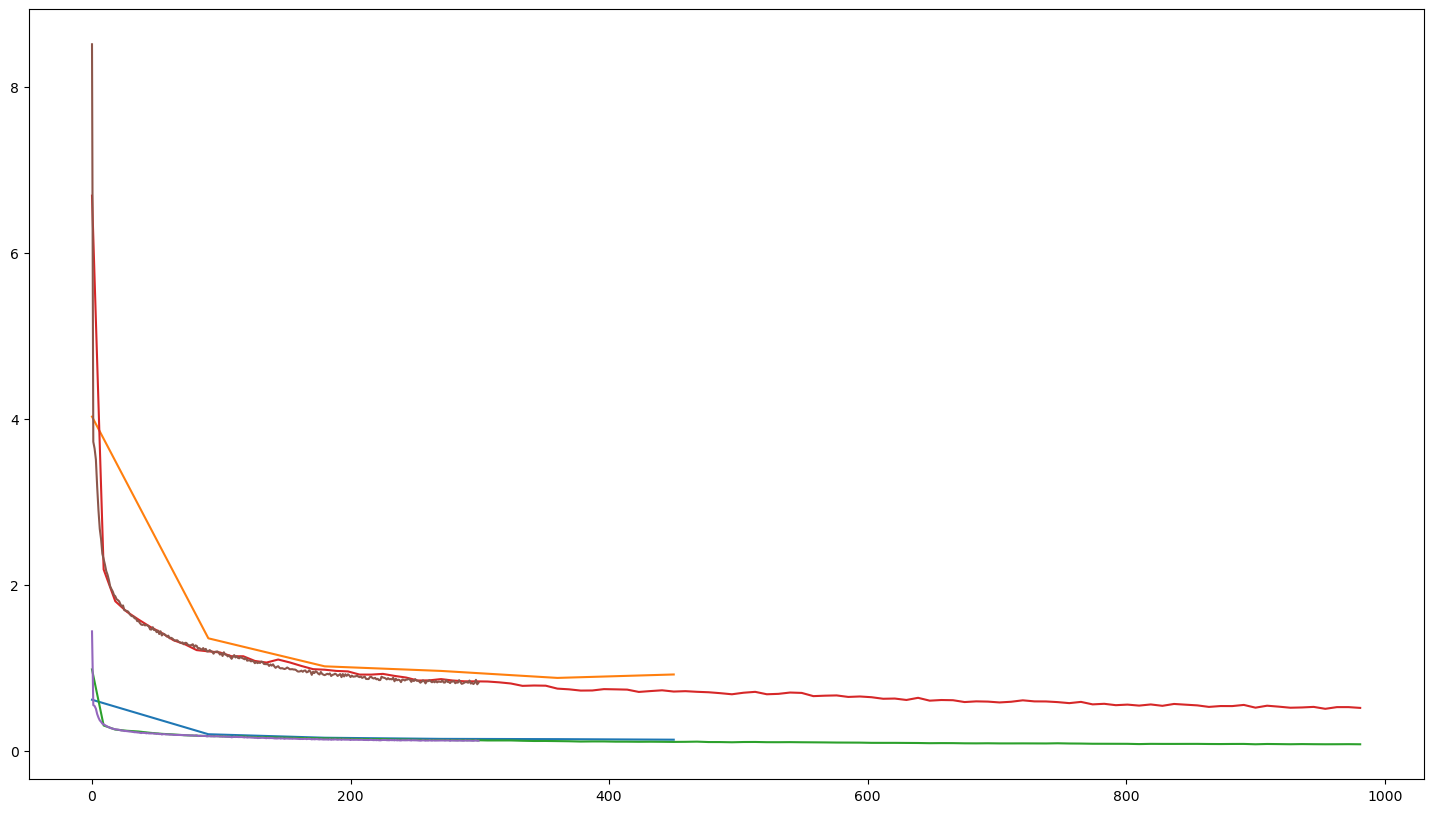

In [268]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(np.arange(6)*90,np.array(Analytic_well_formed_batch_10['Gen_D_KL']))
ax.plot(np.arange(6)*90,np.array(Analytic_well_formed_batch_10['Data_D_KL']))
ax.plot(np.arange(110)*9,np.array(Analytic_well_formed_batch_100['Gen_D_KL']))
ax.plot(np.arange(110)*9,np.array(Analytic_well_formed_batch_100['Data_D_KL']))
ax.plot(np.arange(300),np.array(Analytic_well_formed_batch_1000['Gen_D_KL']))
ax.plot(np.arange(300),np.array(Analytic_well_formed_batch_1000['Data_D_KL']))
# ax.plot(np.array(Analytic_well_formed_batch_10000['Gen_D_KL']))
# ax.plot(np.array(Analytic_well_formed_batch_10000['Data_D_KL']))
plt.show()

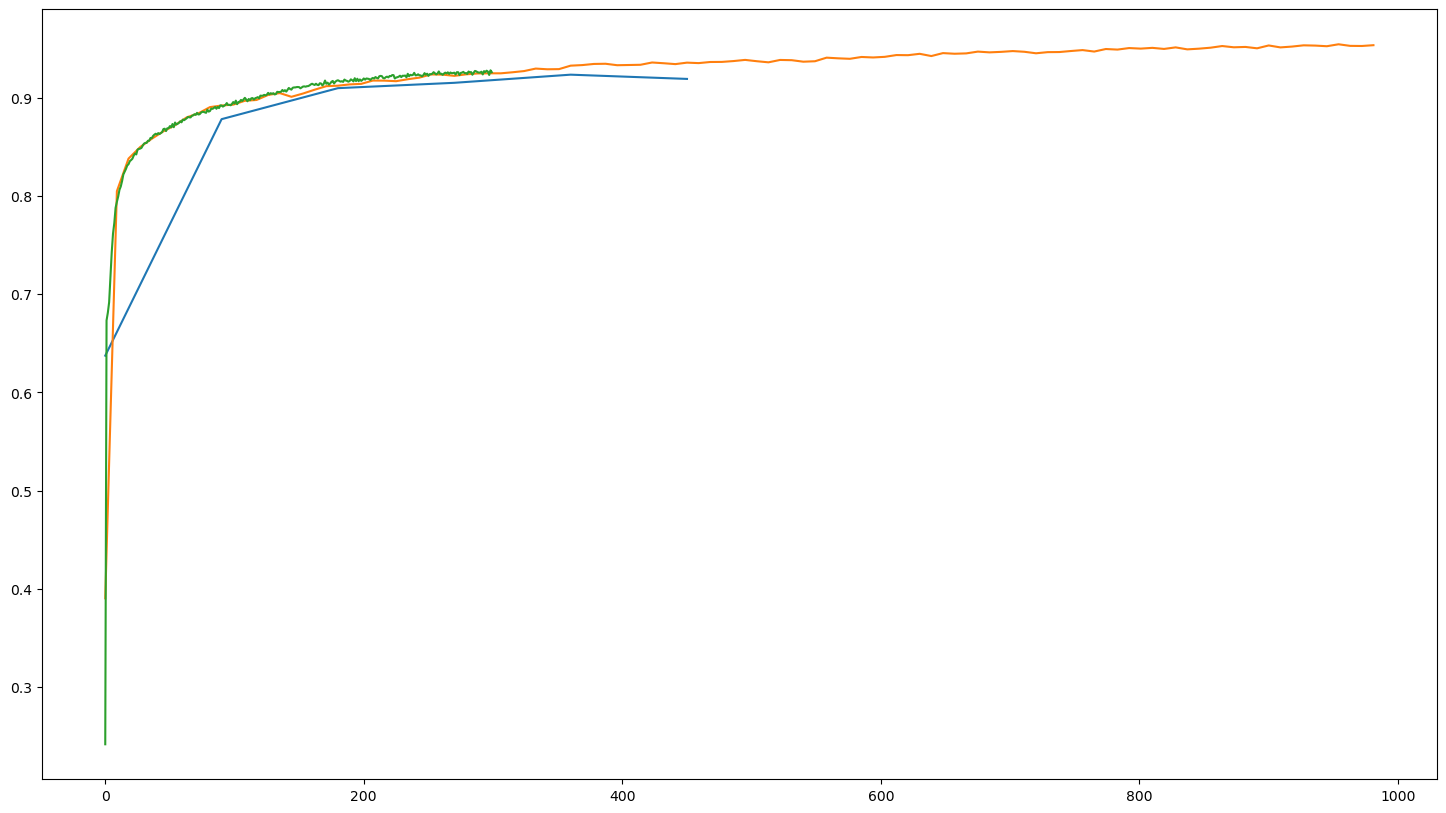

In [270]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(np.arange(6)*90,np.array(Analytic_well_formed_batch_10['Accuracy']))
ax.plot(np.arange(110)*9,np.array(Analytic_well_formed_batch_100['Accuracy']))
ax.plot(np.arange(300),np.array(Analytic_well_formed_batch_1000['Accuracy']))
# ax.plot(np.array(Analytic_well_formed_batch_10000['Accuracy']))
plt.show()

In [223]:
print(np.array(Analytic_well_formed_batch_1000['Gen_D_KL'][-10:]))
print(np.array(Analytic_well_formed_batch_1000['Data_D_KL'][-10:]))
print(np.array(Analytic_well_formed_batch_1000['Accuracy'][-10:]))

[0.12354343 0.1250408  0.12515314 0.12359931 0.1229745  0.12255436
 0.12461551 0.12722346 0.12269408 0.12325349]
[0.82805371 0.82194841 0.84859443 0.81212705 0.82101041 0.80654687
 0.81969762 0.85698342 0.80333072 0.82317936]
[0.9257  0.92656 0.9238  0.92718 0.92625 0.92761 0.92668 0.92326 0.928
 0.9261 ]


In [83]:
# Analytic_ws_online.dtypes

In [224]:
parameters = {'Phi': Phi, 'Theta': Theta}
torch.save(parameters,'Parameters_well_formed_batch_1000')

In [225]:
Analytic_well_formed_batch_1000.to_csv('Analytic_well_formed_batch_1000.csv', index = False)

In [271]:
wake_dict = wake_sample(Phi,data,dev)
Dist_wake = {}
for key in wake_dict:
    sample_w = wake_dict[key]
    values_g,counts_g = torch.unique(decimalize(sample_w,dev),return_counts=True)
    dist = torch.zeros(2**sample_w.shape[0],device=dev)
    dist[values_g]=counts_g/sample_w.shape[1]
    Dist_wake[key] = dist

In [272]:
sleep_dict = sleep_sample(Theta,gen_batch_size,dev,cor=True)
Dist_sleep = {}
for key in sleep_dict:
    sample_s = sleep_dict[key]
    values_g,counts_g = torch.unique(decimalize(sample_s,dev),return_counts=True)
    dist = torch.zeros(2**sample_s.shape[0],device=dev)
    dist[values_g]=counts_g/sample_s.shape[1]
    Dist_sleep[key] = dist

Layer 0 Data_dist D_KL: 0.8265
Layer 0 Gen_dist D_KL: 0.1416
Layer 1 Recognition Distribution D_KL: 0.9491 H(Y): 4.4516 H(Y|X): 1.673 I_XY: 2.7786
Layer 1 Generative  Distribution D_KL: 0.1882 H(Y): 4.5382 H(Y|X): 1.3867 I_XY: 3.1514
Layer 2 Recognition Distribution D_KL: 0.2728 H(Y): 2.0605 H(Y|X): 1.3555 I_XY: 0.705
Layer 2 Generative  Distribution D_KL: 0.0566 H(Y): 2.2181 H(Y|X): 1.3933 I_XY: 0.8249
Layer 3 Recognition Distribution D_KL: 0.0946 H(Y): 0.9319 H(Y|X): 0.7975 I_XY: 0.1344
Layer 3 Generative  Distribution D_KL: 0.0157 H(Y): 1.0043 H(Y|X): 0.849 I_XY: 0.1553
Layer 4 Recognition Distribution D_KL: 0.0144 H(Y): 0.7602 H(Y|X): 0.7078 I_XY: 0.0524
Layer 4 Generative  Distribution D_KL: 0.0026 H(Y): 0.7532 H(Y|X): 0.6951 I_XY: 0.0581


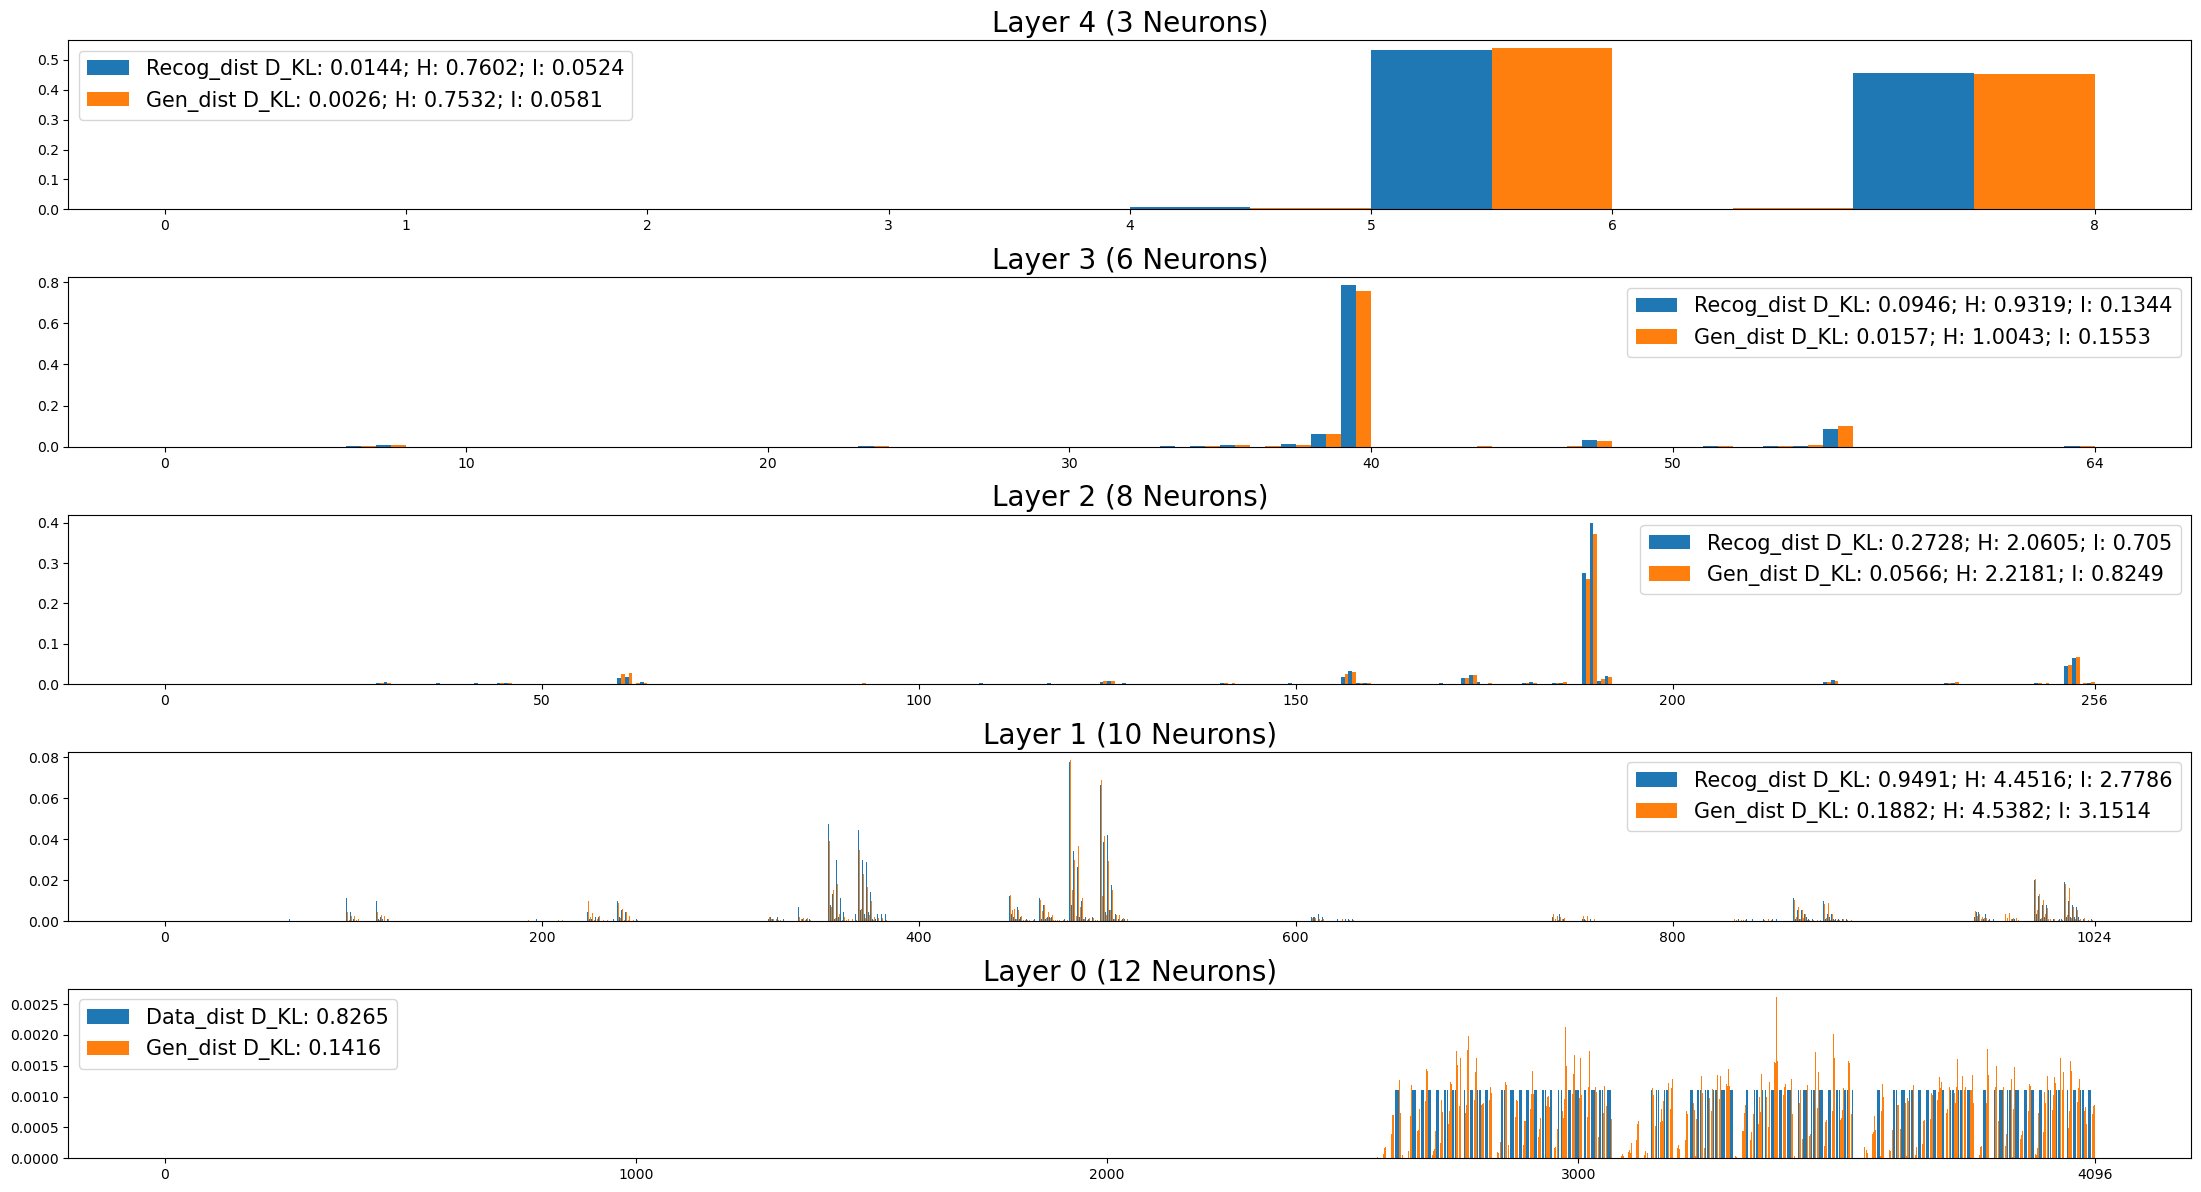

In [273]:
fig_ct, ax_ct = plt.subplots(n_layer-1, 1, figsize=(22, 12))
# fig_ct.suptitle("Layer-wise Categorical Distribution",fontsize=25)
H_Y_w, I_w = wake_entropy(Phi,data.repeat(1,50),dev)
H_Y_s, I_s = sleep_entropy(Theta,gen_batch_size,dev)
H_Y_w = H_Y_w.numpy()
I_w = I_w.numpy()
H_Y_s = H_Y_s.numpy()
I_s = I_s.numpy()
for i in range(n_layer-1):
    dist_w = Dist_wake['Layer_'+str(i)]
    dist_s = Dist_sleep['Layer_'+str(i)]
    D_KL_w = KL_divergence(dist_s,dist_w).item()
    D_KL_s = KL_divergence(dist_w,dist_s).item()
    
    if i > 0:
        print("Layer "+str(i), "Recognition Distribution D_KL: "+str(np.around(D_KL_w,4)),\
          "H(Y): "+str(np.around(H_Y_w[i-1],4)), "H(Y|X): "+str(np.around(H_Y_w[i-1]-I_w[i-1],4)),"I_XY: "+str(np.around(I_w[i-1],4)))
        print("Layer "+str(i),"Generative  Distribution D_KL: "+str(np.around(D_KL_s,4)),\
          "H(Y): "+str(np.around(H_Y_s[i],4)), "H(Y|X): "+str(np.around(H_Y_s[i]-I_s[i-1],4)),"I_XY: "+str(np.around(I_s[i-1],4)))
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Recog_dist D_KL: " + str(np.around(D_KL_w,4))+"; H: "+ \
                               str(np.around(H_Y_w[i-1],4))+ "; I: "+ str(np.around(I_w[i-1],4)))
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
                          label = "Gen_dist D_KL: " + str(np.around(D_KL_s,4))+"; H: "+ \
                               str(np.around(H_Y_s[i],4))+ "; I: "+ str(np.around(I_s[i-1],4)))
    else:
        print("Layer "+str(i), "Data_dist D_KL: "+str(np.around(D_KL_w,4)))
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Data_dist D_KL: " + str(np.around(D_KL_w,4)))
        
        print("Layer "+str(i), "Gen_dist D_KL: "+str(np.around(D_KL_s,4)))
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Gen_dist D_KL: " + str(np.around(D_KL_s,4)))

    ax_ct[n_layer-2-i].set_title("Layer "+str(i)+" ("+ str(n_dz[i].item())+" Neurons)",fontsize=20)
    ax_ct[n_layer-2-i].legend(fontsize=15)
    
    x_lim = 2**(n_dz[n_layer-2-i])
    if i==0:
        xtick = np.arange(0,x_lim)
    elif i==1:
        xtick = np.arange(0,x_lim,10)
    elif i==2:
        xtick = np.arange(0,x_lim,50)
    elif i==3:
        xtick = np.arange(0,x_lim,200)
    elif i==4:
        xtick = np.arange(0,x_lim,1000)    
    xtick[-1] = x_lim
    ax_ct[i].set(xticks=xtick)
    

plt.tight_layout(pad=1)    
plt.show()

### Plot Analytic

In [291]:
Analytic = Analytic_well_formed_batch_10
Analytic

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Theta_Loss_Layer_0,Theta_Loss_Layer_1,Theta_Loss_Layer_2,Theta_Loss_Layer_3,Theta_Loss_Layer_4,Data_D_KL,...,Recog_I_Layer_4,Gen_H_Layer_0,Gen_H_Layer_1,Gen_H_Layer_2,Gen_H_Layer_3,Gen_H_Layer_4,Gen_I_Layer_1,Gen_I_Layer_2,Gen_I_Layer_3,Gen_I_Layer_4
0,0.687449,0.691419,0.693989,0.692624,0.631281,0.687018,0.690308,0.692264,0.693436,4.030091,...,0.003976,7.583387,6.811593,5.498814,4.147600,2.076158,0.050487,0.022626,0.011307,0.004847
1,0.366089,0.495578,0.513353,0.584033,0.413714,0.434284,0.560662,0.570818,0.686766,1.357519,...,0.326656,7.328447,5.835708,5.255879,3.746027,2.061844,2.395200,1.424636,0.723059,0.347462
2,0.295790,0.399549,0.393500,0.425991,0.364384,0.423614,0.480058,0.449406,0.496141,1.019784,...,0.257533,7.344506,5.738404,4.523254,2.920599,1.477739,2.973024,1.499464,0.704703,0.263775
3,0.224016,0.314801,0.184049,0.226927,0.359871,0.374426,0.374051,0.247322,0.282207,0.964440,...,0.194312,7.354813,5.073859,3.792029,1.728142,0.863960,3.062239,1.350589,0.750277,0.220111
4,0.223330,0.382669,0.246342,0.207483,0.344773,0.383886,0.448106,0.313708,0.294789,0.880244,...,0.300714,7.316213,5.176441,4.317076,2.242677,0.914335,3.147818,1.375247,0.781673,0.342343
5,0.229700,0.184627,0.181697,0.072001,0.353946,0.405757,0.265282,0.240854,0.085343,0.921639,...,0.044185,7.352777,5.121401,2.507061,1.504063,0.250499,3.122038,1.098403,0.410836,0.040147


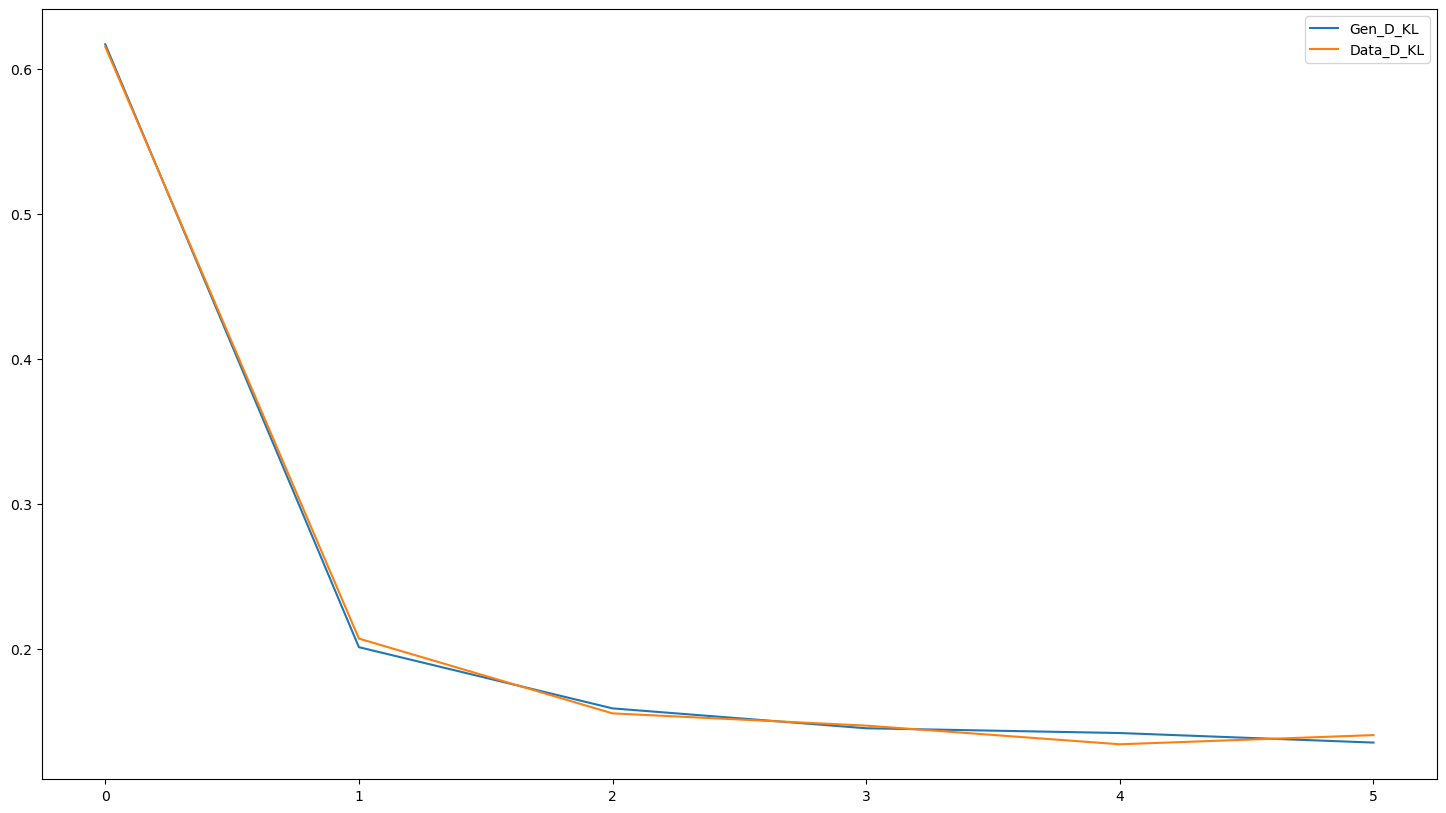

In [275]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(np.array(Analytic['Gen_D_KL']),label = 'Gen_D_KL')
ax.plot(np.array(Analytic['Data_D_KL'])/np.array(Analytic['Data_D_KL']).mean()*np.array(Analytic['Gen_D_KL']).mean(),label='Data_D_KL')
# ax.plot(np.array(Analytic['Data_D_KL']),label = 'Data_D_KL')
ax.legend()
plt.show()

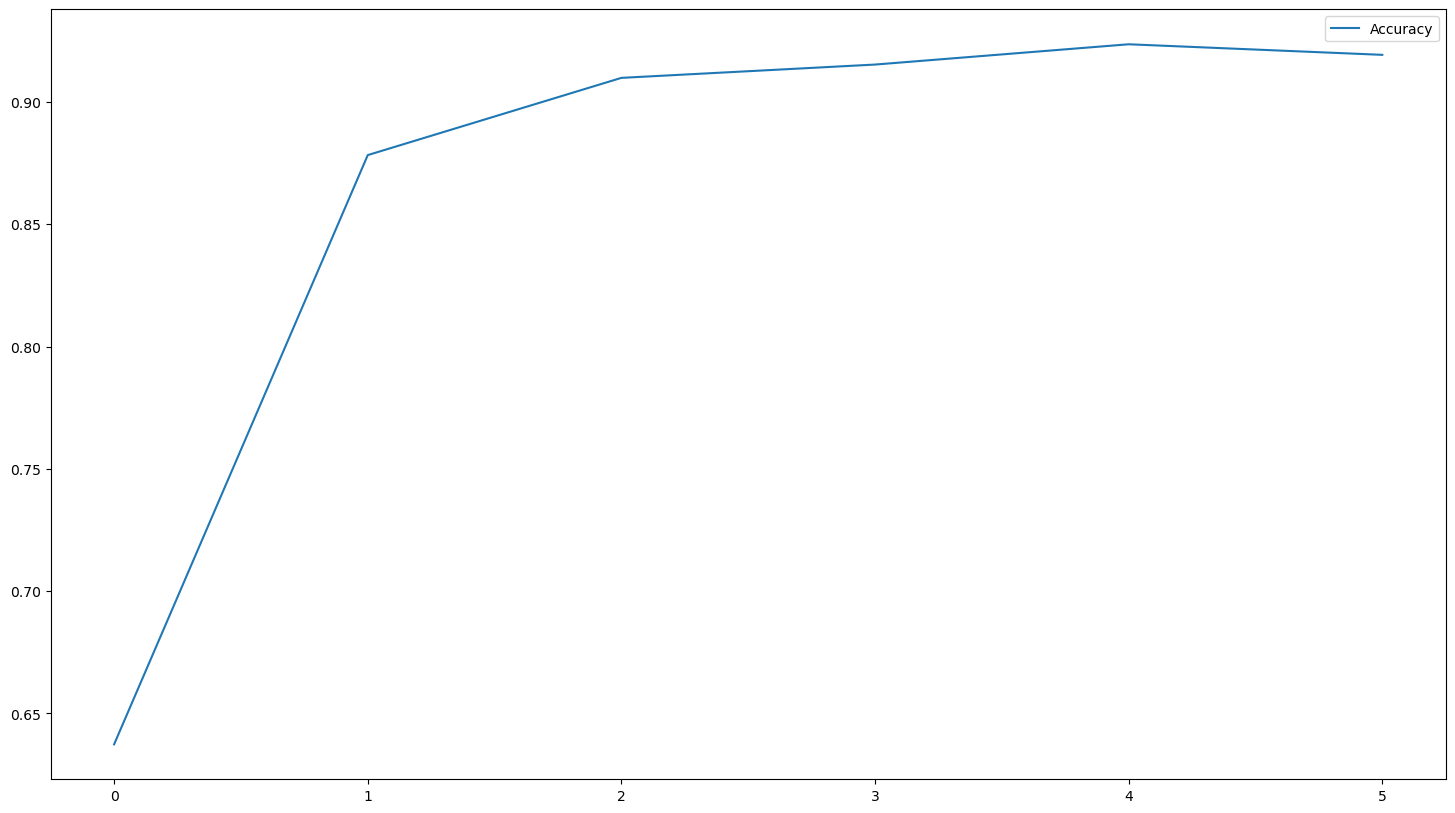

In [276]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(np.array(Analytic['Accuracy']),label = 'Accuracy')
plt.legend()
plt.show()

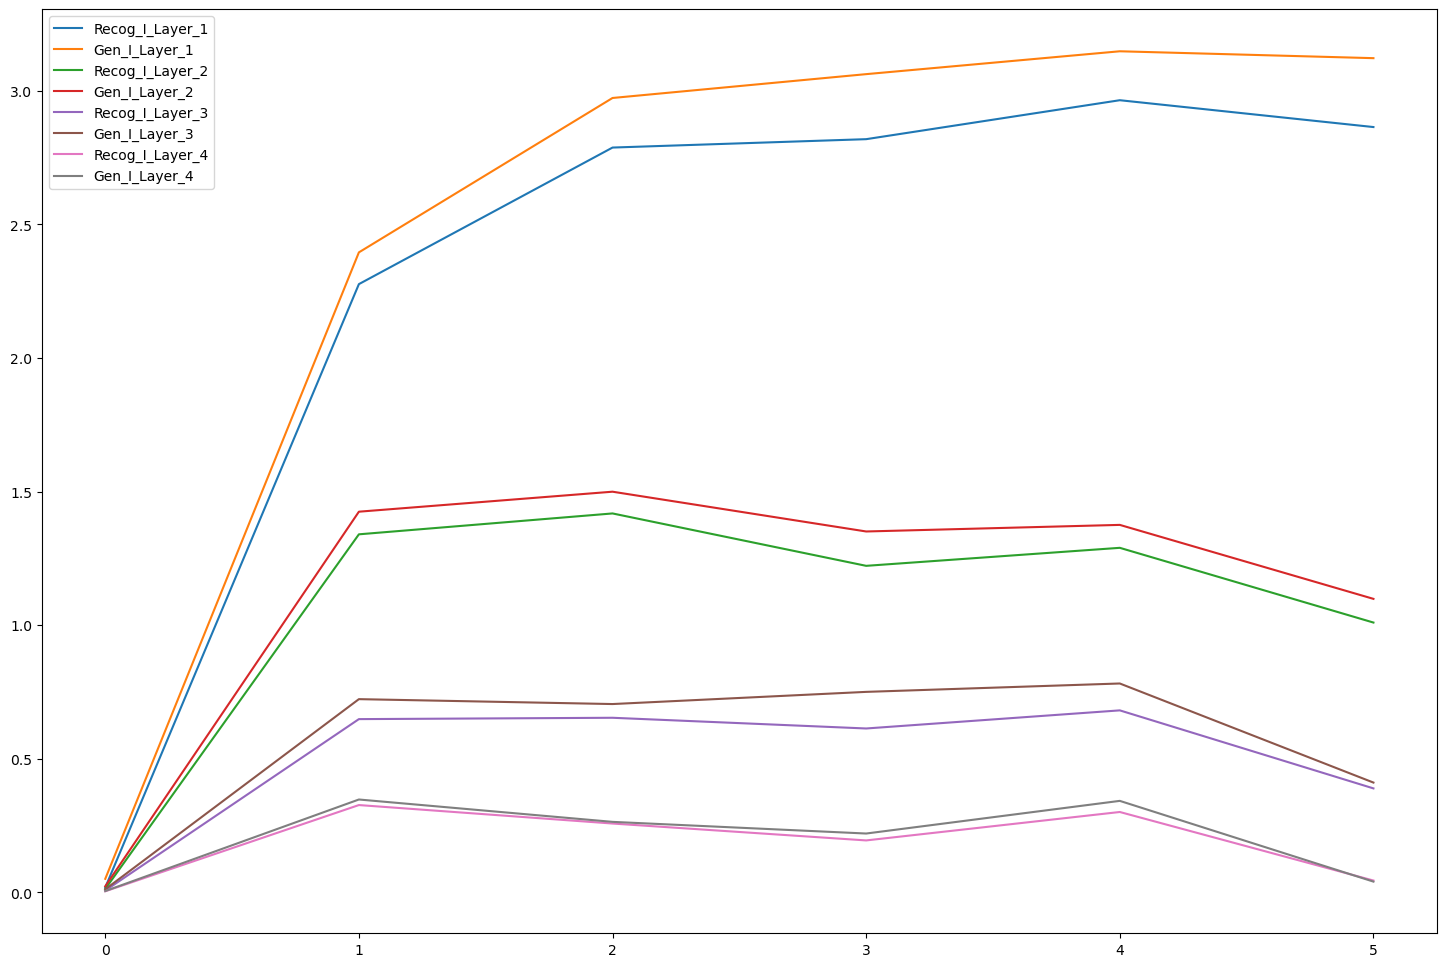

In [277]:
fig, ax = plt.subplots(figsize=(18, 12))
for i in range(1,n_layer-1):
    ax.plot(np.array(Analytic['Recog_I_Layer_'+str(i)]),label = 'Recog_I_Layer_'+str(i))
    ax.plot(np.array(Analytic['Gen_I_Layer_'+str(i)]),label = 'Gen_I_Layer_'+str(i))
ax.legend()
plt.show()

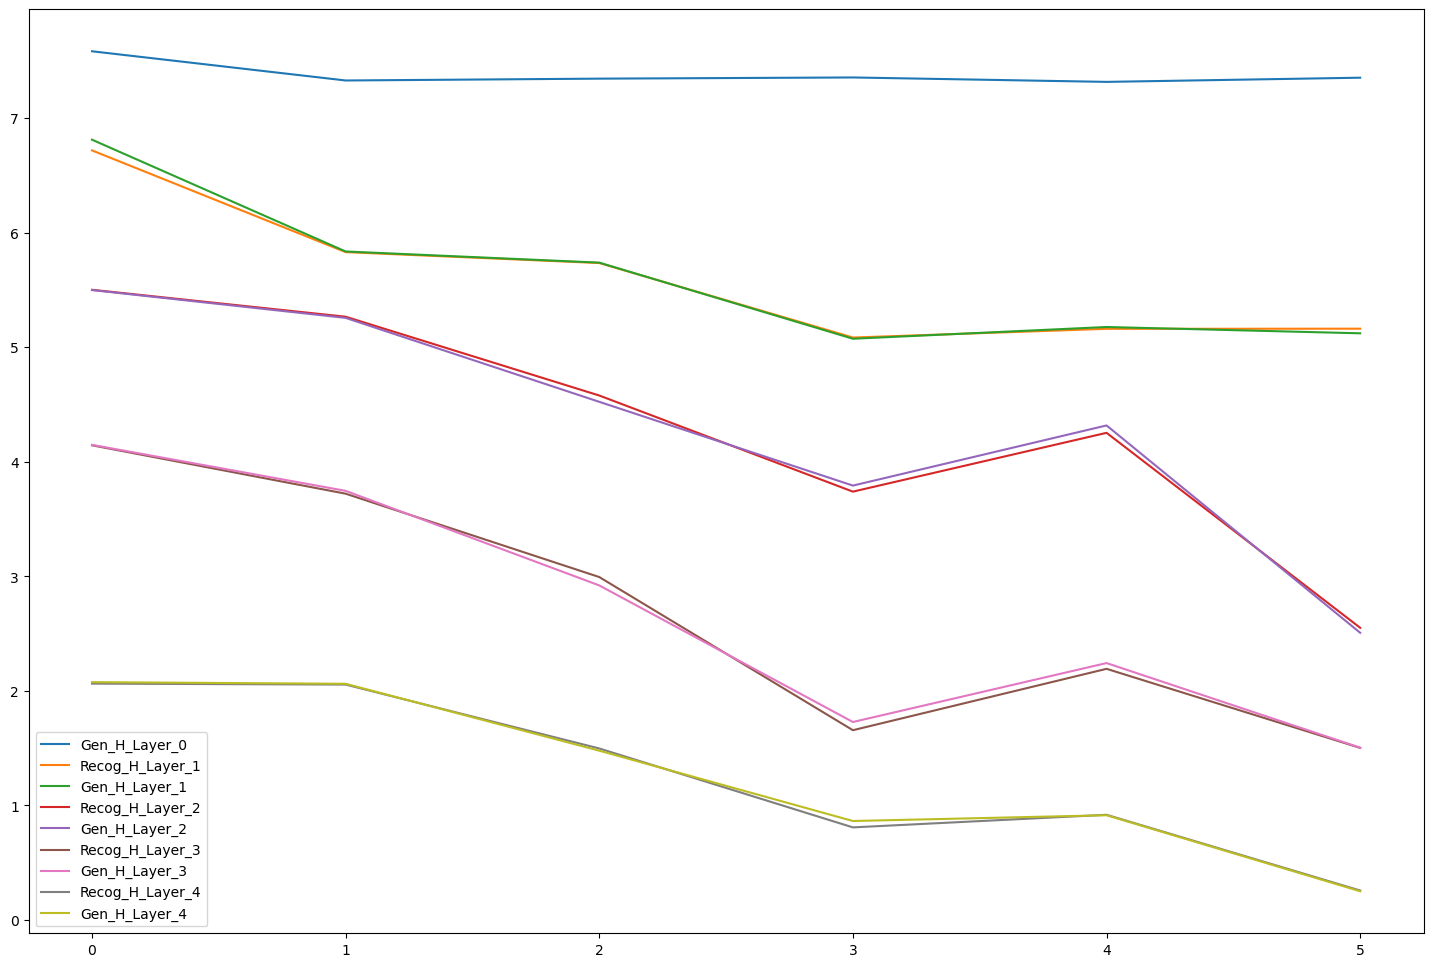

In [292]:
fig, ax = plt.subplots(figsize=(18, 12))
ax.plot(np.array(Analytic['Gen_H_Layer_0']),label = 'Gen_H_Layer_0')
for i in range(1,n_layer-1):
    ax.plot(np.array(Analytic['Recog_H_Layer_'+str(i)]),label = 'Recog_H_Layer_'+str(i))
    ax.plot(np.array(Analytic['Gen_H_Layer_'+str(i)]),label = 'Gen_H_Layer_'+str(i))
ax.legend()
plt.show()

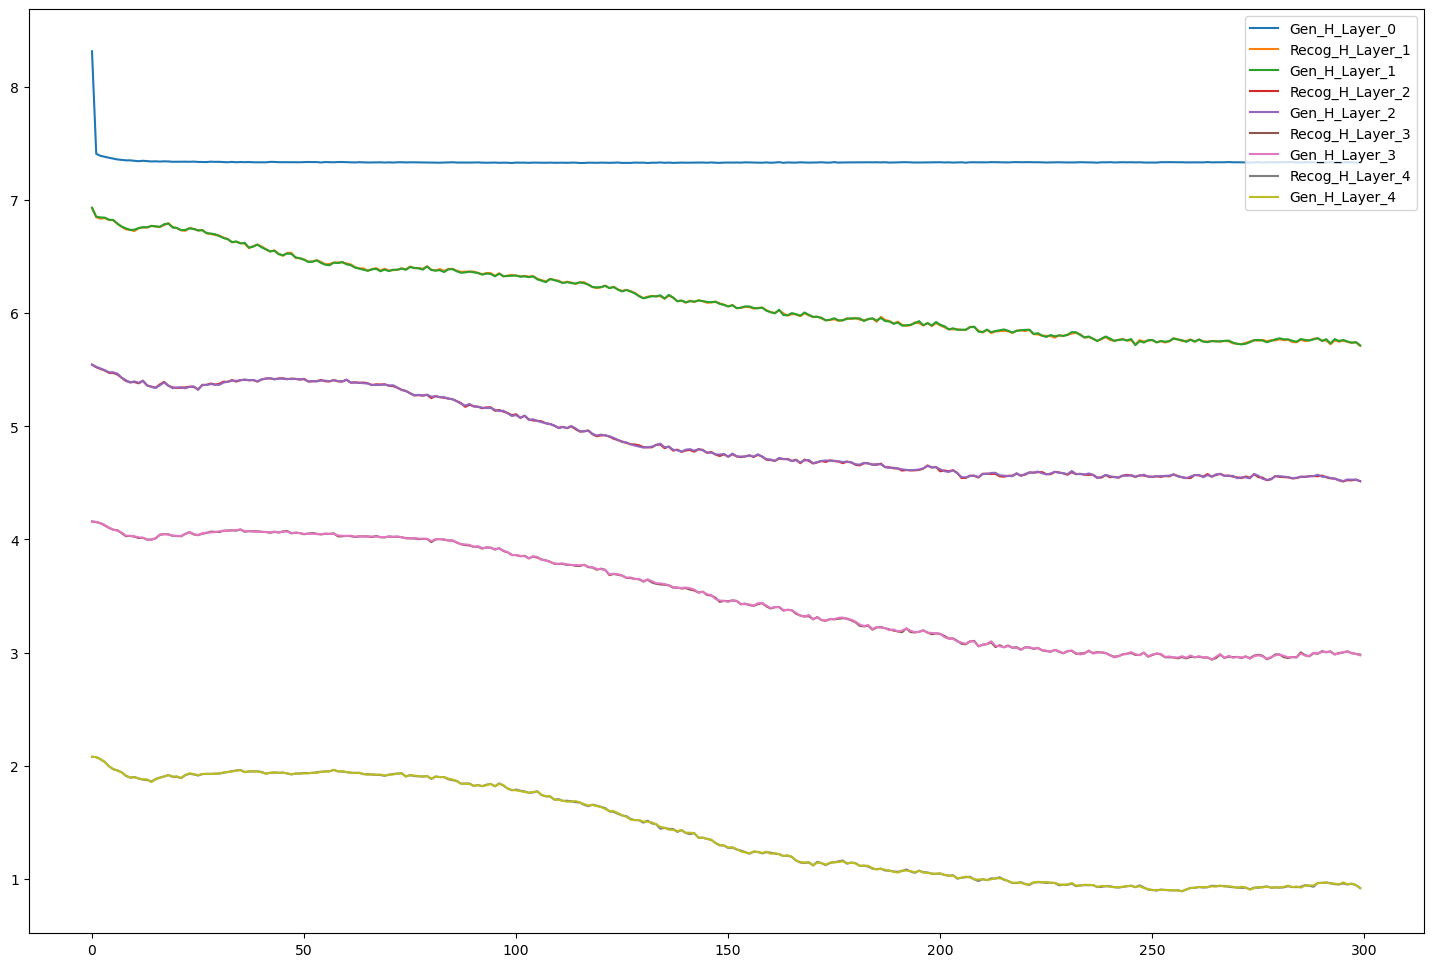

In [288]:
fig, ax = plt.subplots(figsize=(18, 12))
ax.plot(np.array(Analytic['Gen_H_Layer_0']),label = 'Gen_H_Layer_0')
for i in range(1,n_layer-1):
    ax.plot(np.array(Analytic['Recog_H_Layer_'+str(i)]),label = 'Recog_H_Layer_'+str(i))
    ax.plot(np.array(Analytic['Gen_H_Layer_'+str(i)]),label = 'Gen_H_Layer_'+str(i))
ax.legend()
plt.show()

In [279]:
n_dz * np.log(2)

tensor([8.3178, 6.9315, 5.5452, 4.1589, 2.0794, 0.6931])

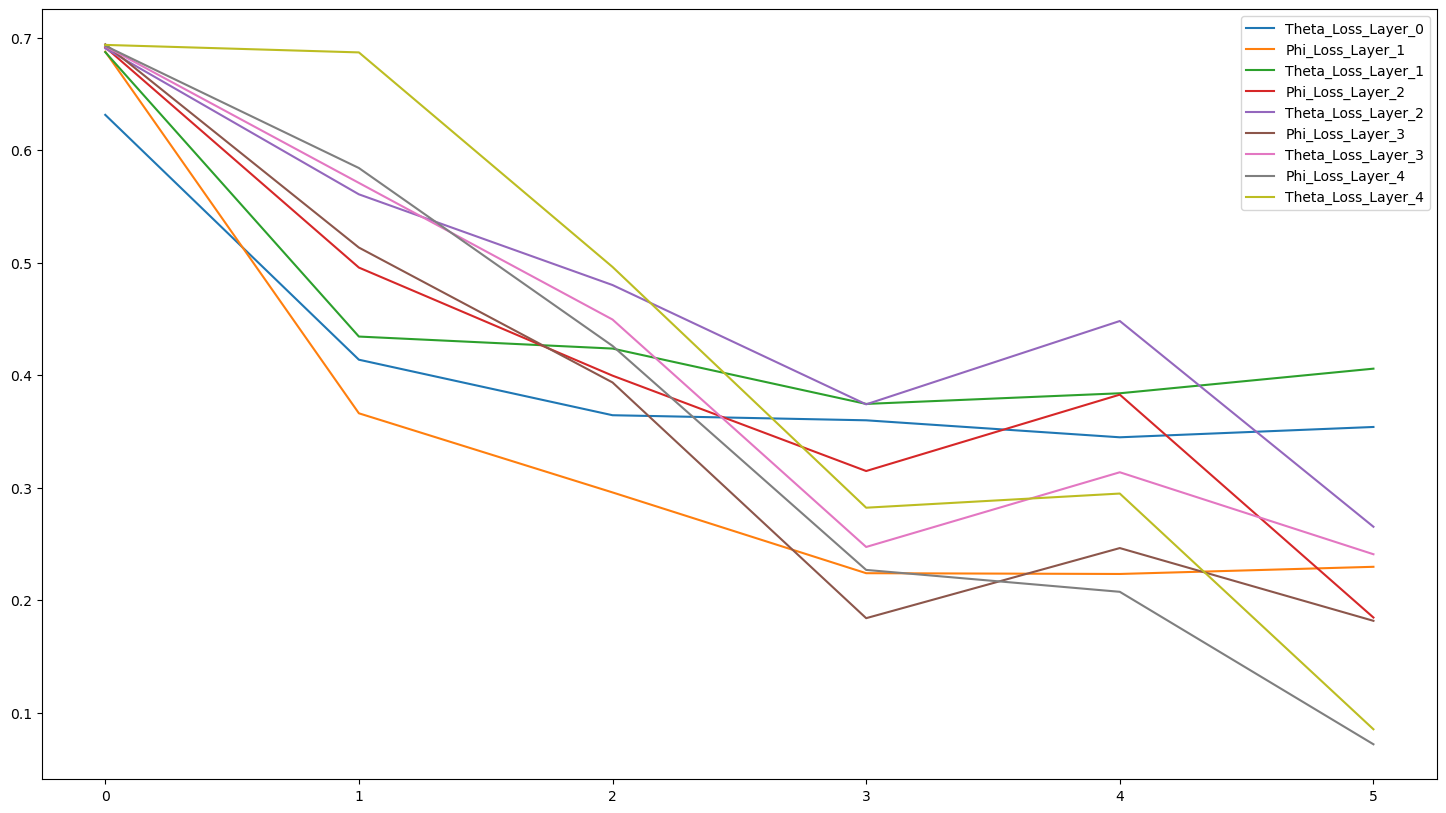

In [280]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(np.array(Analytic['Theta_Loss_Layer_'+str(0)]),label = 'Theta_Loss_Layer_'+str(0))
for i in range(1,n_layer-1):
    ax.plot(np.array(Analytic['Phi_Loss_Layer_'+str(i)]),label = 'Phi_Loss_Layer_'+str(i))
    ax.plot(np.array(Analytic['Theta_Loss_Layer_'+str(i)]),label = 'Theta_Loss_Layer_'+str(i))
ax.legend()
plt.show()

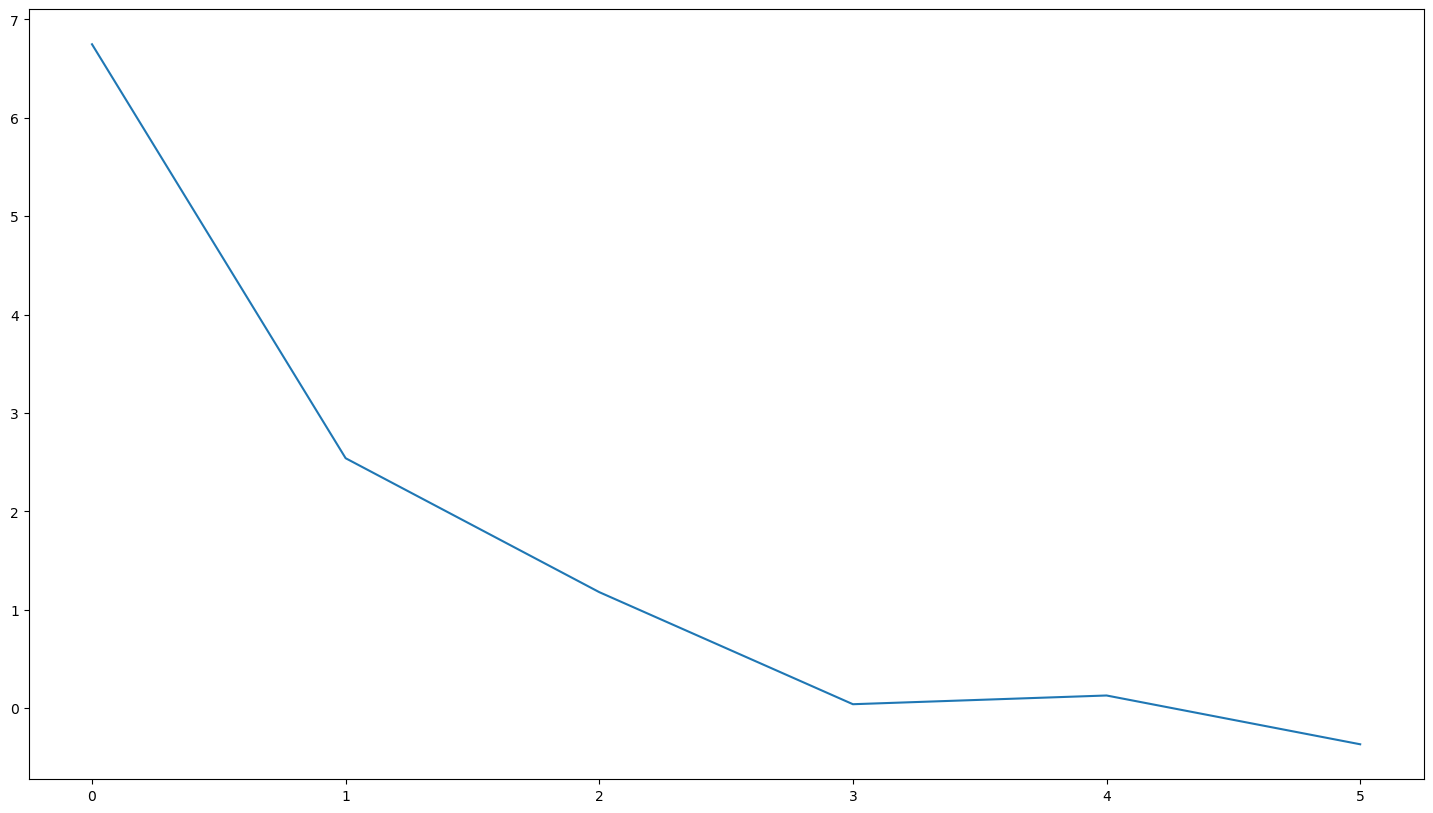

In [281]:
# normalized loss
Loss = 2*(np.array(Analytic['Theta_Loss_Layer_'+str(0)])-(np.array(Analytic['Gen_I_Layer_1'])/structure[i]))
for i in range(1,n_layer-2):
    Loss += np.array(Analytic['Phi_Loss_Layer_'+str(i)]) + np.array(Analytic['Theta_Loss_Layer_'+str(i)]) - \
    (np.array(Analytic['Gen_I_Layer_'+str(i+1)])+np.array(Analytic['Recog_I_Layer_'+str(i)]))/structure[i]
Loss += np.array(Analytic['Phi_Loss_Layer_'+str(n_layer-2)]) + np.array(Analytic['Theta_Loss_Layer_'+str(n_layer-2)]) - \
        np.array(Analytic['Recog_I_Layer_'+str(n_layer-2)])/structure[n_layer-2]
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(Loss)
plt.show()

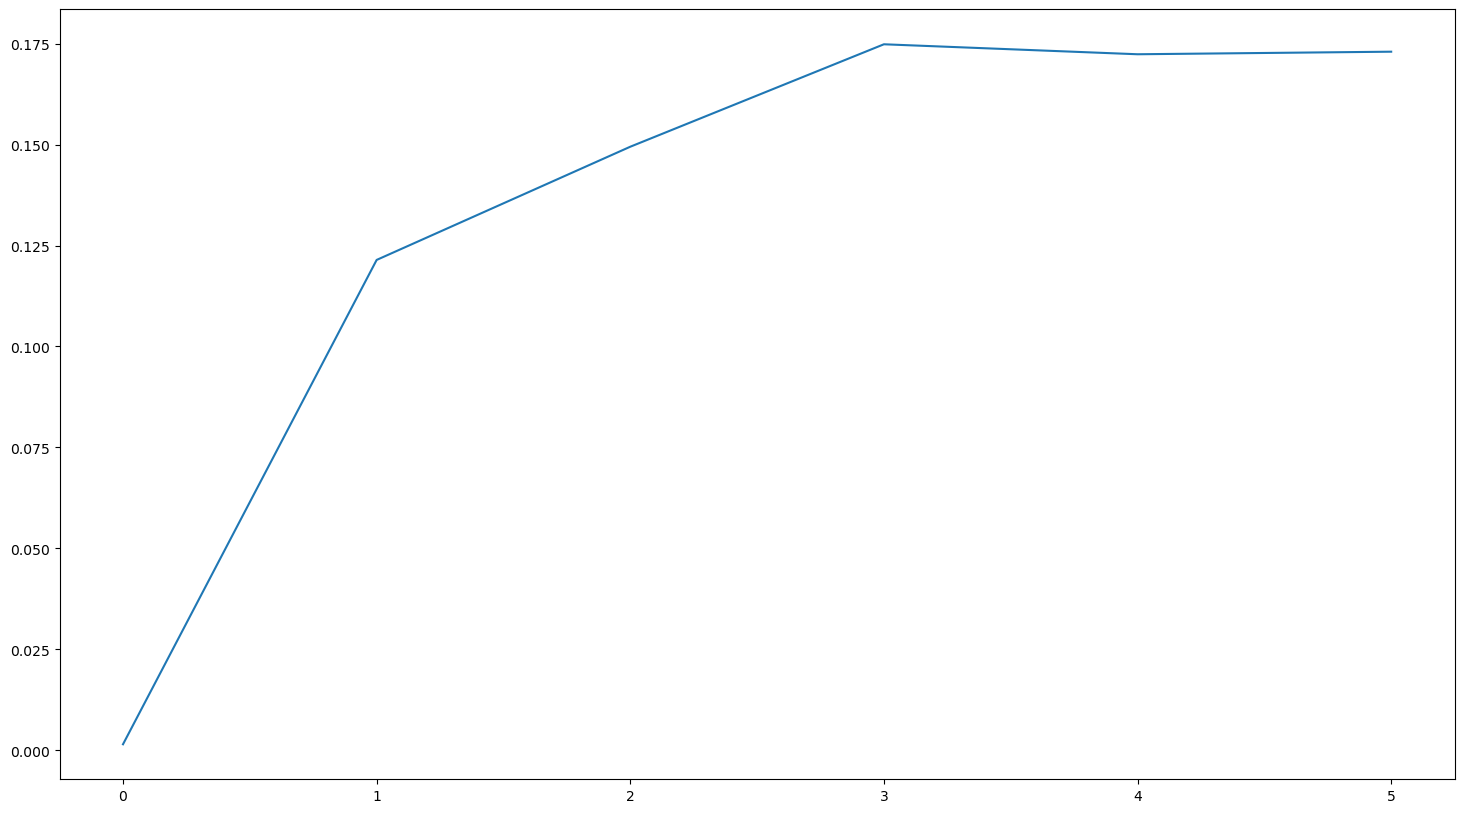

In [282]:
# normalized mutual information
I = np.array(Analytic['Recog_I_Layer_'+str(1)]) + np.array(Analytic['Gen_I_Layer_'+str(1)])
H = np.array(Analytic['Recog_H_Layer_'+str(1)]) + np.array(Analytic['Gen_H_Layer_'+str(0)]) + \
    np.array(Analytic['Gen_H_Layer_'+str(1)]) + np.array(Analytic['Gen_H_Layer_'+str(0)])
for i in range(1,n_layer-2):
    I += np.array(Analytic['Recog_I_Layer_'+str(i+1)]) + np.array(Analytic['Gen_I_Layer_'+str(i+1)])
    H += np.array(Analytic['Recog_H_Layer_'+str(i+1)]) + np.array(Analytic['Recog_H_Layer_'+str(i)]) + \
    np.array(Analytic['Gen_H_Layer_'+str(i+1)]) + np.array(Analytic['Gen_H_Layer_'+str(i)])
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(I/H)
plt.show()